# ML in Cybersecurity: Task 3

## Team
  * **Team name**:  *ChickenEgg*
  * **Members**:  *Sangeet Sagar (sasa00001@stud.uni-saarland.de), Abhijith Srinivas Bidaralli (abbi00001@stud.uni-saarland.de), Abhinav Bhatt (abbh00001@stud.uni-saarland.de)*



## Logistics
  * **Due date**: 9th December 2021, 23:59:59
  * Email the completed notebook to: `mlcysec_ws2022_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the forum to discuss.
  
## Timeline
  * 26-Nov-2021: hand-out
  * **09-Dec-2021**: Email completed notebook
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal is to train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use the final summary to provide a report about these.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [39]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import json 
import time 
import pickle 
import sys 
import itertools
import csv
import gc
import os
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path
from dataclasses import dataclass
from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torchmetrics
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`
  * Hint: you can execute shell scripts from notebooks using the `!` prefix, e.g., `! wget <url>`

In [79]:
!wget -O train.tar.gz https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm/download
!wget -O test.tar.gz https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE/download

--2021-12-09 02:04:43--  https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm/download
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)... 139.19.205.150
Connecting to nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)|139.19.205.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134409420 (128M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 128.18M  14.4MB/s    in 7.6s    

2021-12-09 02:04:51 (17.0 MB/s) - ‘train.tar.gz’ saved [134409420/134409420]

--2021-12-09 02:04:52--  https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE/download
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)... 139.19.205.150
Connecting to nextcloud.mpi-klsb.mpg.de (nextcloud.mpi-klsb.mpg.de)|139.19.205.150|:443... connected.
HTTP request sent, awaiti

In [80]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [81]:
!tar -xzvf train.tar.gz -C data/

train/
train/b1b6b8c99c0a96c5a6887f24c6f958f111cad396.Virut
train/fdb3a4a2d74bdaa9246c70d6e23061a16cf0ced2.NothingFound
train/278fb356d8db10a27aa15643d6b967261ac6c60d.Swizzor
train/819d667c9a97876c8c1f28e224ea839045ddca7c.NothingFound
train/912f3ab82f486a647d0a545778667bc01edb9fa2.Agent
train/007970b635067779d4fcc664ec870c248bcc77f0.NothingFound
train/b2a64df660f3967f3c65c01170438221f05a7652.NothingFound
train/6a9a2c48e699b11c678f1235dc9941ef38288018.Texel
train/5ba887d588e50b65630d046460f55d8ba5f255af.Texel
train/f301bab7fb9e84c2b176a8df237a9388eac01121.NothingFound
train/8545bdfbffc9bc8c234954602e09b540f131c2e3.NothingFound
train/957c330ed5f073524e3ab09b9d13e3c3a6e61c15.Basun
train/ec21f0d77d04b9ffe5e5326a4e78ab57862b0d91.NothingFound
train/49cc3287203eb56440cffaaf168cc9b0f57182e1.Virut
train/8dad0a49f806fed7305d1ac6d276c66e04524a8d.NothingFound
train/226d28ae493533464518d40ac348901a9f3a24e5.Swizzor
train/1e5497cb5f87252a1c7c68010baf457013afea94.Virut
train/42f4c447271a550170f12ad0f5

train/9a64ae3f9021396754f5e74a97b20eb66f5028cf.NothingFound
train/9a8b302f25716aada079eff1314c852575828f87.NothingFound
train/8308ab3e9bcf8bcd3ece26175a4f3a451d7a4073.NothingFound
train/2db9bbf0cb4b5bc0fbdf5c59634e0369dc542819.Texel
train/ed80cb9d46319a9db9d28bd67796d86412096e14.AutoIt
train/e4b2075a9da7eccc74e94044af4b1e0f9a797e17.Basun
train/637a4e70ecfb646d26028a26e0425914926427a7.AutoIt
train/3d711eb20d2d04354115b1b2f70067df093a5501.Texel
train/c2298c535ac9054b555be78d6781d151bb469829.NothingFound
train/2f6373a93c68b7b7f6895bee237e21c6472e1d87.AutoIt
train/30ab82446e2340e07fd19fbe1967f831d2c2ee75.Patched
train/26043af89dfd8f9a69abef44798b3fd6caf8a030.Allaple
train/fd8a824ead436f78356781489fb83927645d88f2.NothingFound
train/f51cc660a1bb74eaa7451fe256bb7844bb7f48ca.NothingFound
train/882bc019cd5dc3fe66e5061005ab002f111f7643.AutoIt
train/14fb74237b3c114318f43f919e58d360b5f9e340.Virut
train/aade2026baff8617a005a8a9ba5bf8dc731819fb.NothingFound
train/3f07850c9ee8148aecfa3b1b718b4fe606a3

train/04febddbf8265a8950799631d6d42dbd8d6cfb75.NothingFound
train/a56a67796b50a2ca872f45259a6e551ab3ca6bd8.VB
train/5f1c83726a52d946a42d10113ea89e5df56fe742.Texel
train/60d2feaadd176f363106168d4d25d72faafde66f.Virut
train/58d4c23f2794b26e5fe09b351db4364b59e7c222.NothingFound
train/2e6f21a9386a2594049d9d68b15b6086f5b85ee0.Texel
train/7b71b74dff527a609ac845e17b3a25fcc95c6290.Basun
train/600bd2b5c6cfaadded269ee526d762cb6091763b.NothingFound
train/0d16846f859c2f146fa98c9fabc1e8a114d5a7b6.Basun
train/6fdbb1e7305b00bb0bebe7c906ab1cc1b02c9473.Texel
train/7f4c9dd5507bcfece087095fe48581dc562d44b8.NothingFound
train/7f3217db61a0dc06f90aff88c851d5d2a2d8e43a.Basun
train/6ae3b4524b93354199ca5a1a48fc326d75b562a0.NothingFound
train/0797c77b0768f080546b54629cefe5654f090c27.Texel
train/c11ea800113d81c5e52c66e70e4d60b36223c5df.Texel
train/cc08674ff24e31d31a7c699238750bc210b6cd32.Virut
train/38752ba851a867473a20ca80a298f23ebe5b9314.Allaple
train/317ff895585c364298477840eacbb84329a8a8a9.Swizzor
train/5626

train/94b5a7c760b950e71ce5e575f6b614a311a333f9.Basun
train/1c38c0af08a76dd7898d5458aafdfc762ffbb063.NothingFound
train/71da253988594b824f9ce8187a7036b286b0d542.VB
train/cb9a3764b2564d526f510d19336a5698ee63b9f0.Swizzor
train/7667c184aa978c70d2ee57ac27399112a4cf86c6.Texel
train/754034ef4aa02407f795d84814b4a865589a65b7.Virut
train/f5baa871b4590bf08162676fc2cdf839dbc6c6b2.AutoIt
train/8f79ce9300991ba7f0215f6f615ce720dea850d2.NothingFound
train/e9e3099ad4252a4f0fdf4b841e9fa44c3b49e2b2.NothingFound
train/46a20796c31ac9e2a5536017a9001e02df1862e4.Agent
train/0283d9869ca35797a35e3b8855ef4b0ae619228d.Texel
train/4953318ff4cf70fb2dfd423e14abe9e2d5e987eb.Texel
train/1a1e5b993c4f2f83ae05fa1e2db78cf20842d506.Basun
train/6e5aceab70f4250ac712924f715c51b9afd902fb.Texel
train/ee96d3c0b36bdde987302a6c614d1871a57a73f4.VB
train/8f3a128a519e813b18644406b68228965968b69d.Swizzor
train/d0fb29f0e2e61c7e8ea66f0da6a09c8896a7b4ee.Basun
train/5da974d3d8b41700eb12c53189d549b63aa7b7f7.NothingFound
train/a33ff25cb181b

train/4b9c7388f1f96642facd09aec14de96369ff2fc0.Swizzor
train/d2b65fa7624082f5be7486b51594f6403e7a8235.AutoIt
train/7e31e6ed884c75cd740d459fa81f2888590ebc6d.NothingFound
train/746088414db44aa9fb8ae9d35bfce315d43d9f54.NothingFound
train/c7d32da7b1dd277cae653a1b92d17e03e4dfb3dd.Texel
train/418940ae0aa6ff5be2d9add62497e5a0e7b284b7.Virut
train/732edfef4943d7e628fd8229b55147790c29e715.Swizzor
train/6836f629f4ae4db94a12b4cd4dd1f2603cc53061.Virut
train/ccefb5a85a7cbf8203d52feea0155b1c218b0371.Swizzor
train/7f93f890875f7a0015899d5125a7b96f1d089681.Agent
train/3fd8ec95538d39f26c5449e5831db6c9f00b58c8.Texel
train/99bb90fa04dcaadc01eddad5005f73eac9175d04.VB
train/aadc8f1758b984aa4dbe2f816284aef9652b7eaa.NothingFound
train/3bd73697a55dd3e6432df34c30e5fd72c8a96e71.Allaple
train/6f3a07c1fe8561f82b1a14f6574133f19fc70d07.Patched
train/421794d4f38d636df8c68ead92b44b794ce6b0ba.NothingFound
train/c750cdb43ddefe666556e58d2d8963d41769b99b.NothingFound
train/04a7e54a0b6e81d7551ed7655b4730be4c18a8cf.Virut
tra

train/96315f862131cc8a3e9d5a562171aa70b02985b9.Texel
train/5394ced98d7754e828966f4bbd5745d8fdef75ed.Virut
train/ff393ca012e3bb6b8986114181ece70fde991c58.NothingFound
train/1a3358dd497a6392509708379badaf4ec72a7e62.Virut
train/6a7c546614b657c93e4ff755557a2e9f28d44914.Basun
train/1c9790b00bfd2bc69911b26621510eb6b77e59f5.Swizzor
train/b1523272b5797863fb2f0b8ddf8289aab122c654.Virut
train/bcedef95355e02044d96fbca1c7743e9d4b18ae9.Texel
train/821f021e805a12ce3277fa7f3b878814e2c5a606.NothingFound
train/311629059c3da7766b3c11fa121b197542194073.Basun
train/e1f8cf914d2a0b6a58e555dec9ba8837b07a18ff.Texel
train/42743e25449165aaac9fdbeaacdb6f00493eb337.Texel
train/7356347d83a43fddd20477e6ef47ac0937905deb.Swizzor
train/6b94c71f4e7e2176f219caf505cf5b041eb6be8b.Virut
train/827f36030394c684092ecb6c1e47ade77867a155.Texel
train/39456f4c3c8c24ec2c3ac29d9c318b403f70a1f6.Swizzor
train/b3d711dfc10ec3bda30a9407d41ab1d64fd914b5.Allaple
train/c8e8cb8449788efdfeba8ffde8a8136283b20885.Agent
train/b2857e4d9b37309ed9

train/a89be6d44a9ef1f9548892d149b405dba7b6d601.Swizzor
train/0480a1a21dee28629db88d94d59be3f416f4caca.Virut
train/f73cfae01fd1d7691518df799059ceaace6e8a4b.Texel
train/95a123faac4f29287ec9f11807bc4bd99293872c.Texel
train/de294c5c5dee55ba9aa58dc200514296353d1b16.Texel
train/821930b613df0e87d53dad9123238b6398b2b006.Texel
train/2f365eb76596f6e5f4ac713d673092396ef2ef4b.Texel
train/36f8779cffd90093c5e716b95b49c04027a903c9.Basun
train/bc0c232d75bcb54db34cf63e3be353bd7aea228f.Texel
train/c208fe8e7f0f3b219a8db54485e60d578c28f4cf.Allaple
train/ea17f4f90bc6cd102a33fee7488668676e1b3dae.Texel
train/ae6a69c43016d27dc176652f5433ad1e219215f7.Virut
train/6b41d9412d0a0f4cee853967fbbc13f3002662b4.Swizzor
train/343371d4a82a52a2701e577927716e7b9998d083.Basun
train/fbfc1a052d47b89b9b2dd0b55f3989f638cbbeca.AutoIt
train/48c4c5b29ca2a7c2d2bd7afebf030fa1006fb84b.Texel
train/5d5788ca04ee7d27bfc1df629c958c8ff89e2e14.Basun
train/cf1e8a2e336b99baecce2c8e6ce56f1c7a52032b.NothingFound
train/3c714582fef9f8e4dbab255499

train/1c08c2aa64920989b1a18ab28eb6445ec9c890f0.AutoIt
train/8b19628685933a71e07c3a891a80fd7fc28b3aac.Texel
train/400c78807ce3fdd9007823e541b237f46581fd6e.Allaple
train/e1c1817c01ab68dd09144b03df13e83fa9433009.Texel
train/3e05455043a6ac1bfb556628bb123e4e7768963e.NothingFound
train/e2cbde62e4e645c4145532b828eb58786b385100.Texel
train/11ae02ab08d2b512f1dbd923de8a971d55489568.Texel
train/02b8c7d0301b252ee6cee72e68931cfd16df3d32.NothingFound
train/72fc009cbe976da3715b4ea8ece39151eec6a678.Texel
train/e85b33e6e27c8bdd84f18e11925c8c40834373a7.NothingFound
train/5f2ecd5219bfc8b90edfbfa68c9829b24936e789.Virut
train/846f546021662b66a5def36fb095aab88ce57825.Allaple
train/5347dcf7bac4ef25937e888092ea396c83cfe56f.Basun
train/c19bb399e0ddfd7e5d005dd99e5e40749f64a9c4.Basun
train/43f2d02ff08257e77f3b814b2383bbf75a9e16e1.AutoIt
train/704aa6db4eb6332141254b2db5727ba4190d9630.NothingFound
train/5befeb64fb3adb9838b206c3bf5cbe878fd252f2.NothingFound
train/7305bf1b28f7fc4a5214b318f5ad629614b7d091.Basun
train

train/97c6e8b126f4fd8fbf5f78a29c1511a18fe0cd30.NothingFound
train/c1dd34950313b8f0860c19b6f0dae44a01acb638.Basun
train/2354a2271227b2cccf05b165e53b31e817459b9b.Swizzor
train/1b11c1b6b2935024b0dccdae9f891d84a4699cf5.Swizzor
train/8a75996edaa43d88b3cd640287a84e6b301a9a0e.NothingFound
train/82acac9ae161721f3c0f1a1a22ffd65073ba4c87.NothingFound
train/bb181bb86b0c9caaeea70813e601e423e7cb78cd.Swizzor
train/d533685e51861052099844e8c536284bd96d053c.NothingFound
train/ebae98f1c584e8213c273d9043b2ba850e53ba5c.NothingFound
train/18e80eec747dc902219a131927ef9866c5f94d6b.Texel
train/f80b226c139d3d59d2756e0762308acf1fc69122.NothingFound
train/a0d304c2b4f8bfe2d92ef000c31257239ecb6e66.Texel
train/6eb817eb7a396801a5e6ab2b0a549d23bc97185e.VB
train/e452cb5cfd0b579d347392daae5811d0f2abd9df.Texel
train/4ecdffbb6d621967ca5f03a3d5dc22b493162945.Texel
train/4bec80a1423d60875f1819693172500156cc703e.NothingFound
train/40b0ae6909a703c958a9599756b2e625399a1dd3.NothingFound
train/db8d4ce0fe79eed47a64a0e21646ba65cc

train/1b9f60466400ad8c43c6711a9c1efdd30526b67f.Texel
train/7d572cd21d07ed7367897c6845cb5c6ce1505363.Basun
train/87c300f100632121722466b9fcea3c8a095da575.Texel
train/d781f762cecc61a3abacc2207d0cc372bfc257f0.Patched
train/46a33af5bf10652914c5b0aec27054cf77381098.NothingFound
train/5b1c54947db80e25614478f440bf15e112e4440f.VB
train/de23682454af289aa9bc39c86a4877be401a2995.Texel
train/504315a67536c47309de07467a330b4a7a6b6dbc.Virut
train/e7c532115aacf7d78c59708619a15d1a6b805e13.Patched
train/c9dc0ab3dd60a39cf022c02d3043335e50131014.NothingFound
train/e8b0f3181017a6aee1d4ee766c801664e572d135.NothingFound
train/e8941bad0ae645f5b965a3d4a083c40eebfc1254.VB
train/f498e20e63d70ae709eae35aedef8b64ab25c9db.Virut
train/7f29d7d8c9d5a38f3ebdb2ddadef43705bf8d496.Texel
train/106807c9c43416f92b3caa1247d09d487be752ba.Texel
train/8879675a6af76aa3561962e0219aa106cae84654.Texel
train/d0072aaed243822b141684041a8f4b2caeff47ef.NothingFound
train/fd0e410879ea644c8fb3f876a2221cac6ad02124.NothingFound
train/9f44f74

train/37fa1b7f820ac8716315f29ca2fd7925061ab524.NothingFound
train/0b71c0bd4e2aa5e77ce4962eeb6a9449e4c4f33a.NothingFound
train/20c17243a56187ee58c09bb6c04411e36183cef2.Texel
train/91db192d8c7d3e27e9ceeb78f14ab586bd54bb0f.NothingFound
train/b74df2e755d6b224614ebbe1f4ca69eb214a82f8.Texel
train/267cc1ea34324e65d82bec045b6784f636eb26f3.NothingFound
train/7e7be46b8039f9090bdf024e4787c0d190eee8ee.NothingFound
train/d9cf4268b43f2f0bdc01f03615646724d80f8f30.NothingFound
train/8ad52241e7de66dd1a0edd81ab230998382cbe9f.Texel
train/c28d3270ab953788af1da82b07b429bdf37fb99d.Agent
train/ecc40db7b6b42518bb053212d068fb62ef9db1c3.Basun
train/17c53f622a34fcdb079406db3f13edc0c07d2f73.Texel
train/446d38ea0a70a0eb0d2c08177abf2f66305a9b9c.Virut
train/cf06365be59c762f07e522233af16e7b0cf9532c.Texel
train/e8e0afb73239773086fef8a0fcfaad50478e24b8.Texel
train/a3ac13d04a36d237287652ce3d1ed630cab6e7d9.Agent
train/db6e35ac671cc8e8f151926849f80a00d38361a8.NothingFound
train/46b5fcff9c0aa58a547d20d60f0c04557fd2c6f2.Bas

train/cd4ae3a879554dc3b7d5323c818253c9dfc33c55.AutoIt
train/33eb5ed43d34cfd9b2db356daba73c741508782b.Swizzor
train/31164ebacca1929ca0fc7b4bb5fc8403fbc0bd4c.AutoIt
train/3a2a356d606b029dd04b8f509b4676f22e88b74c.Texel
train/59f7497f04d2e7787937c6a2c1acf12b237a068b.Basun
train/29e09156d8f7444f7a4a1ce9069a71a662690fa1.Basun
train/97d4f5129ba3f2e9cf0888f3706532405c4bf329.Texel
train/b5ff9dccea8acbb8b88751526e657c7787673fe7.NothingFound
train/c82bb5dc8e017ce59906c39eeb40ec21d3e417ec.Virut
train/5a7c323003d02805f31e308ceeeafbc62fdf807f.NothingFound
train/611292d1725216b517e5e19deba7413e365fb85d.NothingFound
train/7064153c2900cf8dd7ed265ef69f9d80e7b7f0d3.NothingFound
train/03b9edca2a894ff4bafbd7780599c9c3e7b89efe.Basun
train/01dde2fa7d37dc1f389bd0aac804781a13dd9e9a.Basun
train/34c6e7025cf208e303e38ae2ea1bd8163860dc0f.VB
train/aa737eba0176939772ef6182a2c7dd6351b0a1c3.AutoIt
train/45401f275255f07462a6fb6feed79045c81285f5.Swizzor
train/1e5f316441551ca2818b090c77a781cf81fc31c0.NothingFound
train/c

train/7d2d62da118867f9834f641fb4258555f2a7b65f.Texel
train/94f0d86211b71925a95afc8c2c63764df2bf2e93.Texel
train/7b06dbcc3236321993350cea5b06e2cb77b8c29f.Basun
train/b48c7a93f353a0810feb24c623d7e8ceef7181d8.VB
train/334b4495c2c462e4ebb16375b9235a1d4a75c6f7.NothingFound
train/865bbc642bc6d63bd93e4ac13d9aa3cbefacaade.NothingFound
train/bce41590f82feee2b106e9a1b0108107d1102fe4.NothingFound
train/10fdc07dbe2d32fc381abfb447a69f58dfd4d969.Basun
train/79d333956070159dde269849481f22fdafdad491.VB
train/14da201305f0e3ec8086d162e72a846557cc1e83.Patched
train/1c8a6dea8661afe0f6db850bad7627e60a2e33f1.Texel
train/0bad507f870ef0f1d88a11e48439098263efcb14.Basun
train/7fc04807e15b65578b22d78f2065c23a6b62bb9a.Agent
train/93a047c95be0d52b1346ad854d290b47f0e401f0.Texel
train/cb19919ce4ffa7001c5f078d7ea9862c51340141.NothingFound
train/ce4687d2db018eae417e9cb0406ebdde34908a76.NothingFound
train/8f15291e166938168643e78b10a98a270c7a0376.NothingFound
train/584234a91e5b1d05c0326c1a59ca0483cf391b53.Texel
train/d5

train/c1b600f2c67a9f75adedfe62a2dd4db785bbe042.NothingFound
train/801a36a471b0a2ca1d84b19f56978653114e4b60.Basun
train/cd3389de0a98d78d80e2e08aeeaeecfb6ce747b4.Swizzor
train/28853da675a9bd9774c6efc4944d495880071d2a.Allaple
train/3734fb632ddf7df95e1a6cf50e011c89f640e3bb.Texel
train/1774cd1fea883612d8106745f147f394a1f9d900.Basun
train/8ef00e0babd5266eaff00215ad68789be4ef687c.NothingFound
train/8b4e55d16aa777f405ad9e535933d306f8271ec8.Virut
train/5053c76bfa513aa9aa35fb38a27372413e2e38d3.Virut
train/3ad88dc3d4a2e621ea4d16b9e28ed1862caf5eb0.NothingFound
train/ebcf9378d8e058fc5677f82dce8cbbd0242a7b89.Texel
train/fd6b84b3ee435aef4a411fc61d31ff36ed84d3c6.Texel
train/c9b72287403b3e4b2acf57730a52e0d5f0068118.NothingFound
train/681d423f8000e425a4b26a73006e9cec5dedb732.NothingFound
train/0e38de8a9205bcfc79be62265bcfd563e45739e4.Texel
train/1d1f839602843f550c5897c9f8b44cc6d0151c8e.NothingFound
train/7c3e6e29fec055ebe6134595ccd0eb638a29980b.Virut
train/db00ab5572a238d657cf16a80ded13e6f24d59a1.Texel


train/b5fa9b567f3e85113c81102ccffbc961efb1b521.NothingFound
train/500cb6b65ff0e1891bc5ea447db8710fae9f645b.Basun
train/a95410050618ba48e955f5ec44131f6f6306fa9e.Texel
train/a89b7fa25deb034865866dc547046ff43f141fac.Texel
train/a766384917318b4fc7a484ebb57125bc92a045ee.Basun
train/878c0ef858080d45c392c29183a6cef6555b5fca.NothingFound
train/914d9815167b30caadfb9ae49f49a4a46fd91733.Virut
train/3b2001cf1bc5d47dd1826a0d90393061d96aa5de.Basun
train/017ae961e5dbc1075c504b8aeaa370cb25b1db0f.Patched
train/8d853178a0bf62054e8e5eca9bfe46e7fc076dcc.Texel
train/285edcd4cb7b3e5c33a598c45603ceea2e1c5ee3.Virut
train/4c9684c7a777b0cdf747c1f5376db299b483f972.NothingFound
train/44336eb10ab36f0e880afd0641b712fba9f5ed2d.AutoIt
train/1e04d5629413b4c02c9ba1edaaf419ed69a88c63.Allaple
train/f3ffe116b8e8d786cbf5bf0b69b5f3a16fbf309e.Agent
train/3f147ead4bc49570216d5193b1a6740d0066062d.Patched
train/951df4e3f36b1c27c9ec103b37b312056c5d573f.NothingFound
train/087f7c40d5e6c4f321a32605f0b7b083a268a526.NothingFound
trai

train/4257e71818796357a0a48d3cf76bf9e0dba4dd06.Texel
train/300dc4a5825c7877f1470619ef48f176aa3d71c5.NothingFound
train/5daf574e5b6cdba4bfdab52597206077b6679ede.AutoIt
train/9d10805a6c84bcea17102738515fda1693269c81.Texel
train/211501c32e9368d2da7ff09f12e568347ab4b0ad.Texel
train/e63955f63eb782d33882b64a4fb5267ce05835e8.Basun
train/c6fc8557792ebdac0f8108ad349d237a8c38f9e9.Virut
train/62e6779d7524c76295d46b44cb219e17dbf62314.Texel
train/c02efef04df1dadd03e4393e8272f8ce6f66e8d0.AutoIt
train/c88bae1359ad18687e215f8a04a41f7bfcc1f0e9.Virut
train/2973617d9edaec8e499fa13e27ff6231e76f173e.Basun
train/b578c130235b49390083cb350575f5e6c2283f73.AutoIt
train/89f205e638970c6c4aa2316ddadd75d9db4ca3ec.Texel
train/539cf5ebcdc8019feb90f49d29783d771512af3d.Virut
train/4579c274c9235e7af9cf9e72511ebc919d3b469e.VB
train/9df031bf0e7b341914dc94c51ba5e12042491345.Agent
train/25e08100500c5e9327a6a47c4b89b08039eb316a.VB
train/b43dde497768f83994d192622d41f7b9041e9c4f.NothingFound
train/da7316561d092440377f5dcb32fbe

train/88676ec45390c13fec4c9946d64a23fe81ef4ed7.Patched
train/c3742e12b2aa30bb5635d266c32eed0d66efd049.VB
train/94fae70d220ea5533bb9032b4b69b76e4aedd02f.AutoIt
train/b7b1de2cbe091f5a5ccf0da011e89f055c3110f6.Texel
train/b7770a3f1468da870cfe00aff752d6c3e59d624a.NothingFound
train/987782dbeb610a0b8542a518d6cb99e981403d8a.Agent
train/265ed6b2526b0bf54d5dcb9a4b9187719a44f167.Basun
train/c417d0757acde9772fcf061ef636305613ed0502.Texel
train/d9282b659f79bc8395a76cd14e0bdfa1218cf502.Basun
train/8b8bba546b0f324b7e2e57fe84459f6839b312f4.Agent
train/b76534d06504c46f510c9b9a775b0cd864a299ea.Texel
train/96ab8389f8e9e5571e7b48fc35eb3e364f3d05c8.Virut
train/98a47ee3ec01d3896a47794b542e16306f87907a.Virut
train/385ec6f6fb07367820c00a7590c8fb060070fc13.VB
train/910888b044df47f6fdb89aa5cf1ffcae4532a92c.Agent
train/3a22649e172a6b4433c39984baa71006b339014e.Patched
train/fadbdbded494af2014926e3887cac397bb66a223.Texel
train/3eafdf8a1c98210fe3cdd2b7f3c4c10fd798f68e.NothingFound
train/d54c17554b5a4dfeb978a59b561

train/ddf5fb6323fb75ff402f6d516acd1d5ffae18e18.Swizzor
train/4c39f4ac4623ab7b09d3dae903629d1d242359fd.Virut
train/b6fa72acd2268cc5880ddfe3bd7f1124fbe33eff.Virut
train/faf762a3981ee58d44466c9fca16769e2f8ff591.Texel
train/a2cb137ed27364f4fa53e6a7a34ac78658536cdb.Virut
train/4b69a5a8d806e5e4526546ab5eb7ab531e39071c.Basun
train/e786442de26874a807b5e52d1aa769dbd32ba654.Virut
train/c3ea10289bc13fd69f18e8fa18fa13866443f903.Virut
train/2c51e32eb0009dedb814a42929a4893efe98f077.Virut
train/dcdd26a79e5f536443223c46cd74b64e489acf26.Texel
train/057a25c9624e110ff80a1d8eef718a6a4f0500eb.Texel
train/5a5d2dc6d38d2b87655e07dcc5412dc3e2560609.Texel
train/fbfd50c4bc73424d2c9d38f9f029b900e3db75d0.Virut
train/02973b2f40442bfef9dd49a86698fd6c181d6ca0.Virut
train/83aa0c0c66d72b29f86637935542e7a32b6daa50.Texel
train/51c3a4754099174c2ed253c1bd6f86f20b5667a3.NothingFound
train/ff25766cee0ae4e67caaf63b42c9867bcd48d177.Basun
train/18f904c34eab04e666e0c1921ecf8a2f8c6b647e.Allaple
train/9cdd863f6e88b02bdbd8a0b106810

train/ef477a86f9e9d21ea61dbaf526a5e113da2ef100.NothingFound
train/968cad74869447cafb1e8308b68edd7afaa35015.NothingFound
train/e93d51400c1451af1b79205acf733c674794c10d.NothingFound
train/e235e0a4bc3df32cdee307d226bcf0f53f3ee292.NothingFound
train/680b33e91d9f627d091c0438e0c1224a160d8f5b.Basun
train/4199405c8c56a75e32ee02aab04e2a2f47ec15b1.Basun
train/bc5ab915bf3c675475a67e3da4c0cabf878d7129.NothingFound
train/7965161f5a58dad7804faf3948c028e9c99638fd.Patched
train/61d0d53a98fa109d762615a459c93ebe36b43ffb.NothingFound
train/7628a950cc3937a903f1732c3e307264b68452fe.VB
train/38bc53de074821c71964669c4a701a3293e13970.Basun
train/6fc9d930feea539a001fc4148c9cdbe8cc924e2d.Virut
train/2e9de1e51771f5d6c6daa45f13d200d7e425b563.Virut
train/cf0b1f3d8b517136db912bda40ed788b29f01156.Basun
train/79a5cbb032c7a5f15218b52fc2312a22bea92728.Texel
train/c100b3c43923b4e10deb10e914ed0331a4a408c2.AutoIt
train/8b3bf8d78a2d6e949ad5bad125af3faf3948914d.Basun
train/d15ab5c6cebec2ac63c20586eb67531db8752b6e.AutoIt
tra

train/b9104d42e5e7b53f1008c8c22a40fd1d1e843287.Texel
train/751aaac22d999ced94c232b59b160455258bc2aa.Texel
train/cc90e92f6c4fc2acc7bbfa341b74749f5d3e4873.NothingFound
train/82f599f89ecd04ffc6861a519a41eb06f7a0607d.Virut
train/fe461a8f0b578b714e45be6c66fdacc4a3c784af.Texel
train/ea876d27bdeba0422cd383248ef0f004fce88e65.Texel
train/4de107b1e6e7d9429ae119c6cd2e4b338781ab5c.Swizzor
train/6f5d794a8b74a81fd743abdbe18a5f5015d1f7b7.Texel
train/4852cd151bd707a35dca03b83524749b8a22a5b2.VB
train/d4ba5f3779117de83e84c429250171745f8b1a3c.Texel
train/ffdb7f3209dd6e88c45291735b5ba9b9b9067d39.Basun
train/4617da209e11cd169436fc0caccb70d5c9c1f56e.Agent
train/a2357944e7016cdcbdae4d817976de8810d4bfff.VB
train/2796f21d844139acc0efeb4fea855d5e66665e6d.Texel
train/66b7da8f2763ea9b4a8eacbc590613b09ce1e50b.Virut
train/3da7fe25697e6adc44c04c1d376a056e1599277a.NothingFound
train/86547e6c5831bb9c18fa3371472d665fb5e7677b.NothingFound
train/0ac523225484dc58d7fd5e29a6b4b560c9d930a1.Virut
train/cdff3b3bf7b46e0f51461aa

train/3833f29ffd46d81bc4a519047a97ffbce3d895ae.NothingFound
train/11f0fdc4e35ff8c81e8de580947c4ceb48b7f90c.AutoIt
train/7b4488c22d49bcb0017168d79aee0895568523be.Virut
train/b6e9a89541a9763b21a12451bf365a06df6625cd.Virut
train/2d79a4bf2fb1291826447c94772b84d91f4e56fe.NothingFound
train/0e4e1c07a0ba06bf04e5565c1c9e5bc7de646844.NothingFound
train/ddd242e7497b67a8c830c063de8c99707d145882.Texel
train/857968d7f001657c9558ce205f1e010923b3b826.Swizzor
train/1b78f13e5d77fe7e58912613f3f5ddc99df83d78.NothingFound
train/5b176110cb5b9c1f0b822e50f0e29fd63de19dae.Texel
train/1346fd1e63f67e6e58ffda5a6b806733a900d6a7.Swizzor
train/0111dffdb9cdaca904dbf2f60f02653201229d34.Basun
train/e33d168b9d6bb24ee542994beb41e852038c6873.NothingFound
train/7d07c45c3daaed358a063e6552a14c35d7a9d70b.Basun
train/e6cd19b21e78e4c72b865a479055d6462925e843.AutoIt
train/1b9adc8c15b0318ae7a31d095b9f224f9b0777cf.Virut
train/58cfa8257cf1236679614517436418e805dc5cb9.Texel
train/47fcd25eb98b99a4adbb01ada31e41645ab66e11.NothingFoun

train/2d52448903b9970d2f6bbd5f6e9a8c9fa3e55d8a.Texel
train/d810207ba2fb8c9d59346c32655b21dfb2900a27.AutoIt
train/21fd9e4e2404c7d3c2d1d6e0898a3ee0c2923041.Basun
train/420c5a40ad19aa57925c5269c184ee72c93b8206.Agent
train/5e3409e7026d410d7babe7222576768222493fdf.Basun
train/8df7aba433e54ed2370d0f40324e5cc5de186238.AutoIt
train/fd7805703034e1b8150c5110e7067a34376a70e9.Basun
train/fbdd22d4f0e7dc310d260c0a33c6c66b4ac3d2c1.Texel
train/0eb597d74ce33c25643f87ebe889b6b1a4958788.Virut
train/185b6109f6187d20ac7a83f8ca223b0fa4bc575e.Virut
train/651769d08854696fc518749dc0b4c41cf11f502c.Texel
train/48749ceeac2d686c0762a9c9aae8ae131421f65f.Texel
train/fb36c26ef09dbbc6f70d772437cbd064eb321af1.NothingFound
train/daae3b732dbc82676cfa968e1ac7050c184e9c82.Virut
train/81bf0470a29c4d9ea28c5947e07b2a2380bcbfd3.NothingFound
train/1a6050e0a3dd31fd647dd3420f3e66b66f94081c.Swizzor
train/cfa9345bd842398d701f0670385f4bb788546c99.Texel
train/cebd7e9b683920b431901bb081985c848ec650fb.NothingFound
train/f32f689b046a3ef

train/a5efeffc6b1ad6ce2f53023f57ff7f499f35efa7.AutoIt
train/ea621c25a2929aa6bee1697255a4fd6b557768fe.Basun
train/637ea1949acdac5527297a3fc794729cdab85330.Agent
train/6a918e506c2992f34f83cfe043cd4a4b90668900.Patched
train/ad5ef036d736b80b5fd96fba35be0836723fd7b8.Texel
train/b22042619f3111a08e5e51363a5003cef0cf2936.Basun
train/f1bb2b4f0e356f7df87b5a8ce4fcf2a7be6cff8c.Texel
train/4a3204ed374a6b2b44290aeb89c1fb898da57276.Texel
train/be732d070a08f490a9e21651e74c37141ae0cd83.NothingFound
train/3570ebe6bdb06a38d525f559ef7b9caa6f5a46b2.Basun
train/fe854729beb00537fd3f027b066de11d95df32d3.NothingFound
train/c11d2aefa14698be78ac15d919bbc706a7075a96.AutoIt
train/0c9c5ffbcb1a2ad64e0b190523951e44eadeb630.Virut
train/5b84ff969362e71167bd9faec78df9e14e422ba3.NothingFound
train/228d6fb5e7be8035f9ef8b200fc8ceba88f332df.VB
train/fb2d8e848896618a823ded61ea4d7e701942fad8.Patched
train/c85996c87a617bd23f20274c5457b512d09304fa.Patched
train/03aabd13f6e90cd2246a1f35eb601005b67bd831.Virut
train/d8903883b79e42

train/9fed43e15389e0e41eab83a26e8b83abf2edde5d.Texel
train/6ff058bfd40780fd8c8f78963bc21129b892bd7a.NothingFound
train/0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
train/7fc7118b829b74f3786c4147afa4337f78512a3d.Swizzor
train/b74e100f303d27c40ba22b21423d1e7f50b05a8b.Texel
train/c3ca743b2270fea7ca320d51c4da04fc3a188da3.Basun
train/aec388fe2d41e4692c4814a3fa07622763b27d04.Allaple
train/2fb6dad78b07cf6f529d9493924a41238ab8ac61.Texel
train/57d685161995960d556386eed0f15de05ca1e398.Allaple
train/a4d7da6863048f9839554934d536fcb2e20416f3.Virut
train/8bc935c5ea52c3979e16c373b477e2a78aa387f5.AutoIt
train/9530c3c37d17b2201782787bfd7ce42a6402a72c.NothingFound
train/0c5c99fd98c1bfab60560f038d9efb7f47a31b5f.AutoIt
train/a48df5750c663036c0c5e2ca4d4cbe6367c6ba80.Basun
train/78151f383cdd1ca8e79197d42595fc8a47de2f92.Texel
train/5cb07f0cd0874f1257188a78f90dfdd06d7409fb.Basun
train/28c9b549417d1f3038b3821bf82b3156a41021b5.Swizzor
train/77cfa21feba107b89b44c404fac33a408a675962.Virut
train/3c3c216debce06

train/d1a38b50da0bc1329a3b871bc9128c1ba9a75457.Basun
train/51dded6734bda5cbd72764fe428bbb91fde79b33.AutoIt
train/8dfa04a49e139487028d3cb32290e93f08a06bd8.AutoIt
train/e2acb4c8f1ceff9d04bb649157c0cf0dc145a7a4.Virut
train/f36d892bc93c88c32d02727a229b9a2ded3e7e59.NothingFound
train/65ef10983c5319d88398ce5a6107c663a5730563.Basun
train/fe53725f47540d4f31d61bdd0a5aa5bb5cca2a50.NothingFound
train/ef194dfd0a23dd8df0e808db0d94ad0b0ca07155.Texel
train/a225db9a7150d2de2948df9c9a4dddf09287d226.Allaple
train/04a7f2968f5693d23b487781d1b8b1a51838d724.AutoIt
train/8b05f68fb56a14f53e2c9dfe00c6128461ab6422.NothingFound
train/58f61c2ce35b22f56ac4425fe7e728c394d88c4a.AutoIt
train/db4ea7e101a7b76d58745d9327fac9bc36a34fd5.NothingFound
train/8b61c315d535d5f5d244c2d5d2b60f3b4e63499a.Texel
train/7265489bf91cc696dfd8578226de29d445098c47.NothingFound
train/bb39e351d243032c10d2914124c60123c0966037.Allaple
train/6cf8ff71747c1357c1c1b047314d57ecceb2d8b9.NothingFound
train/be6f50b8f11e6eb12550183d3c768df6152db38f.Pa

train/8f191fd2f4535799371facc7237793409c85c068.Virut
train/dcb9f482ce7aad08a7252d7e26413a7e7d91e3ff.Swizzor
train/82133a7520413519d96f80fc2b2ae495b271cf8e.NothingFound
train/ae1416706872548446b1a0e8042a7c168ecad652.AutoIt
train/5456e0b4f8f3e917620eb6181779a6d6cdf2b651.Allaple
train/798972ca274b96022846240d0c0a165d11230477.AutoIt
train/bacf3d842802bdedd772ff3aa2b70faeace37c48.Swizzor
train/9a17469bd3b386eefc52130a8b2706bf4d8c9a5f.AutoIt
train/02ce07b2c652bd03c468ba8d3fc26897dd78cfbb.Basun
train/dcdd4e8113b7e1a8bbcfcc94f4ee2b6add8d297a.Patched
train/3780a08943fc70857a4afb8924d8970bde883711.NothingFound
train/8e7b037825bc147d823199eba9b7045a9bcc6b04.Texel
train/ca2b0f940e0860e315c676ac6567f0edcac042ac.Basun
train/dbad43ae561e1f8e60278e282d949106257830fc.Texel
train/ec84a953a4fa04b1bf2a1925f6be5d6c561c3cca.NothingFound
train/230e5881ab40b7d5d92636dacf252595668c039b.NothingFound
train/2c2beb4237de25acb68167291190f7bdb41680cc.Basun
train/a3734b70daac2ebdd386db60d183bfc41efdf92a.Texel
train/a

train/db38479c34e60ad3feb7bfe859dcb295aeb3cbda.Texel
train/61f4020837f98eb6872cfeaa464f2e5cabeb81e8.NothingFound
train/ecac8ecf36133dd443bb9e3af47b24b67b59783d.Texel
train/f69a2e9f043b70ccd420f0529e1affa10c37ad67.Basun
train/4b9e692f787869dfbe601177b6edb9270c116d80.NothingFound
train/603bd7f6fe593dcf4cc2702ee77eb509398fce82.Virut
train/2fbdd10ca691b241b1c9f7a61bba22cb6091170e.Virut
train/6ac775370d66fb66aa0a5794661a9fe76bfee345.Patched
train/7a2b181cfb8c1091a463bb88bd6504ae2fc5dfbb.Agent
train/9912acdacb10c4c99deca95479e620cf8490181d.NothingFound
train/8b70e7b99c47074749f2d9f29283b4fb504937ea.NothingFound
train/9f59aff38eee115776f0b80e4f344d69e0280753.NothingFound
train/96e0e72879bfc3ba8c2b1b03d66ce6ee52d3cee9.NothingFound
train/0679d3a7083ca646c48d972b45312eefa262dd3c.Agent
train/b83f31b2eee3ea1304443bcce6e22fb92612e605.Texel
train/630a48bba6d1ee72cd2dbad4f23b2db68259f8d0.Texel
train/7d2d91ebec2f6de3858652a93575a22e99c3549a.Texel
train/ad59701895af7439cd8c54ffa056599ddff5cb77.NothingF

train/0e7a4e01c570b50763fa977b5799d7ed8484004a.NothingFound
train/ea7c097bc487020ca02f56a7be347c38e25ac370.AutoIt
train/39f65344423078258c0d42898c00b193f8269581.VB
train/ea9cc59a621b95a3898683e590ec8450f6d4d644.Virut
train/9b0c9c01231317b606a0872d22783a1934f0c5ff.Basun
train/95ba7a01f83326341597883d146c0cb28ec87c80.Basun
train/5cde1dc4633d59fa7d777c97b39b13a1afc59979.Texel
train/54f3ed86dfbb9d8b53de641df6ecc5ad14d779c5.NothingFound
train/ccf7cc653106471bcecdf0b48e5d1cf019bfa2d9.AutoIt
train/ef7df7fca7a264b83ec58797b385f5b6a0349d9c.NothingFound
train/4ed69f16c19e943aca414d2fbcb09cc54eb2238c.AutoIt
train/dd43ff8915723a4de95a58909c2a122037b62fa7.Texel
train/2edf5ba32f458d74cb62dd4d2ff0d1766ff9b9ca.Texel
train/f50f4275a13bff8420d8d2df660a3d8d3cb04975.NothingFound
train/b7711f279507672ea70fe2034f2607f9b2a2258d.Texel
train/b602266c5ec78e5ebe34a75e9d7bf86e7f7e6c11.Texel
train/eaa3a331cd88a6f17c393c103b9c60cc7358cc50.Texel
train/c251229f888d25d2352d5d47d631df5c40525821.Basun
train/5a04ba0207fd

train/d96baff9524d245aff81335fa4f63b77ce6e195f.Swizzor
train/c3a9cb9ace409c4c1aed93a2752b82f529beebc4.Texel
train/34222ab3296a3e0cc9c95885f70cd3119833e3a0.Swizzor
train/83130caff2c697172b8111634314250fa6becd9a.NothingFound
train/1c52829deb2bf005db776edf92d52e4a6b9ab7ed.Texel
train/fd52bf704fbfc3e25bab7037558261e4b3522db6.Texel
train/be34c806dce4f85be339c6ceaf831e741a5e8e83.Patched
train/5a05d0677eca9f6059c1e61000dca2b2806cf5fb.Texel
train/8a2adf4e41f6bbf26ba64d7b13a9be30b3d7e742.Virut
train/501ee73c15aeba43ec81ee5a8b5c5781c7889d7c.Basun
train/d32af9282b7d255570b07b53ccdeb13ae452f74c.NothingFound
train/338764c68b1590f466c65c7f340b88bc8f053c20.Patched
train/ff87c40c9665f8152acbb68a30d7edbed693124b.Texel
train/2c213f930f933b4d9c3b02d1e19320f3e2620f47.NothingFound
train/e8659697123e8366b5cf932fe66703c6fcac7b6a.Texel
train/950352dab5616d40a302539d0e38c631b2cfc2a9.NothingFound
train/3436f8c9ea9ce4ad6a7303055bb802f2ddfa31f0.NothingFound
train/3482f2ebdd589b88ce59347c97b088a11b771082.Allaple
t

train/1c24dafec12455c4a1fa1efa80e1e46689225da1.NothingFound
train/2e3902a15601ca444e8f7adff267fdb94653a2ca.Texel
train/ca8cc7bbd78aea524de3e0841651790488b7dfed.NothingFound
train/6ca14f03e53f7bb552a68c30634de5687985fd23.Virut
train/6bae09a8b4660f334057764027511a38e5ea26d6.VB
train/f391d5b642d83c1d97629b37e2b0e8a321949174.AutoIt
train/1be9fe593e2d4758b3a5193b4d769b61b5aaa0e5.Texel
train/97cb89789c4dafa91ffa28c9e9af6307ce0a0fbe.Basun
train/952b301b0c7e899e923912fed4c7a26cb14d72c8.Basun
train/c9a0a7d320c17450d70beae661c3b594f20ca2be.Texel
train/1118989c0a8c0797f24c42df5a66de0cd38cce7c.Swizzor
train/8907b612ea87d155da579f323813c2c21d1fb93f.Basun
train/a1ee60db87c1f9f01cfa0147359e45b4a7b577d8.Basun
train/1d5a02dabb8ccd461f20ab9ae6ec0ec107bac23f.Texel
train/bcb790390ce7a191bb705ef52d569ef9b13bd6db.Patched
train/1ae2d152ed10eeeec71303741d5179b8bfc50b7c.Virut
train/5384e516ff7785ee2bf3b4a72b010e41506626a7.AutoIt
train/da3f83db3d496e803a5ac6c0421175c26597321b.Texel
train/cbe3204a25f04b45c85749a

train/6aa30b5a932100a42c7a2c1a8902bef81db2ca0e.Texel
train/5e90033e4d6b1d8732e935c91f08534b95ef0efb.VB
train/6563886929793f49143f581fbf40598b78efefb9.VB
train/344d1fd87e7af7881fea0d4ad96d8cecc2cf80c7.AutoIt
train/bde55737539b0548e7298e46ee97ca7116ebb0c7.AutoIt
train/51c1136e81d74659b8d5a0a3a0d284e7e882e448.Swizzor
train/34a7ac7bd450f27a3bf24197213e08ddfb4642cf.Texel
train/06cc40728ab49f8c7687d4efcba4e0fca3f111f3.Texel
train/00b8f6ca6831421ef072c83f678245be10a309c6.Texel
train/6f511922aa7d35bacb48b411a65ca319c3001cb0.NothingFound
train/5d008225a4e0607ad92c4639f819fefaf2619d05.Texel
train/7439300d70acd9555933dae3028d41bf1f7bc1b1.Virut
train/4caef99c989c11f4e26762e0acb4541e9580bc44.Texel
train/2b4bd8a974922b3ad83135192074b6c4b354f187.Basun
train/f93e6f0034f9b1308294c83e7b0b47e58d37500e.NothingFound
train/f8cf3ce07f97753826772ab226d8ad9626443d65.Texel
train/49edb6d4250128f7a1b1928ed772d91db2aa706e.Basun
train/13788f826ba5cf102d582a5e3e7614aacbea59e8.Texel
train/9f121a577e17dc679d4a3a579571

train/0c777206e0c5b1523cc8f24040ab3d49814bbf7f.Virut
train/27008c1d50d860e4253b43f5cef27a6d55c82b5d.Swizzor
train/6ccc65d3cfde6b803b6253c5c679538300d3985b.Virut
train/d117855a5f0623e01e4f3e61be0390cfc4550960.Basun
train/ec5bff065c1deac4615a10177783e7d74f5466da.Allaple
train/fde32470be71ac2873b52af24887f0f040fbcacc.NothingFound
train/f30c8a49126e78149f0c71eda69011a0673be7d7.Allaple
train/b13080369ebf4a02057493eac8e2ed6ae52b7084.Texel
train/5b7dcc2438917f27d4b2cf536b912e279ca8f7c6.Agent
train/4f15d82e2ef8838fae0d0d219116f6008bd49348.Texel
train/d4071430d612e22c511e43cc430162756560aad3.Texel
train/578289d168303fe85e3923240cfec27eb1c7ee46.Basun
train/87e70214d353ac9d850ceadff213dbe73a3889eb.Texel
train/a53e52196df3d7ab0e8266b63fbac454b62ac75f.Texel
train/16dbcf36e35b03d713e97e17d29a72236c4a3b77.Basun
train/dd2ba97372cf4d81fc50be28c6d419fe405332c2.Basun
train/0c16ef85e545c9de8af2f02eb9540dd2f98be771.Texel
train/335994445899d8770769d7d43f780bdaa2e84631.Swizzor
train/8368a33c48f72078c1b09dc7a

train/451d08b5af9f61d96063979e595ea74463f6f38a.Texel
train/52239f3c9804a38fd186a29b094c9fa698af5713.NothingFound
train/6e3276d443c34f3c404d23e00abb3c4a9663e28b.Virut
train/97b88ec6794b4ca6b10d4596114f248b550c4424.Virut
train/505a24c323e3c88fe132c4a6819ae1a5de7f7879.NothingFound
train/a660f32134858605a3457527a67b779653cbafd5.Basun
train/a23928b0e3bab276ccfcae8d41cc8fc05ee02fc4.NothingFound
train/9e2bbbc3f768d491fb47c27f2b9df64593fd7cb5.Texel
train/823caffddf2621b0354ae5bb1b57449c2d30ce95.Agent
train/00f68cefe328c9362fddbc8e6c2ffe560919b864.Patched
train/922ce956335cb784ceaa83131d6f1d16be61d704.NothingFound
train/80474f39d2bf153bcfcc0269c6565636314c5dfb.VB
train/b77e231ebf42b7dba1619bef87f698bb08f13ea4.Swizzor
train/c0c87bf293e1020585ea13579740049b5e5d8aa7.Agent
train/0f0aab447daea3a3df3d78114dd880b3a06699e5.Texel
train/a7e1b65638943cb18edb866f3457bec070241e8c.Texel
train/2da8f0c034db4f5e6eb3b345d4bf82bbd09d6980.AutoIt
train/a409468851868517b17465af0d32fac41468e9d0.Allaple
train/d1f4076c

train/e1393c32ee87a03e75476c999b8fafea04fcc137.NothingFound
train/310f0e3c11610794a2131dcdf3e197047a445ef7.NothingFound
train/7963759086cfa5dbc166ff89ef76bda73d87b661.NothingFound
train/3c881d7c86f4b155178d2ee4f575080ba1a5d239.Basun
train/2bbe059517c57ce1beb8c592fe298944a01cbe03.NothingFound
train/6f637a8aaaef9715ccce8ff97284dfa41c0771a3.AutoIt
train/630e768ff19b30a8be7a75dbc510d4e393e0f45f.Patched
train/2527a63a3459e462a3ec9697191fc6f34b927f02.NothingFound
train/ac5676bc438bc43992fabbb15292800fe25e087b.Agent
train/2a1af332cbe016d1de04b59c4cbc75e61d07da26.VB
train/d592db296b7282156cdd28b280c2ea90dc0a5a23.Basun
train/fd305957aadbfc7a21e2bc325d6e55bbc6a6dedc.Agent
train/b55f723dc8e12e58a219e00585722145d5e50417.Texel
train/221d07407a1c9a75724e69c182344042da1407e1.Virut
train/57c0f12f6de634f563de677c3caa75961bd00299.Virut
train/9fcac0088a6b0c743f010f74daaf422e1b0ae22c.AutoIt
train/165a768f5d66ea0cb69d19228b0499c329c4bb5b.AutoIt
train/aba240ae260c2abd835d95611a9f151ea24c7272.VB
train/e034a5

train/ecd481ac0088d8e8b005d8ca24fa5b182e10bb87.NothingFound
train/f889ded8bab94085c9c09cd9f864dc2ab2f83398.Texel
train/448b814d36f20c346f522bde429e4d9b2d8b05f7.Texel
train/6b746b4bb41c8b6331ee5ead9557d19b69dbaa5e.Virut
train/cd959815f6b32c5252e0ab3721d714cdae7309c4.Texel
train/fe9f0d9b5109d53b563c63713134b416e02da0b9.Allaple
train/b4188c8243587a58ce389c9856b0a56f8e1af2c9.NothingFound
train/1fc04a4bb5144cf7cc642aef2134959c6b858453.Virut
train/2ee6906b03aa3d80ba31e3a851707d6cb13a875d.Agent
train/6f9bcd32d8f87c88ba347d3b05fe1e31b4a1a6e8.Texel
train/ddb66b9ef28ac4e45556cf6ce5f595e569ef691d.Texel
train/61acb8c5c7fc9fc1ee210f2dd98f8aa9383df21d.Texel
train/3868066d82900d2c4624252dbd363c91290de7da.Basun
train/29eee24b2a0200a8540214725c2a5ff04ee3214b.NothingFound
train/e55282b7962b0a1b0271324a936dba274690697d.Texel
train/9a01faeeee271fd173b4bb05705b07c8f74ed418.Texel
train/abc4c90f1bb4b9bf747495f4ec6168e153d423c4.Allaple
train/be862e965831ae66440493fa3b41d9a899605e6a.Texel
train/7578f24237cac19

train/21fee7b8eff4646089b054ec628623dda15928a0.NothingFound
train/0168713329c0fe2d651ed92a69fc9eb9af23b0ee.Texel
train/f80f513527b709c0dcfb2489aa40629b43e95612.NothingFound
train/04560384afff425cb1a8ff4181238613d8c94b14.Basun
train/2f51afeb86a78fac8fee8d3fc707aecbc50c8109.NothingFound
train/4b93cfbd6c1ed5176723294b24bd1bc4a7f3e962.NothingFound
train/a3db64a6696b9d06ddaedc0ad14be1360d2f2fdb.Agent
train/6b8256bf1ff823259db500e192a76966d4210c35.NothingFound
train/04ab846fb169a0db53235b1d3e4d9a7a24132af9.NothingFound
train/f6ce95231e7ea99a71745b9668eef8b426bf340f.NothingFound
train/8b2adde97441854d6986f5244e7c77b80eaf8897.Texel
train/93e4043150d4b8eebfaa131759ccb9aa5af5f069.Swizzor
train/ad27a883a2411db291916e34d341b3a67f3e71e9.Allaple
train/395e2e02e126bf2aab6fd0f9e734cc198fc528ed.Texel
train/b1670334cc1678ce6853167d7761d416f1991e10.Basun
train/2ef1be20819fcc045e5c51c7d6b063d92d2a25be.Virut
train/03960f0bdedf6f822acf81a1fb7dad0f9d18ae5f.NothingFound
train/4268c88892e18028d24fec2cdf33c7aa2

train/7f9db47280d1beca260665111f8cfec0eee34538.Basun
train/38adb39744671b1b020befc21a133c0096421419.VB
train/57af0fed6a82de6d3396cd836606db42cb8e2408.Texel
train/893439ddddeb3bce720b65364d65675d585f494f.Basun
train/9690998f02d956340f2240d2dbd251be95ad20b0.Agent
train/6f6a6296af786ed7578298318a3d26472812bf27.Texel
train/025d448c4b94545975cafe7d80ce71c48b9d8edf.Virut
train/5db4ea090a591e3f9c7a7da99f889fdecfa4e7fe.Texel
train/c101f07728a96d426b0aeb252536920ef853e1ea.AutoIt
train/154ed0a9e92b7aff6dcc15333e3f5e80ca1800be.Texel
train/8ac784daacc24b98babddb7cd3fb36e90083bb3b.NothingFound
train/c10ce66b6004334f9bd182a340abf4d1fc81cb1e.NothingFound
train/364c230ac057f3d54f300767be48d61636faeeee.Texel
train/672cf387fbb55ab7410b0b6a79c1b4e3bd8b6b1c.Virut
train/4b91366c4c366e2cb0b9c7306b45da988b39979b.Virut
train/b2d30861db706868a9b6051798f89b62928cbb30.Basun
train/e0963e4fc40351d08f47b11d044b6bfa7978f0da.Texel
train/a8cd79c7dd67c081d9551908754283d0f22a87b2.NothingFound
train/f4ff868b87ad9ab56129b

train/14d381e8f36175d78d18ca53b6a295f594d52a8f.VB
train/8ab9027d3945b236a287f0c683959d0551f2ff3c.Texel
train/cab86278322e227a69ea6ff1a1a9391a954207d0.Texel
train/ddb0f7ed0da3e316e71e0e4bbbd66742b092060d.Basun
train/e607941b1eae3993aae731bf1b5a49b78866ea46.Patched
train/eafa8f81d692b0bd9df7eeeaec93cecc0c6cc895.NothingFound
train/a32e9e8e54caf5ddeaa2c06a27e90180b1696364.Basun
train/e0e1abf152fd15f6a863fc7fd08564affe6483ad.VB
train/0f8d515ebd458cf5d6545eee02c96848b62b5c64.Allaple
train/e9b0b76ebb6ce1048910b8674d7410a0bc22f1d4.Texel
train/22bf1c5344b77a5138e83c8f8616056862c6aebd.NothingFound
train/7530710c7639dabd62d24f5bbaf508e9ce196f71.Virut
train/cac602ef07dc5b12536aef237194b12181bbbe30.NothingFound
train/da4fb0283c09ae70255f4368641baf73bd364629.NothingFound
train/f262276dec02914778d5a961602f05da4f2a9aa8.Texel
train/d1bc2fa073b85ae9336debcaae1839d2579bc7ac.Texel
train/438d3eb88b0230c164e413ff8e2719dc75e9930d.NothingFound
train/c6d18acf7509c308c7d430780e3525939ce82868.Texel
train/14b1dde

train/c4a57312f9084b00675cacf002184ba653c13590.Texel
train/3c6feb0fba9e51eea8750b0ca69a3401fae816b5.Texel
train/30181dd60a6ee5c2a512d21492b8e5c5548378ca.Basun
train/dbe9a61e3a00445f507cd51de6e9bf84048e8dc4.Allaple
train/083b9a008c2c77499448bfb1669a82fc0145231a.Virut
train/1a40510d70d2d16dce05eae589bc0e05e3ad8c38.Basun
train/6bef19b6677876d89beca04cfe23d60eebdf09c8.Texel
train/4c55ebed8d7adce81a541a1d227db2be90086b4b.Basun
train/0fe213c2a0cbee38ffa6344bb982bdb1fecce314.Basun
train/38dad1b4f9412d82d060dfd1774ae89a28edf024.Texel
train/36c4e857b80bf1737b0a54d8726bf4a2525073d4.NothingFound
train/f8ed30a9978bcb3d5ddb24a7cf2bd94b94a68ecd.Swizzor
train/70fb04f6f02eecad8c2d8852cb209803bda122d2.NothingFound
train/b92aa1cfe003549d6b541ee98efe87f1c139e2f9.Basun
train/c095598c9cccceacd098bb94dc4b8fa541529ec8.Virut
train/e3220e75ccb22528622858a04fe31d9c08394c28.Virut
train/611c08932fd6f54b506610c4592d3b55b43e3706.Virut
train/47e0b4e6938845d7dae57c6485846f50c286839f.Texel
train/671260fd899e8b273ac35d

train/b7b4c65f129b5b9a9bee8e909a7dda683da6e351.NothingFound
train/3650f2448238d2d1c24f244f39386c4552ee3642.Swizzor
train/706e0456ff1341f604f61dc349e18723ddee7caa.AutoIt
train/3503a92e19c89849c3872647bee0568ae6034f85.Texel
train/72ab0dee0825586e9645398f0fff50ef0635540a.NothingFound
train/526afc637118dd021047dba1d4560f89a790ebcc.Texel
train/d3fe260a80f4beb8031374dfb3a0b55f1aee2e46.AutoIt
train/b16ecb8f727e8f867cff5ea05f8a19875d41c0d0.NothingFound
train/24a6f892d97a22a27d3d716f3d177cf07db8b742.Allaple
train/0b0d417edabc8e0d3c30b96a341c4d6869392094.VB
train/650b60915587eb7f25a72d1d57e5321529326cdc.NothingFound
train/19fcfc91ab0fa4cb76da254ee9978bf7928a6384.Basun
train/f220c62d3180a2fff7dbe4977c189b5463dc9352.Basun
train/91afcb5a1fdeb497f81f749b8abc4742a7ea247b.Virut
train/c0285679afb3500895f8eafd93fdca611c141f0f.Basun
train/94fc8a1e58d61efa618a1b9bfc90fbee3a8d471f.Basun
train/16feb8062ae888d4a2ce563a7eae02ae497db223.Patched
train/badbad891a3a418305a8f5591910dee3fadbbd91.Texel
train/2925850

train/5bd2feb69c873bca95c2e0b6fc847caa6508d14f.Basun
train/dab9fbbe014aed41be3a39bbc2f184d809944b1e.Basun
train/52a89dc1aad849d454b80edde0691340231377c7.Virut
train/0554e9453163abb0e8328e3c181ba3553bc9e670.NothingFound
train/7edec7bf0dab1c64083388651bbefe1e71a1032a.NothingFound
train/100f7f41cfb97a227a83652b5be0cd68f9e0b2f6.Texel
train/ab210f8d0976fdd70ecea2254b4e96aeb1f732d7.NothingFound
train/30b85c089f95e8ab2d8d23650b5b081175fdb073.NothingFound
train/a9d3681dbc89c0c54b3b4beb02a21813a1a9ba2f.Patched
train/cd0f237792b891d33e160e25237b270c9f787dd0.VB
train/7fbf8820ea4189cb9cabf9b0caac29615e0f5ce7.Texel
train/6f371a38a9a0612b40d109c71c15e7168cf395ee.Basun
train/25b83920e45f9336d30d53579e7b3a8150417b33.Virut
train/4a32ad556f7650f011d9b4bbcb208f0e5da31a94.Basun
train/2dda5755741fa05e58469ca3c9be801452eba127.NothingFound
train/7b8d2ba11240891f421c3439c465087769e1dfbe.Basun
train/f24faa32cb35f9e1db70a0b236b70b3d58e2c065.Allaple
train/5491eaba5b010c7f982f8f9d2ec4df7f5f222771.Virut
train/9811

train/531e16c9cba975eceaf1d93cc96d029e3dc40903.Texel
train/a885958aba14539547053f6970de065e3468b210.NothingFound
train/df3eea747ec49f6b6e0b85759f19d2ed39b1dd9d.NothingFound
train/a9a7104736de22a363a379c59a97ef30be020159.Texel
train/f7cf1f93a4d0cd8a2aae225106845932030df758.Texel
train/0d0280de0f6088b2c53d8da0cfd95294f3a00375.Patched
train/8bd55781551024c1ed3c8a469396b486d0cc8622.AutoIt
train/ba528724e2ed52c4779ae673ef3c8b2bab9db0f5.Basun
train/938c1184698521bd7a12fac3129316abc602a191.Virut
train/f65e3c786ca5af41811a63e8d762a0f24f501fef.NothingFound
train/e468a2584f5d67432de27a24b98b3154a7d3c925.Texel
train/031dd85682d84b87e0f5191250fbc418769a7abc.NothingFound
train/62da10f6d8a0b0e07daa62e250ba534983d30ba6.NothingFound
train/ac93c62b45664eb0c83b3e7ed40c728cd2569c2b.Texel
train/6a4d38d955cdf19becf59be0c7bc553fa980d7b6.NothingFound
train/8f48e71e557859ed46d546edbbd07ecec9fd2dd7.VB
train/d6ca3e05a2cc3f3a6d7f3ec02edf25da372382a9.Texel
train/3efae102f113b3cab8a828daa11c504e68a71e05.Texel
trai

train/1ce4cb76c0957a96127056d044b2617b9c6817a3.NothingFound
train/96ef2f9f59ec4df0b0b581379260deaee7055604.VB
train/805a7592c777a4bc640413dfec69da268ad8e02e.Basun
train/e5704676976d8d03969087d731f771bd23947484.VB
train/3baf63c0b48bd6357a834d4a11351feb8119a325.NothingFound
train/16c394b315bdb51a95e3797f43d00f652c6864a4.Swizzor
train/e598d8dbdd7646cff17f0f3d0acc48f953e549b8.AutoIt
train/61484c2ce61138ee263e810ef83247a9cc9746c3.AutoIt
train/eafd4440284dac4c46d5f73237ea140e25e9907d.Texel
train/34b52ddd4f432cc118cbf4dc4813e4ad632cf1b8.Virut
train/8388a4f703d7b29ef4cbfb0f5633efc694429ac6.NothingFound
train/63dfc3776564be0f7bce6bc9e836a009a199f7ac.VB
train/9fb516aaa16474ab7ca9122d5f31a966fd7bf4f2.Texel
train/3f0253d85c1d47afa29c96203c837c2dd2d52b84.NothingFound
train/9b8aca767a4fde639e81c952858162ac52cb2aef.Texel
train/9015f82c0002628fd63c4b1e3fa77240d9cb9f5f.Agent
train/16b1679e4692f58be671e11acd2652abdb5946b2.NothingFound
train/75428b3b418a8ed1dbcce20eb9f1f506acb8aecb.Swizzor
train/3f5e339f

train/dcfba7873061d8ac11bbb41232a3f3080869933a.Swizzor
train/2dfd0fca402b623a3dcb0b448c8d9fdaa69b16f0.Swizzor
train/3e2ad532ab8c0c63afe5e1aed0a0b9e631a72252.NothingFound
train/e7789ea07a313146ea8e1982a9bf8b162743aeaa.Texel
train/8e875365f3670d1ad71ca1fbfc32c1f7c4c91777.NothingFound
train/90b3c1e004a8547ebac8923172f87e214c93a9b3.Allaple
train/76bd588546ba228b4e61b460fb55d6d25816c98d.VB
train/5767c500b69ea202be0994be1ecc0705f20a271f.VB
train/4d17eb35e757074d82c30eba3ddf26b3c8f8b37e.Basun
train/a8e0a55c72d95dbb4ab9580095cbb92f9259b688.Texel
train/1a7e6c1517420028184fd4ffb00f6bc537a3b0b5.AutoIt
train/8e46997730518434aec8b5cda54d6b0b5d494206.VB
train/d222b0846bf6f5e826be1ddcc6f7f633ec676f60.NothingFound
train/c18683d1972882eb40372b835ee52a52c8d7e9b9.Basun
train/6931f60ec7b21b392f8c79dcb78192a09b8782a2.Basun
train/b6c6445f7bfc3449611edf2ce3f2807ab88d71ef.NothingFound
train/01d6a584ee3134c6cf260b6640f071ed3bbadf01.Texel
train/fca40cc6a318526fd4b302a7d83bba7100ce0e97.Texel
train/7c29219c952bd5

train/f628dd2dd95f301a5ae814da17029456691cb8e2.Basun
train/01b054fa802f48fea6026dbdcfdf2dfd94df0b83.NothingFound
train/d8a0e4e2bcb7294a26612b2e12863f0efa35f088.NothingFound
train/e3a5a645a9ded9b919f442a66104c974e0f2f6c1.Basun
train/5b663a44652b7e280b907439ebf8fd90f2840459.Texel
train/a0cbb686602407d4491b59e6c36aa223f3ca5cac.Swizzor
train/efc39987b727d18c3c4db3654cf95dff32290547.Virut
train/d77d18741c5d998729c8a4377854dfa5b0d5f40d.NothingFound
train/b759b654a4d2f51ff86f35bbc162abc86f614731.VB
train/294cef01d51de403eab5c6df7e528b9657a3082e.NothingFound
train/a2770be361e6172fc7c346e5a16d157c20c3df50.NothingFound
train/4b714a817a05e0f7074df2e48697cbe686014728.Agent
train/5d4d0fd472ac847a3fe96c404a140fad827e5d30.Texel
train/e5f0962f2dc91a6948602d87a2ae83638dcf4b5b.NothingFound
train/d7d593d385302c0a0a8e4676ddd304ca7e2a0a03.Virut
train/0f25b8c407680c03d12ec1c0b99626430bbee3ff.Basun
train/d77f2c5d906035faa21eda94f68fda87e7b0104f.NothingFound
train/1cadb58af94c35251325e30dbe3026c955956ba0.Agen

train/dd35837c36f12aff62f02d0bbc4d5e81209f4eec.Texel
train/b4866cb55dc2e589b91f557e81884e0f4604593a.NothingFound
train/93f19e5e866bccd0b45d71e7ad4d756eff7e1195.Virut
train/2f02a3df3e9ea20207252bc904fe098183384b03.Basun
train/97c8205e5744197188c300b11936acdcc8deec2c.Texel
train/0355139663dbde9aadb54754412ed826eba9c805.Basun
train/b1158175362a3413a5f4ca12cf5cf3443bee8ce4.Virut
train/e2ea91546ed46e182bf60d2439c7df5eba8442dc.Texel
train/f1c721152f4e89bc6fea644ac74bfb1277a9f09f.NothingFound
train/7d9848809f620e2419c5f43a0fc632c39e58add2.NothingFound
train/5bb46ad22a70c31e7f5d8de8316d1e952b5b8832.Swizzor
train/be34e9a4f845d01773a0fc26aad00903a0793b2b.Basun
train/4154b810f17b0b40dc88013b19e62eb623c00e46.Texel
train/46ef9eb0b6eda4a3ba462118826ed25c9fa745f8.Basun
train/4ad62ab453487a1d1350f36340206873181e0f33.AutoIt
train/a9e878103622440c5675e40f627c0a2b37386688.Texel
train/be858e4d7cc5313a6397a280a57e92e38fe412de.AutoIt
train/8f1d6d4c8bd4f1dbdc1da704c39ee8ef4a14405a.Basun
train/e1768f1f3c359ff

train/28ef380b9202d31fd8820f3f3c8c5f6582a21f2a.Basun
train/32d6d2d1b9395bdc93376c43acbbca9500c89845.NothingFound
train/d35c8b17f34bb0e0659b3386264bf00f3960fd4d.NothingFound
train/c290791c04bc39eb9469e62584fc536d866ac422.Virut
train/6335b8ad74a348f2e38daff96ee937d42675b54f.Agent
train/5e1fa6b74172453c4c9ab2dff411b3411836227b.NothingFound
train/db7ca979f304aafc39828c9b50c22299c3e3b643.VB
train/71d94fe2f3b9dca41e3711f6303163884f0dc456.NothingFound
train/9d6b46e5a1dbbce76332ad0c0c9f86223ecca66c.Basun
train/9040a54ad1a737e5c0f15a5b48bf9bcfa151f342.Basun
train/c2aa3da8ebdf23b52c700dcf186c6864b4e968c7.Basun
train/81a89266eaa6677d3ee27cc75aad7242a15e3b96.NothingFound
train/d1284bec1cbd4045084e269d4debca4c9db75d78.Texel
train/612fe632fe5d8db02857044cd7bbc0eb0b8a3925.Agent
train/6d3a663f75a5c6219d1aad1e9f2af007ae29aa20.Basun
train/da9dd4eab940c7d2a08bb5cd16007980b17e844d.Texel
train/d317acaad292e28e4f0eb11286b94f347cd1ecb9.NothingFound
train/abcb2d5d729d08f038e25d8c232ace668636a1c5.NothingFound


train/0173bfab7512e3d23c75b6042a1f22146b87662f.NothingFound
train/ec70aaa99b9dec3bffc5e375c108b9812957d4c4.Allaple
train/0dcd8ddd22f919cbb003ab3c32b268ec4ba8bc3b.Virut
train/a2f9458281965fbf1249d2bd769c18aec07497e1.NothingFound
train/7b01ee0faad4cdfe8d74f6fb35748360b2937045.Texel
train/e770d7ecbf7e5d801a980eca458ab5ae72d15364.Texel
train/57a600268522e4b660a6250c9e4e09aa06638456.Texel
train/8b69cf4fd78c9bbdfa7ccf1954390af87f1e5b7f.Patched
train/b84f555c8d84765f8a94ad3b9466cf957671d9a2.Texel
train/4ae0d658785390ccedec79dd683508eb4b6a57a5.Basun
train/e2b866b871890a76ff89bf826ca4fa95392a2402.Swizzor
train/b1a80dcdabf791c55c25aa9a908852f50cb2dee6.Texel
train/af097e7b4dbbaacd7168dec0c1548f85180cc194.Texel
train/ac80518f59ec2133d056e2a43c549117ddec0e4d.AutoIt
train/576debb163a75cce4f22c7b0eec2cc571c55dc97.Virut
train/56e416cb4c5117ee02e7c9a0880cd88f20f3c4ca.Basun
train/b642d01e1a754e75a2dffd3c01054ffee4ff5faf.Texel
train/9db650083fc2d106b24b72cdbce332e094252a60.Texel
train/a96f2b3e4967a754e02

train/c9fcbf398290cc581bd9aa180e7795598afe30c0.Basun
train/9d04796ee941ec47e6e8c85e9d6fabc53fc0a6a2.NothingFound
train/87b708a83dbc19bf70c93669c905081c8917c6d9.AutoIt
train/349286e5e61dacc51d8663eaac4c3577e344b140.Texel
train/3fce6ccf252e3f9ea6313a1f66099adc35e3dd0b.Allaple
train/34e977b2e229019bee925e6d2e19d55c8c79725b.Virut
train/850a99b908486ab29d6ef79b67e2d3ffec046fc3.Patched
train/8a97911d1eece4eb8c9ce59bafd306932e5215c9.Agent
train/a6c832c158d51e255e9908cde9843ec1d2ff464a.VB
train/a9b307db4e8a41c47104598d5d632facfb3134bf.VB
train/f139e5549ecbd01e05222898e632129ba554f940.Allaple
train/a79e035b82c7c7eeadc8f6ce11449c6c5f74ec92.NothingFound
train/7f21a3a354f0500db3e2d16f9dd60d6505f44624.Basun
train/0eb3d0da41f1d11a92dddee1b8183b2ff479e4f6.Virut
train/453de7e7ddf28d68c8a07910f842110ced5f133f.Patched
train/7a2b0822fafd1da50e484acd80f661ff4c14fe5d.Swizzor
train/abf380457c9f742b9582487fea1020062b030a48.Agent
train/3578d9aec821d55249d8cb2ad0f281aae0fc8338.Texel
train/53e71d4853edba5006d93

train/a6d1f9c011bfda6582ded0a94be46b3e48aa3efa.Texel
train/dc4b54c1b80747293257c51588372d6551657039.Texel
train/0f50a9c27e418a9a8c4e3fe6eeae18b82abf02d0.Virut
train/2808f7c44a310c8c9441388e279cabc6e8905815.VB
train/0cc8d1a76736f86477b0ebe0fee941ea5e43df8e.Virut
train/f9449a608a2ab776cee277310b7ab497b4f0063e.NothingFound
train/51660e168396d300f406b812cf9aff85eadd254c.Texel
train/af9d9f007a524cbede59fd8840823c4ac8141ed8.Swizzor
train/0c12badc8e864cbba00229a562cc49aa0f8d1def.Basun
train/ae973ece7512e29144a051a80331b9e67c73e969.Swizzor
train/ee618c3568b9868bfb1d0953b3f839be25a0da09.Texel
train/b135723cd767c43e02c52c08f69c13d7bc5df5db.Basun
train/d7ae3cc6e6100b53905a255be7e8c45b2d010901.NothingFound
train/94a28b097dfeacdeaf665cb9fe5b07b6b9c72528.NothingFound
train/1ca53001993968eefe1fc0befa3f25a462f670ba.Texel
train/17293e36f0a84f588f86a8d1a64a80ff0f9ffbca.VB
train/babd0bc90bceff7bada53cb0ffee0ad1699fabf4.NothingFound
train/cbbbd522c67fd444b83ab576b00d2753cd868820.NothingFound
train/411e7c9

train/63266fa8e94c91143a5c6c35cd9c76f6d6308b5c.Texel
train/5acd5a9f227f6f5c11c7431a36504a8d4898fe63.NothingFound
train/a108154c8d2fac340e42b2326fcdec5d116540f7.Basun
train/6b5a42dbd6f94f4e6bb65c9117a13b21ca8a7243.Texel
train/782f743ae5207dcb6458dbc4ce8df5ba53b4bdb6.NothingFound
train/8ae74352eea4bb4555b7f37a6b03b9509cafffe1.Texel
train/c3e90b836b7f881225e3ec689e43b8294b6c99be.VB
train/71e5dc29cbf511fac46538437aa29d5f50973122.Texel
train/f7f0b5355d14679f0b9a36258d43a47012382d9e.Basun
train/c57e0579c82425eb1538ac41836e021506a7b2f3.NothingFound
train/3763038ff08c6ca80f35ae6b9ad8a98f335fb248.Texel
train/b47ec1f3eb80f6257dc0d50ae35d1cd1aaa8dfaf.Swizzor
train/48a01ea508f007dbeb8843c135056759ebb7ad9a.Agent
train/8cb750f7a6d044e0a8d951542f796b7297d847bd.VB
train/7c6b26bd5f64a33229a46952efc100463984279a.Texel
train/edbb02f8805734275e9911c386bdd2328406ad9c.Agent
train/5aa87908fd72ecf55f8bd005378b26340e19fe19.Basun
train/b70042d6552c60ad55573c225267bb2eb743fc54.VB
train/5e3384114ddcaee5b4ee970676

train/b19d4b4037bdcb1e23554dafa19764930a911b69.Texel
train/cddb75d96a6d4b3717f300c92b330e0c027f1731.Patched
train/35bedb67b44841fbf8b87d9bb6e00eb11239fb05.Basun
train/78a6760c1e7d8cc39193e2c94a4be155fa77d1a8.Patched
train/b55363dde69f82b5e37b3a3fa549ae2a2a6e456a.NothingFound
train/9c4b37bbae3dea5c6ac05834db650e0e0c5dae35.Allaple
train/9f42c3f161a4188c9f90d9b8fce6e6d10105b344.Patched
train/0587e8da9655f49f195a222b7ca7ee681c2cf625.Agent
train/edc5c87efa8ea1a28ff00a1f93516c8bcd3aef2e.Basun
train/8f9ec423a4d5a0d7cc5b1ce7847ac6b89c1d2fbc.NothingFound
train/531d975bd019cab718c2a8849619e3dc67ac2b34.Basun
train/6c75eb9633d1347efb03c1a72951e60247c14014.Texel
train/4c9c89e29b1fc8e03bf06c3e45585552d6a879ca.Swizzor
train/c37ce415c3428fc4e72182e971cc447cf37b39dd.NothingFound
train/f6c5704816d8bb15047a77e8982f1e54db01db6b.AutoIt
train/7df629884a55fdd2c05e374e475fb890ac15d018.NothingFound
train/215f4b1087070a2e94bf9fce5905b3803c2b0787.Basun
train/4fa2e7af36958613fee5c9c1901d0849f3f9667f.Swizzor
train

train/f908ddbfcc48e972ea215e5088ac148081e7d436.Texel
train/17015df6d4ac81cac68b8cb8c35d593de9749a12.Virut
train/725d58e1c59c1c42539ceefb248e9559ad1e1054.AutoIt
train/9db1baccfd3d5bea4b8b95b6f93668a91ba7714a.NothingFound
train/099e9f38afb95a989eee4ef7d5e8b4503293bfe8.Virut
train/f54cc04f287ac820e4c8c1287f1797a96954cd47.NothingFound
train/5a91b79c4195fb6f338945ae05d6898f1c169552.Basun
train/8c662ad91d6fa4091364dd384f3cce9abb383e87.Swizzor
train/e001356fbaae9b32d57c5d2d770ed0c26a65d6c0.Basun
train/36eff5d38ebea58bb6e289ea1bfbd387c9c04801.NothingFound
train/4fcc1d97243ae2cdad79eeb247f9f3f99a048e83.AutoIt
train/110f46a6704b66857066b71e70e48adf526b613a.Basun
train/d0e4b003a40ba2b4033ba3218b7f85ea9186d782.NothingFound
train/0ab452fbfe64dcda315b489bed0f5c995e095577.Swizzor
train/4e6d89874c3f4e5517f996850681b16c1b938143.NothingFound
train/b594e524f3d442be0967b2ce81cf6b737552fdda.Texel
train/7f0c9e171b2cf6348d604806578291dc1304f977.NothingFound
train/48e6b11415b3fe2a205dd4f300e89009b95af76e.Texe

train/12802a5b6cb39008ff872416a35c6e5ad2f1d278.Virut
train/fdea9ee2494b957cc21aeeb955fff2152d0fbde7.Texel
train/d3af9387077f28b8211a29f9995095de14ff1220.Texel
train/58448adc6f8b0707017c18e799598638d3a5acdc.Texel
train/27625d2b3a01526af42b6ee0f3bd966d2d44e728.NothingFound
train/8ba2adfb95942208363745a3f750aa8356e0c49d.Basun
train/1d5124ce80686941b812973d0e7a7e9bd4813a5c.AutoIt
train/1f2eec27d6760811794c45202cf042d05dd9a432.NothingFound
train/d637ec9548b03f945d16e4b241eec0513db48c8c.AutoIt
train/92c223401f18db42020e70d85338e31fcd4f6d02.VB
train/fb5a1ba96d6990a715fe269eedc5f85407015803.NothingFound
train/4146be2b4cde009a177346e9e42774cb5ed72db3.Texel
train/9155715444a1b34b2edab5b06e86abed7512ccad.NothingFound
train/503f3c93dc68a65b3c15472a88ab620c89b593f7.NothingFound
train/cf430de30cadcbd7416906c3a6b326295ae44083.Virut
train/1c785482ffe83e229f7ce30e9db2ba798b2a1c10.Virut
train/7e07ae7e26b6fbbb769da24e84cff4e782a6007a.Texel
train/b5a38f4705f1eafa3bc6369ae1f41d32e9fa1a68.Texel
train/aca3ba

train/124429248090f54e755ce72c6d2b838692864434.Patched
train/294f50b4c2eb87c46b7e0d83764fd879c0c16367.VB
train/49c3a49ea46e42e70054d414285bedcd8a83dc35.NothingFound
train/d5c96f05497b89b345ac77d965121fe5869361d3.Virut
train/e61c2654468bb91e132f431af7f68f9f36a16c78.Texel
train/955831473bd920b0614f42753d81c8c96ff9c14b.AutoIt
train/cefe3630895d02fe21a0c436a2c29d44770875ca.NothingFound
train/13003c443dfba34cc797bf7786f64334db1c1c45.Agent
train/e7728cc1e854e908d74c74766d50059ec5368e8a.NothingFound
train/4fcc02e7ac22471134e1c24ce8c460642d9fde43.Allaple
train/347d5e738d211a4324f8cc2a66d2681da232e83f.Swizzor
train/f39f4653fab0a717e703ce33b0fa736cfc637dc1.Swizzor
train/f18e022605d69a953f7dfced1cc41392beb4a5f9.Agent
train/afc38d7ef29f4d537e4108aa109f16875945455e.Basun
train/ec43274b866772ba251f85526fe33a293dd98a34.NothingFound
train/f1a7874b0794c3c021b7a1f33a4506e1c4bd68a7.NothingFound
train/8686e91592d9f196fdea9923319c5c92274cc4d7.Texel
train/0e71c652211f0c3116a0d8a987cc631d4ac3428a.Texel
train

train/070632f5b5001c6f746c7e55e5f3500310f6fa94.NothingFound
train/5f5e45ea4e28f48832ae042989e7411566f1ac9d.Allaple
train/c14897fe8e9348703d6a663177316691db160e11.NothingFound
train/fd03c1dfeb5bbbbb4f0d838d8f35571b12b046bd.Texel
train/77e1256eda45738851b202652c876a44f952c5d7.VB
train/2d210883a4473bc17ab35a235d382f2cd174e37f.Texel
train/459e870d87b37750cdddc90eff23a5c745473489.Texel
train/4867020475572d861350a5ecb80a80c36216f5bc.Basun
train/b5917056f56b8d7d5c1f0fd403f7e88c876a7839.NothingFound
train/d153e0900f4ba3a91d3d27c6859c0d757267d2df.Texel
train/4554f71a51b4bc5e665582eaf94aa31ee4562a7f.Swizzor
train/fc6b29a76ab80dce59cead402a46cc5bf9da4150.Agent
train/63ff8b5af62e623f425b6873c8f9de14ec419a02.Virut
train/855e7d8fba35d49b74fb23b203e2daec22b003a3.AutoIt
train/b158c8615abee4d4a41c410269bf8b79c7385f86.AutoIt
train/8f89d8c7126ebb4f93fea483e8c2a4e6d07ba343.NothingFound
train/aef09dbbf02ee7dd6d57e25c3fc3805f0355c5dc.Patched
train/7b38bfd36ab16a52f42283be644566c75f6432b4.Virut
train/fbef61b

train/1e122f2109149046a24f576d477adaff1f0415ef.NothingFound
train/6ef2924c8f986119483095d5bbe09165bb4a5e2a.Agent
train/72e471efd607703b1dbc26bcca0a67ddc5ae95d1.Patched
train/bafb76049fe56ae9a0dec9c4421d83070566383a.Texel
train/263313c0a613e163b1c8463aeea35518c8a10546.NothingFound
train/60bbc3f9377b5be5927875c0f8cc442011b7a8b3.Texel
train/5131428d9b6138770f646b02b3850cbea6b1e1e8.NothingFound
train/06d47458522c179c0a6488a2e7ca07d98918faca.Texel
train/4815bccc4dc271ec1e0d251460b6a3a801fa1e5a.Texel
train/bb4dcd18d46859c66a1c31af1de217b33b198b12.NothingFound
train/516816e09e6bc8943baf8819d23a56a338e56f40.Allaple
train/973a3814c7140315ade1241ffc3773e3883db2ce.Texel
train/be6dd4594f290e3942c8c9ad26dfdfd08e061fe5.Texel
train/5ea1a7614b1a2d3006c30ab4f0acc050596f4366.NothingFound
train/bfc269ce4d17afbeca3711a78875ad37ad290bae.Agent
train/25c9adf3ed7b75412a32737f65740a9c7ebecf33.NothingFound
train/e67e7796e6c5b512b2e5939f4589eb231bbb6cf0.NothingFound
train/7bc19da9f54d42ee10db45d0ca02b9186b456754

train/3047c1c36fa69d1fcef5b8e9896da066b7d846a2.Texel
train/b56ad8d9fce7ca93aeb8590d99484a9fdcf48d8f.NothingFound
train/921f1d2e0fe02177eef528c901954c62fe0ba350.Swizzor
train/7b9a92efdc6d7a0f933c872598193360802c3f32.Virut
train/9981b16c9472d996c1d10e37718fd8ab23928d8a.Texel
train/5eca7490a5ad487d7273b6f58ec1d6d2e67d3257.Allaple
train/735a1560f3f33f28d05e335621b974ed5bcd92a6.Texel
train/68d90b87d88266987d8b730ead244898f9157c78.VB
train/c092de9e147deffef1ce6423d8ddd76220a9de24.Virut
train/5eb0e38d33d4e4e94b55f5ce1057aef2900e02ce.NothingFound
train/41c489e70a73b3aacb8aeedcb6b1faef47a695ac.Virut
train/41c09a5ff7ac4023c3d311b50f474a13876b6c35.Texel
train/1a2eafeaadd0a95796b0af3a5ac43e085085dc82.VB
train/b50d679c0fbff52480f83d75902b42a3d7e2012f.Swizzor
train/feee0ed2da6f9235778b33a83c158d49739f68ab.Virut
train/e5eaab0e2f60dfee2b8f069486437d23f5a8a64f.Allaple
train/421e3daa7d2403346f390aeb1da0ad2fc207083b.Texel
train/259b247781ed0d880f1eaeb5f6c821279b6108e4.NothingFound
train/68cb551ac490e99a7

train/7e284b1e8ff7e982b9188cf530131632d6b0f729.NothingFound
train/177f52859d0626c14352658e03548178d8bfa176.NothingFound
train/4d9b612cb601aa8c9c2c83152dea42136f956712.Virut
train/03d8e7e0358f008860a99a967285f1a9614fdd7f.Texel
train/b655311b8c75538e87b8c5f1e8b6a4617ad42360.NothingFound
train/6a694dc7d7fe1d4130c482283576c4a690c51790.NothingFound
train/511de37dbe6313f313e37a7e865a5ed6c19ef2b4.Swizzor
train/32715c948fce7ab6b950a62edfe7d327825249a3.Basun
train/3d91e0078ee2d40f195b88c0dcfa9d6f88520a29.Swizzor
train/321957f55e47a2fc5356c420656210045d0eedb9.Swizzor
train/3a53254949ee7fb3f34d76085a584f9858c6b7e3.AutoIt
train/a1f319fcdef93cf5114147501bfb710748655673.Patched
train/e9dae2e1c276728914d5e5afeece4ac7f0615372.Virut
train/7dfdcff552397edebdf52d33f859cb2ee20bdad9.Basun
train/eedfa70ac95b5e12da71cc9bec399e54c438cf42.AutoIt
train/c25bd7478a7be51795ce3951bd74559b25a298cb.Texel
train/ca714ca453432c8bab92e42e8e32b5abb6c12df4.Virut
train/5090eaf620044e07b6fab4179e14eff9707b0444.NothingFound
t

train/2e266a2bea29bf02063c45705da4c713a0f5db9b.Texel
train/594adb50acea7f1d0f92434f36c235ed7765639a.Virut
train/a0848a4192840b2f1440950c043c8244f3fb0b3c.Allaple
train/604d3a2ed5bdd839c51d9e00f7239472a4bd3276.Basun
train/05f4fbf22cee98a7777f140439429727f8f1f9ea.Texel
train/23e260425f3a0ce11396d090793f486bd60b0997.Allaple
train/fd35b62e7bd49fdf50bb2143bbaaf7121520ed65.NothingFound
train/4d390b358decf094eaff0eab207076f214781e50.VB
train/23dffdddea17b5096dc291c1257e4164e8866119.NothingFound
train/080c19535a122bb50a4200090fdae7dc403cd128.Texel
train/7c64c5457f64c869cf10b36d0dcb9f779eca25be.NothingFound
train/38a30b9eb191207923c80dddcf2c7d63ec6106bd.VB
train/1654e95c2dbc51c66a329075365882b4bd2f1d80.Basun
train/ac851a287b6a71736218a5cbe35316e89e5a8a1d.Basun
train/98086c884b3173b1bba4dab391ca0f21d18d714f.Texel
train/51065807c2bb8cf6986289b1c07d6974d513f36d.Texel
train/0e26e35f32b23ee47e89221b4fc6eada8a6229be.Texel
train/22facdda1ac2e1bdf9e7a747c9d4860417ded65a.Texel
train/7590c04703a606ade4599

train/7659a98ec4191dc927eb832c064b70f0ce17f925.Basun
train/7aecc10879e95beac8556f3376a35009ba6ae7d6.Virut
train/fd19a55699700e93eab481dffda94f8558f14087.NothingFound
train/04695e0d903786bedf52b3d7277b2372ab772338.NothingFound
train/dddcb54faf1605d228c30be80ada519e06725b97.Patched
train/4c8de86359ace155a6aaf055e898e5566e010139.Swizzor
train/7d7886dc1727fc7dd81bc7e11a8c5abf4e7f91cd.Basun
train/fd16cdc880059a68361cda3b43f67a8d6d11171b.Basun
train/2fc5de5ba9c144f54176d99ac9466260ebf5c372.NothingFound
train/0418d5b4d869ae76728017543a914bad79f6110a.Texel
train/9b31be60545d2777b9526367bd68be1ccef43c63.Texel
train/e29da34741ad656cb3f6e7d0d410a91e47e9f3fa.Texel
train/5b86743f466b2856530082a9c5c9243f7bbc6ba3.NothingFound
train/faf171a5358e50df04bed56db2271e54e66ee64f.NothingFound
train/090c6e3e17e4029ca7fb7be7a0804b63ee35d4e2.Basun
train/7136cf8f66bb6ee6f2094630b96e9c10a3682903.NothingFound
train/07282ba60cf455292fe94d7fd682acd791d4028c.Basun
train/5df72e01b15e2bf0e26b08f0403a4b9c13417aec.Texel


train/ca4ddaa8554330293ba8a442f74f307638faed86.NothingFound
train/a5a5725dc56289112044095a9650f158bc1523dc.Texel
train/3806f5f6d4fa8837d6f5649c4dd7cc5aba94e48c.Texel
train/461f113bb80aa292811367606a5e07be49e05526.Virut
train/7f6fc162966cbcd6f32801292c284b6a30eaf759.AutoIt
train/3efdc119b451d0cbad8cb4176a8bf957191b5f25.Texel
train/04cf90e16a04e7dcafdd3c2e450ce30ab3e21382.NothingFound
train/3cbafcbe7fd70b20452e12190dfe355a66d209d6.Texel
train/ca72f57c456b7402a33e89053c1008843c9afac5.Texel
train/a1c095a44f7da9c13613c2b3de866aa9310c15d7.NothingFound
train/9a65fbda106e75249d78c529cdc8ce8b12b581b9.Patched
train/17462b5cb5222ed1e57b4b6a2e687afff7df878e.Agent
train/9370433424013463fcd83392835dbdc0d7d183ea.Texel
train/930476e8a7c51ce1e60a74a6eea4988cd18a7e88.Texel
train/d0f9516e7a61e66b2e46b8a7c11f5ac8729b3000.Agent
train/671b697cec5127766687a04daf1550d0a44caf99.Basun
train/b6e237a68ea6ffc9d9dc5537e3e48b3b2be1fd74.Swizzor
train/25fe16dc5c0d6fe722de353a31336cb5e00f584b.Texel
train/370b47e8a67715

train/22af9a5fe37f55fec94eb3f5c32d415ce9e55537.NothingFound
train/6257bbadc5b500c492a596b8784d336b472929f2.VB
train/1b6378fc5c689a80cdd70a6ae750ee3558ff0ce0.Virut
train/954055e2959b4c516fc7a52c2b0859df0f2cb754.Swizzor
train/d0668c6bbbe089f8ecf019515295172a1d62dc33.Texel
train/4c684d54b26190b9a72d717e0415e27dce1b8489.Basun
train/132feef96b54768c53fe1fc3929bbed77dc0fa79.AutoIt
train/322585de63b0291c10c7c65ed2a2a37a6368bce2.Patched
train/8b2bcb53bce1c3a91c6458efa7f4ecabc918b9f8.Virut
train/97b927b350e485adf400956620c85476973cf1dd.NothingFound
train/f0bcc7aecf0ee60d639fd72ec199d4a5ad968163.VB
train/30922aea0992563b9f62cff4ba2146db6839b80e.NothingFound
train/d9a22afa3fddf6f4891e5a1d5d680d5256b8b51b.Texel
train/ababd70298a23af07866c693f9c5039c4320ea5a.Texel
train/dd40cd5512b375b93b5538182e558c3d0cd4e425.NothingFound
train/d91863c6925f33910244173bc2a944dd39ccad57.Patched
train/b61a79f347b8fcf0057646db3973668c4ad0386e.Virut
train/5c2c0d6cf79141f9dcab543dc563af0ccd3af67d.Basun
train/423d9b47cb9

train/44f058f0a721d7fc234e027058b050f74dd50902.Swizzor
train/c950a6b5a93b9aaf6a32c369b572d2dda27ad719.NothingFound
train/37c81c14f4ce79a708cbf396725a3bdbf9e10623.Allaple
train/10049c99db174b7c3dcfed4bc64dcb1e18fc50ca.Basun
train/71e92125ee0ecb637dd145d4ff672e6506fcc3cd.NothingFound
train/f92dd8522187b3f3803afc14805ac5a9ec3e4498.Allaple
train/7d407c0765e0cbfdd5e1e609f645f1673ec961d2.NothingFound
train/d37fe137721137b8e2576390f454ef4cd751056b.Basun
train/7ccb61d41c9807b7dd9b1753464ff2907ced38ec.VB
train/09a8a444c5f917e74e43cb728c925b836ba42af1.NothingFound
train/e0e8503fb641949c03da32113c3e33468b452512.Basun
train/6baf0c75445efff2cc3fca4d58ba37d60d5fbbda.Allaple
train/17fe62937a29ed8c242c20a427eb4de4bcd0a52f.Basun
train/03dc8a57118c17c299164579d9cceef16081667a.Allaple
train/dc562a1d847c1c0c9dfa9eb0a1a92d5599e3c406.NothingFound
train/c54ede762f59841d5d5505c2473b9fbe916d332b.Texel
train/ecdf965b79f79db4ddb2047f28c0ba5cdce04505.Texel
train/4003e04c296189679863655d8b579bb52d8c8f45.NothingFou

train/58b5312b8cc7435f8143899ae062619d0f61e1af.Basun
train/073ad2ffd779a6f47fc0ea7a3d5668f40cff6c0e.AutoIt
train/7101ae2d4533e8391cda801e9a14c25b7c70a71b.VB
train/733a54b47c499fddcd746ab54b2a7316983a2225.Virut
train/6c9909c28e98077dd3adeb3647f1af22a2775141.NothingFound
train/26a2c36f4ab095daa47c37dc2eae259f81620746.AutoIt
train/adf1b3a98cde8b3a2cc4679d5cd3fc1ee0f150b1.Basun
train/43c44ad47d24269cb3df0e9294ddd430193fe591.Texel
train/7de303faccb01071caa47ac46ae530fb153b20c9.Texel
train/ca0f0f32383ae9198e8aee18dc3a42169cdc409c.Basun
train/957f4d2f135033b94148a93626167451819addd6.Basun
train/982373d21ba5d4cf624362f077035159caa05cee.Basun
train/432c8469655b8788ce5ff47370a5d101559dc813.Texel
train/a5cb2c1b2b1682125afffd8a1589324dac0cea97.Basun
train/1d7a416d384ef953b6830de1f77ae8964fdf1df1.VB
train/c075bc38775540e5c987c4f0aa79adb9eac29303.NothingFound
train/47148936cb397283b1df08c7b373fca33b8925a8.Virut
train/0c18dfe142129e04bfbc20631ab456ae2fc72412.NothingFound
train/2bb71e79c3dc2cf3d70e91e

train/4675bcb23742306b05f7bc7cf132d6fa602d6e8d.Virut
train/38f4be90c8e3eb4c08ffbfb34e1905f36e2ee3e6.Allaple
train/f2d20fc1c08dbab7662c4412e725fb3c8070a26a.Basun
train/eaece8dc754ab0a3caecf246da43501185dedc6b.Basun
train/e5e9a197f5c36d867d194b06622617547dcd5829.Basun
train/13248acc71022004a1888c6f7a06ce08f37acff6.Texel
train/285fdf1e8fd8a96cb00f8c08c6bc13c1fbbe4847.NothingFound
train/b37188a062d5e8456d58b3e902dd2c6daf4dff89.NothingFound
train/edc9affd09362e2d11f7a8ff94d25c24989e9bff.AutoIt
train/ec9afd197cda1a733b2b73cbf3a65a1422f81f1a.Texel
train/83a5584008d5172bed1e7530f887404046eb2046.Texel
train/6eec022717301cc2282df038fc9292b022d867fb.Texel
train/50c9ed6fa26d01f57e26dafe5f93ed12008559ae.Allaple
train/4e186082b8001787c0ffcb0d807129a620d403a9.Basun
train/bfaea2a7750718f519bf7197cd933b5700ecb98b.Basun
train/ffa8c55edad19720a5870ec8527a17bc057d27de.Texel
train/93b0d429afc433e66d0728d016794ba8e18cda96.Virut
train/6ca6834414e0bfca23408fe6d700a33b154e1743.Virut
train/3baa7bb61e4efd7291e45

train/195b9427669a5c6e074a5d4e6529b53cf1db710d.NothingFound
train/96f7731d311263d54eb8e6c0b8bf6e075ed9b6da.Basun
train/6279fc9aa0c9856df4dec0a2892e51c58eb299eb.Texel
train/e818d1185fb102928cf4e1cfe92056636b3eb0b1.Texel
train/b5e8a1ecbd727285bde7967a4fff62411db577d9.Basun
train/59e528b26443b3c503f3d968e429797cf091d6f3.Texel
train/f15f04e40b620326fe053ff682d2ec54e176c585.Agent
train/9e0b850320599eb7e803945b9bc54721eb0d0e1b.Texel
train/e45b1d0a64017f751c5cc75ef628485d92a84168.Basun
train/3cc86a05d4d7ada165b86174afff0473b1c9a9de.Virut
train/7b3ac52dd9bc8630218608580e220a1a752c95b2.VB
train/74a215c69c16e01d368186bec31cee11d7685d94.Allaple
train/76b4aadd159bd54956ebeb1eb7e8ecfbc7040850.AutoIt
train/8c28335db624f5ef2d662c6a97919619bf684a80.Texel
train/fc9e3c93af78bd35065c57c2c2d4e3968c6ab291.Basun
train/96233a9a99335aa2dae6a6391019c6ff3bf6b29d.Texel
train/f3d0d5ed88abb5b3fa72ad510a03f5655c088510.NothingFound
train/2422a9965db5ae750b73708fb714e9d2042b5a65.Virut
train/c0bcefbcc584e552ad53c81fb9

train/797768a23ff7bdacb95af6a3fa455eb8d8329e3c.Patched
train/4adfad30ea540e633130da0bd031836f4de2478f.VB
train/07be491a6171d3a9f26417279ea261cc40ce2798.Basun
train/eea02bbe290285bfbd26e0208321f69d04b9838f.NothingFound
train/ade55799c21013e704b8b9c7a379b07a916fb4e2.Basun
train/801e2dda461db391d31fb7820aa3f872ff2967bf.Basun
train/4cd9fe159a59e7a886d40568ba2a0e1f103e4d1f.Basun
train/7f6b009d74a8066088d988b2ee87065ec1a104dd.Virut
train/3f9f89589704d59c84497e4ede4ae0a098fd9e61.Basun
train/64e972d284df0c901c4edf06073d8c88ea9ef6ba.AutoIt
train/29ecdd2d71b82462bd2e05c3159870da9f81e65c.Texel
train/9498e47773780572506617d71f55d2b0aaefef12.Patched
train/bd8c11a1688f1a6f02ee421abc442549f6d260c2.Texel
train/0ef65a84460d2237bc70f1466073c44a5b5792ca.VB
train/8ee6b1a40c57467d7691ac5eb707e22187a42cf7.NothingFound
train/3f5f7388e718ddf9b4da565dc7721fcbdb461b1c.Texel
train/dd9513bc2ae87358dc69e38e5c1f8cf65e98cc19.NothingFound
train/12ef955c5cc0c07adfedcee246c67f2faa784958.Virut
train/561033528fe6bd70cb5b

train/b4e8440920259eebb7f331a9371b3ef84120987c.Virut
train/ffa3eebbc503aaf3e52bcd5ee7ccc4ea2b265689.Texel
train/ad58ef9b91a3ae5b2583527e86a6839bd783b13e.NothingFound
train/ea9d447d20659248a90ec6d73c5b437943dccb3b.Patched
train/d89c858fb28e8ab56a31f8554807706ff7911a98.Virut
train/eae26269482cfe1d8724ccc54e298a43f4fcb670.Swizzor
train/f6b298e56143c6a8a6f6af32432eabb679ff6348.Virut
train/26c45b646da75a4ffed32f1ef5432f2c21b8a8f9.Virut
train/0275c87f9234221f55169dde5b4c6b84e1d695e8.Allaple
train/ef97436132b389a4e15e5af79d45fb4fd8c530f5.Texel
train/e95907327c0316ba653eaf632ae0dbbac543aa9f.NothingFound
train/533f33b50f42d3dd4a732f05b9c16ef245d02ffc.Texel
train/2aa69a4e4ae34c8cc3cbde6b637997d4805601bd.Virut
train/14e0e426549c67b121f6010cc753a79d26622d71.Allaple
train/880fc529724c22b27371a7d5172ed61e46ce9c93.VB
train/61b29760119bfbdf4e16d32d1d0809709b153d4f.Basun
train/1d9f49c103c3c45a95da662c4f309e8601d42bba.VB
train/761c94b930c494bcc635243d53f669031d08a12f.Virut
train/be2657d04505460544069fb8

train/7aa4228b966a136e1b83dec879b7ebe07a6ff5c8.Basun
train/04d13aa4fa5c97e183d77ac1bfc0ebe018062cfe.NothingFound
train/00363055d366dd3298d1d909273c96880b09bd44.Virut
train/1088b0045adf1beab827eda56c0c40a482d5d35d.VB
train/3a6634b9f797b193c30cae8398e0b84ba04a238c.Virut
train/aaff0ad58b169b4b04abfc251cdf9cdd2fb2e32c.Agent
train/916cf5e06cd948daee127e12f0a162551a96d247.Texel
train/540da0ba15ff09722439ae274145e694909a675c.Texel
train/6534f767a3e1a6a26d709118cdcbf1738b946a89.Texel
train/aa6496c0113d067b3a852af600497f0fa5916ef5.NothingFound
train/e4eb2bdc02598a5207147c5270289a1730a7ce70.Virut
train/dae7ac6da18c12ba63f53b70e1682728ebd618d1.Texel
train/7fbcb1f2db6e9db52010d273032a7d78ad0a34a9.Texel
train/2206ff42e995e89a3b686321f86d20e46be23601.Texel
train/3d74787514317b8d45ef09d2aeedd466bd37466f.Basun
train/8b9e986e47747a7a0e12c3964f5f2a27a1edf394.Basun
train/692aff8c095bd4c8225579330c8a05fc2b14ca59.Texel
train/7f170b06a8d3c99015e9f7a49b3401f3202b0a33.NothingFound
train/4d4ba3bd7db2ed3a403e30

train/6aadeea28eafa3569cc0f8e5d6f4f5713d2511a5.VB
train/b993c057d0e5e6bb396c32d355043882cf451802.Texel
train/d53264775973ea77529e38bf1349f1a47c6e11b0.AutoIt
train/66c3ca939415797d72318f852b045d68af538fce.NothingFound
train/85dbd107b94b4e64a3a7f54506779bb2205a9538.Virut
train/a74231e9d08b88999dd11788c94e8b8517fcd3be.NothingFound
train/d54df1cffc2ad438f2c4c429a3180c5340617a26.NothingFound
train/48286acc4678bb1dc6313e1c43b912312bfa5f15.NothingFound
train/f661a3ae5101a05e2a64ff1af151be989cc15101.NothingFound
train/a2f0d4b1030f2bc63c9ddb360b149962d09f4b25.Virut
train/4b0cbc5062a0a372425268aaa91e8ee27bac3eea.AutoIt
train/946f6f09aa28dadf9040f408ab49315dcddfe750.NothingFound
train/6e61dbab6f632f1dd7dbcdbd98020aab89a4da98.Allaple
train/16d2c1bed1022f977b16442641d6e5fd8967a319.Agent
train/d6fbe13e176c42ded8e3484c6ee24c8d77d9557d.NothingFound
train/1c25a515fbe17dfef981be8b5bd63f004cd1c312.NothingFound
train/bbead54ef40dfedd7bb4ca0cb5f229bb56e2ece4.NothingFound
train/c6cdaaa1a2bd988aea9abc4aefa24

train/f52716bbcf271e7ecbad7d78f2bcfbcbb6bccb02.Virut
train/0e39ebc98c5d7dddf66e7709a5ada9f1b4ffdb2b.NothingFound
train/1e4ded172e97b981212eb1f2e11b37aceca092cc.Basun
train/f0b8d91464594905d99837a561506ea929290d9a.AutoIt
train/f1365a11e161018bebe4eb0c352261b9d1182937.Virut
train/6051cef341a7f5f19ddb8ef2b70fd04d77b334f6.Texel
train/35a6f1f68841bb259072fe6bbdb36719e47cb8ca.Allaple
train/1d7739dd1534c2c36016926fe63ba8004bc58548.NothingFound
train/37e82dabf811662708e543fbffb9607312f10aa2.Patched
train/7fa2216cad038ff8b89f3f71bc1caa82b49f29c3.AutoIt
train/d935efac42df7d1ab9be57fd29205aa3029605bb.Basun
train/cdbc0020fbfed602dec725771a1d5345450fed2b.Texel
train/f64fbe2431d13286d775d93d0282c173ca7429be.Texel
train/f31496ea9aa36804397160dcc442890ec3a7df95.Swizzor
train/7f2f1a006d89c8d1637f0f0ee5b9432cfd7092db.NothingFound
train/eeabfcc129609595bbbc72399d6beac8d4e03b7d.Texel
train/4375c23f49d08e67a329c11e75fae9ae47a8cae9.NothingFound
train/5f07a8e767997a3d842e89c68c76e48b342aca2a.Patched
train/45

train/4f097923a9845f76279f71d212a720c69636ab8e.NothingFound
train/582062eb16014d5b1a1d274c65e6dbf8b1c51512.VB
train/576355ebeac03f5941bf01a4365a202ec740d8a1.Basun
train/ce0a39ae60fc721f2d694d9fc32cdbda1a95c6f8.Patched
train/ff41c7e94783ef9205e9a74ad6163bf232cb1707.Basun
train/e1202707d8548d846ee32fd89a5fc84b03548f1c.NothingFound
train/bf1167224cce2cd9d42c9b840fc9bcab36fc2e77.Basun
train/ab78569a3422ccacfaf2195fff583125b80f18d1.Patched
train/08799ee8fda28ab3b62a66b226066facae5c5521.AutoIt
train/ea522e2e634ad0802543e67bf7310880a6bf3dbd.Agent
train/19b9bda6a216b706ded3350388a45653ed2db059.NothingFound
train/8a63f84746c6a39833fae0124e654f97deaa4e64.Texel
train/39b42cd232bdca01a28438bd608f252c508d021e.Virut
train/fbd701ed3c06ae048cfc7a1d83657436ae878582.VB
train/73a2c89d1e085803af464035229bae57a1ef6506.Texel
train/0c01938423f43d058d9aa29e0c7bae1a9ae5f552.Virut
train/59167489829183f42544e877ee72537d5eb47660.NothingFound
train/bb2a742a39495c6da96b32c924e2aed44828ef7f.VB
train/e275cdc654b74ef0

train/0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
train/97ffc156d3bf90530ff7102c6d8e9294ee2c565c.Allaple
train/db61a1136dac055c1cfbe0ada45c1d706b0b275a.AutoIt
train/f6f5649a1a7d0274964cfcc851f407f1f26d5c6b.Agent
train/d2ca8fc16098f2b3897d7502d8438a916f48ed73.NothingFound
train/ba8f6565c793660bc4df8f807132a4a367d3159e.Texel
train/56ec9f62c97628adb4eb568da217faf03c1c4ba1.VB
train/71bf44de2397894b9cf9706e94ea2310ccdb6ba1.Swizzor
train/c25b17fd88c5bf6c8907c2655068ee5dd251bf81.NothingFound
train/7fa0cda9b37323e2adfe9e96dca9664ea329dbce.Swizzor
train/c2ac332842d972953ad82c9e73834355d8176192.Virut
train/e3495b1eff3c1b7b67821ee26af679aefae1246c.Virut
train/b8d3026f47fd8e2f178d8de837ca0eadc9f46746.NothingFound
train/4341e43992fce5cd881bf8addc1107749e62c681.Texel
train/11f5ac55759993a02153739d29601d1319fd7cfe.Agent
train/3954742d7a3778be0b0cf081cc21a49747565545.Allaple
train/6ca72949757f8b5cbed21d3b5147301879478311.Texel
train/55a18cdd1a7beb6f877728cc6fd4651a9f8b4562.Patched
train/00be851dce6

train/d3ff1042e4d9e28d17e5a5650e51cf6404bb27fd.NothingFound
train/5e67ea4d81aeb1e285f7f46513a0ba5096f277c1.VB
train/98524be63cb9187b6ea5133cbd672ed6b8665640.NothingFound
train/94d18e0f73e1eca34ae9a6fca8255e5368180a58.Texel
train/18524484711b8bbb8cafc515f0f3530951f9fa53.VB
train/0df601747fdabd47ae811f221a56d4fcda5b5ac5.Basun
train/555da49058b2ff7ccdb8d4a1412e4360ada3e059.NothingFound
train/197c075044e977676e904373b54a018126769feb.Texel
train/275857d7f69d6ff32e2ba0c45ef78984c5b2bda1.AutoIt
train/9a545de5a8d3f78b296196386a72b7df1da9e94e.Swizzor
train/ecb315e0d18fc14c0e97a8db71039f19791cef85.Basun
train/0caffe0b7d33b70a212a58c2017a5d4169514d5d.Allaple
train/8f2038b18f12aedc57d2a7ad8b4d009267c46d4f.NothingFound
train/1fede0069bb252c57af8949f5766ebc48987c7c3.Agent
train/54c57c4e76202d5a6d06e4f9b3e99c2e8e020183.Allaple
train/b13bcd632686befb479f3ec7539a45e0d3aea319.Patched
train/c7170207ec887d49ae414bc83ed04814748f717c.Virut
train/f19aca1c19834263a4dee67570a31a573f2c165e.Texel
train/f7778340c

train/00a2b881ddba2fbece1d2853bc848407c0ad795b.Swizzor
train/affa3daf23d88a941a28755fd6b344ea3e062c7b.Texel
train/050121245ae00ff08574d4ca6c18caeb76e4d20b.Agent
train/1894f48a730b02d5580692697ec5e131d17897c3.Swizzor
train/85153ea996eb277a17d6f8a2fd1ec12fbacf777d.Virut
train/20cda8a4e49f78988378d9fe8efa72b1446977cd.AutoIt
train/ac4b00d399104f0bfee341ab73301bc0767d039d.Texel
train/46b7daef49fef40a2a3e2234f3786131f6c5a4ce.Basun
train/4e822edf3c9b2f6494ce66ae3508c8a8b4a6da30.Texel
train/52164d04a104357e6356745f7b9c2fe93491efce.Basun
train/5e62201b9ef4f913c41e62606f489267d9c8ab9d.Virut
train/3f6fa5913942abfa9720a919f2aa5cd78135f75b.Virut
train/dec6a790ca8414b3cd7a568fd51ed7f0a6e3ca81.NothingFound
train/6081182bff399e8d384b1bd376c9208d00acd9fa.Texel
train/8595d4532d24ad849e0052b9a26fca5dcb67a33a.AutoIt
train/ed8a5642b18fd8e04304774aee30f50ebedd5520.VB
train/5246ce2da76b15babb5340f4dc25134ff61f3f93.AutoIt
train/7f3ec1719829ee577ba5c2d13ea9b8cfdfc0991e.VB
train/eee043b8a286ee8c6ef4abd160b3ad76

train/1eb6e9f624e28a130ff9fb263374bfad0afc22b7.Patched
train/573e688f7ea897255f30ffaed7c9d5009c1ddd3c.NothingFound
train/fea9a27f5dc45dd65c795b31ea2dbbff57472236.Allaple
train/b0ed83526b833cd28bf151ad6b922768b7ef3038.NothingFound
train/af1c5ca05077402643c588033aa4afcbf779fe05.Virut
train/327b7c913341cfededee7b18741bbc80d1d22666.Basun
train/92ad903f8d4e1771c09a3ec07d4821102a5e6028.Virut
train/369f1c5f423a15c005c099e9144506b2004ca7ec.AutoIt
train/170aae70ead8546d8b6fa4fba3446573068e2334.Basun
train/afba51d3560896b202f033ef9b0b43b53d4e5c51.AutoIt
train/3df71d2c2753486d18cadc519b912e1f26fd7a86.NothingFound
train/772b20e373b83b5d87c8e3ce619a0e5926826b72.VB
train/37befdcfe34fe050587634765c104e98dc88af4d.NothingFound
train/8520aac164e475f452ceeaa853d1e886bccefe8b.AutoIt
train/a8608481826d2ad2f222727bd2c8b206570b7d68.Basun
train/e67869d833416e5027ba58902e33a4df91747ff9.Basun
train/aa6948062d6e15e87f27559fedfbb729dc8a1282.Texel
train/90880877a267d75071d926ada8025a739426db3d.Basun
train/992ae3d5

train/a9a1a6e7ad8dd3bfe959bbb6e15f6560516ac1a9.NothingFound
train/a943d4aaa27de2114ef8b7d420ea08050ee43288.AutoIt
train/28838b7b582be39e0878c77718142183e242d9ac.Basun
train/70f4ee3710a8aab9c57a1d2b401c120b16e796d4.AutoIt
train/9e2c45f7a5dec4d8a56c8b5e07960ca9efd0ada3.Basun
train/1a3a9bf9cdae5f23db869fc14c48a6a499e57f08.NothingFound
train/3f0d7ac6d6b4a3eb55d5df99d94db7d1712c47c4.Patched
train/352ee3f7522a87d1c3cc89c2f602805e41ef65fd.NothingFound
train/60c9cdfccda54aed761b065fd01e59e627df50d9.Swizzor
train/5a850435dc9cf9bbcfbb01c34840b3fac18b7369.NothingFound
train/0ba0432126e63999b1887c50b566d416b00e8b7d.Texel
train/c6e16667334c1a1cb4ec6330d57f55dcd5aa8a4b.Basun
train/628dcef7743b3ab2fddf78f35013ef072198c861.NothingFound
train/d0a190148b1589ee0ca5bbe4e4b90ca1d228e7c9.Basun
train/e16d9ac9243e5c2e2554dfa7f41775cb2d204980.Basun
train/088ee8ccb5b6b9ceb537aae71bf12628c133114e.Virut
train/3987bc5c6fec98eceb4508b9d552974751f95def.Basun
train/2a96656f52f5727f382f9febc7404ded29abfd09.Basun
train

train/5a8463125d3c6d0bd33ee59175c9a9a7de39b323.NothingFound
train/c4f03c1de8784ed74fa438b19b9285b63b6ca27f.NothingFound
train/2ebd8e4de5d1d3db4a7766d01db486d05fafb773.NothingFound
train/1b7f347d9fbea0117074f4f13e7e5e028e451ef7.AutoIt
train/62de4ce017331e1a20c903d529a4e99c5ac1cda7.Allaple
train/45a5a6c8d4771ffd3e19b869aba780ea592adf4b.Virut
train/ca86895b8de13f10a0732d3ccee8b7fd9698d754.Texel
train/288605421ded4407711802587d23944736cad79b.Allaple
train/f2df5440a137d745f52b5a90db39654fad667abf.NothingFound
train/58821f6aa4ee95464c62c6aac901643e11cfb3b1.Allaple
train/4a9443dc98b831d939f8206d6537d74d78c109c2.Virut
train/fd4f3249cb4fc0e99e68cec240d60ac27bc3bb36.Basun
train/483b1d727a2239ebce8f26893969758dacc3c737.Virut
train/0dbcb64ef0b13ce991d7646c3d6a85f5c7ec6057.NothingFound
train/0512896a6f2f4fc4cc47a0a620b120a0cdb08e32.Texel
train/d11417cd312ea52c6230a0ac610cf31f0521a4e6.Basun
train/9650363a9ac1e60e260d1a8e3f0b3ef72219c999.Basun
train/3791f46449d761ff406cc134e68a361e6a83b8f5.Texel
trai

train/b6790c86b96746cb6e9a204e630066667e472941.Texel
train/e8f281073015b59373903426ae2b308f59878686.NothingFound
train/53dd933b39afd2b2a1ded9e402beaa9becb5abf9.Texel
train/4e537bdd481ee463a124b242486bc01f9bf61c40.VB
train/3f0b8adb7392b3de02d448afc883b1d2a5a9e7eb.Texel
train/0c72f036e398ea4d6cf230eb9330e95c3f02d4b5.Basun
train/2e0a3d255f70b25c4bb7640bb4911e80218ac0c9.Basun
train/d38e4824cbe6923bacfd0c4b225878cdabbcb16e.Texel
train/0071fd4cbca98952fd0d5489027a392e464b605b.NothingFound
train/d2a32576162c57089f0cd77b24925418455e3a0a.Allaple
train/a71f7b47ba4deddec006e63eb4c9cb44c0085d50.Agent
train/d71b785842c4d58807c202debcc4f0d317b891da.Texel
train/08c2e4522e921b0f9e42feb4f5aa40e1e12ac1f1.Allaple
train/5cefecb6891f80248037831f509a5bf4e4a8f183.VB
train/1cc8a92e04a386e96531e567d894830730c49f11.Basun
train/11657464e9ec1c210ec32cd20742f1c671cda205.AutoIt
train/d8f7c211b5760dc81cb4d1e8fe53921516abe1b4.Basun
train/970763b7eeb27e3bfd34c875ef69df04195263bf.NothingFound
train/866ef8bb9f37d3140431

train/3877ace53cef5002ebb17c93124c34780e8b65bd.Patched
train/79f375cd1ca390ed178a94c26d4458677beba5be.VB
train/45e751ab1e7e73d90972e58a3c03ca832bbc0d48.NothingFound
train/ec83063361513a8862d0feb12a1319da9119709a.AutoIt
train/c77ad71d6159c1a177d47d75bb4911a3b2b75f65.Texel
train/0eb10bf0d6d769f6b32e6ac905606950ad34f45a.Texel
train/3e98b5edd5cd82f2c41c225def52e5c124913387.NothingFound
train/ac138b0565911837955199fcb3a801bfa42764ff.Virut
train/c47ded56e16526d94e12f067d9bb7cf96465b042.Texel
train/45fca1c5b60797118a00d7af5c1f1cc8c1ebbf11.Agent
train/6c24d4b66fd04dae0eb4c2636bbb13258a67d849.Basun
train/cf7c05ff812a78a5c498fd4ebcb7256be2673478.Agent
train/66d3555ad516f2966189ad0dd05331ff48a6d947.Swizzor
train/a1e7f7bb585c097388e3e5a0b68d036c937abaf9.Basun
train/6c84db57eda606ca0ddfd50cf0967974ec04bc54.Agent
train/d920bfda41d7297204fa9506926a28ef86d42a14.VB
train/3732a7c9f1991facdd91b6ecd791aa447db06253.NothingFound
train/d2c80426cb202290af1acf97a0755b86ee15afeb.Texel
train/fd7807e07b5620d95fac

train/2ae3a0119b602ad8168e31ad514c28722d93358a.Texel
train/abc90bbd9d4db0cc9d412112c7197a0d363185e6.Texel
train/d6040a37ba7352fb826d91e8b571221f83d6a4f4.Virut
train/9e7d72bc59108b0112a2d81faa9a2ec0aac96c25.VB
train/bca0ca415c762f3d5f7b1944b9815a9bfc8eefe0.Patched
train/82e8b7f4ccb64df1aa4f23b49c902ba08d76c0bb.Virut
train/b7cc73c9ef9b99a641786c1e44fc5a5edf0c2987.Basun
train/8fe8c9928ac6d59b7a08f7d0031c175d4eccae6f.Swizzor
train/eb3ecfc02f97755110d4314c58f2971f47618034.NothingFound
train/8957b21997b1712eb6f2985752f60a197514ba9b.Agent
train/c52407a44a3ae6c517343aec169cd4754677715c.NothingFound
train/d535891e807653a13cb8e80fb48aff0703a39606.AutoIt
train/ca6f9c145611a603156ab3df941cad786ea3a1fb.Texel
train/8b80a02a487a90ff3f8ad035625f32ac2d67bdc8.Virut
train/3032674a113f492e4007694ccaf6a7401246cc87.Swizzor
train/521fb88cb83f0f82b74a4ba5d72a4152faa548fc.NothingFound
train/2cd1ddf9c6d262c0ce8d843813a2cde26fc23f5e.Basun
train/d7e55e999f7df86af079f1df28dcc41d40e83610.Patched
train/d265df76e6378

train/5410fb750d3a7653db61b672abfaade2d581d19f.Patched
train/f1ea7eaa0d7aedf472321983df8a3a8d4154c06b.Allaple
train/a4ac243abf21e2d26ede5125b2f6ac7761bf3bd4.NothingFound
train/d40308de11f7105d20a99d00f90376b0aa0caf1b.Basun
train/805c6828a8e0e1dde2ab0ade8c11dacfe86bacab.Texel
train/f42d246be047edc5bf04d2ad24d52806ec05d6d8.NothingFound
train/e63a4f068487507f43c3a001015cafe07c899c33.Swizzor
train/3ec06481b94babd26f073b51a36e737425853ae7.Basun
train/babdad6a1ce1e7d9bd260f3baefc19b76b862669.NothingFound
train/13545dfd61f437a3758a9f554bcf78251313b35c.Virut
train/8e8a3501f1f91db76be6658eb066556a44142376.NothingFound
train/c83117f08d4aa99f2929de2bc439ca2bda9b0507.Texel
train/4dedd43a2b6b6a7049f65714103118fb6a1476d1.Allaple
train/693d1ff90c2f0eab5d0ba8ac72deda990f9c70c1.Texel
train/71c28cd1c980141712739f5f0d8fc038bf3a1a7f.Basun
train/7761b14244b614db2466648f9c13dd04dcf42a9a.NothingFound
train/2b560bb30f41680a7f7c14a1c1790f8a3a06a878.Basun
train/172134a8bbff473164d300a4ffd7b0067f42e878.Texel
tra

train/6b480b567337444c7638066238999e7535cc0c4a.NothingFound
train/1ba1974affbd89768b9674af1bd506bbe38aaac9.Virut
train/3f54d93bc6eee54e3787f994ff2057a05404ec4e.Virut
train/c2d00cbe45778431b309d538f4266d546cd53d0f.Swizzor
train/4b8d06d966a317acbd0c314e3e618819c53f2357.Texel
train/6510f3a4c4d9cc4a2bf4f9b048bdcb7a5532c141.NothingFound
train/9055b0c246c6f1395a616cc38ad4e3fd6381ef78.Basun
train/19ba77eb66e7a1387f565ae454bd4fc7ba039e54.NothingFound
train/d053abfdba9def5737f5c02e07617f86b0778e6c.AutoIt
train/0ec5b24505d3698622e7299a5c58bc142fa1287a.NothingFound
train/24d6a37f9dea0d5192f9c20f33a4c4aebe59929d.Virut
train/adbbb476c1db1d054d49e0b6f983cc065671a7c2.Texel
train/42d0b966e46ca691efdddb9885aa74280807c54a.Swizzor
train/fa27db3e0d6e2bffd0b5da084f82afeea85646b1.Texel
train/46f0a7206a08dc5cc05d66d88ace618d9ed0ffe7.Texel
train/cd897a7dfa3e40362627ad8005594dc9e925079c.NothingFound
train/1b49df19cb67a0f4a1cb791312558ffca815e6fc.NothingFound
train/d1101bf6e2363b3a2cb075dd802feddb259d5144.Nothi

train/69443dcf426913a9e2466511628599aab2a3505c.VB
train/4a90930758cfe77e68dc5ccdafb80909716ffc80.Swizzor
train/e1ee8016bf2b294c90325675305aa4551dcd239e.NothingFound
train/2002b02c266f3a1c462537410050c216513845b1.Swizzor
train/72cd070892fffaddf0008169f35c4df7787db846.Basun
train/6a554a1be8133a96e0efd1343cd8ea64ae607a7f.Allaple
train/c28c4d741cc932ece8b5ce5e25c436dc53e551a8.VB
train/5e534a59d610be3860f3e3fd4a4f222ad4cdce1e.Texel
train/5680f2367d43ef6ae5100a0eeefb3c0eadcb6585.NothingFound
train/edc669c13cb7233b989b17e979bd11ea052de73b.Basun
train/ce15051f0a764d601265398aa5d5c08ea48dda0c.Texel
train/25180a1f126ff10303b3aa4a6739acfcb062f3e7.Virut
train/53da17177fe85f6e25078577cf14bc501dea2492.Texel
train/c46e993a9f926fb02cdc33c151557f757e6d7651.NothingFound
train/4c4b6e2b6389ac797e90be4db83751502c390c24.NothingFound
train/06ad8de6c81408d445d82fdf91060b7f2f655c20.NothingFound
train/dc2146c2d04fcd5e5b9ba95937d6227f67521679.NothingFound
train/c7ea94af9ee3ec37a50aea52b13f58cba714062a.Texel
trai

train/13c08fdfeee2474ab18e791b1b60ad82218da709.Swizzor
train/216a3eef827804c46186c4fb8863aca81e6f01b8.Virut
train/bf6da9b62a2b99fd6683af97a247158e18dc66e2.Virut
train/a19318e40158cb1b84fe28f3ed3d293c757c7dee.NothingFound
train/cc71b4a0ede5549bf47e2b68f0065b722222930d.VB
train/5d26513fcf9182a6676e843b4d79f3ee77b94ea9.Basun
train/bb7707cadf0e00d2d27e277b95a8f452ab5114a8.Agent
train/42ebfd78c7bb1cf2d238a38e42ac0dd3199abd22.Texel
train/8fdcd2f199a583cc42fa99aa56ff88a4f46be199.VB
train/aeaa0238913af574dc231d40f399c47eb67b2789.AutoIt
train/8b9e886044978fe665ccaac0d8b48fd578bd2676.NothingFound
train/1b72aeae587d3ccf565f8d6e47fc77e6b00f8750.NothingFound
train/74ac7fb2f5a4b7c1ee1a9cd6f6c8472a99259ab9.NothingFound
train/91f649e2390ecb1761ccf6125db3afe9bc6aa655.Texel
train/776397be13d6810bb23ed4bcd0b309d93ac133b7.AutoIt
train/5f8091bfd72ed8cb6d24a31cc2f28f4b3465c85b.Agent
train/0df01f3e47e9985710ae38a2a3221c88211688c4.VB
train/0f1426886f020bcfcc95ba216ceb5f9838f009b5.NothingFound
train/452999e80c

train/3dcfbfc6070937fac94bdbda8b3be394c491a611.NothingFound
train/ce6abb0489fbc922d9d17047d4874d272cef314c.Texel
train/b0938182a5363976a7d8e2d100edaa12edcdbef0.Agent
train/c573cc545b56cc9ad8a687a21ed11fd5fcaf6db0.NothingFound
train/f8ed26d1e6d7d76785f9be02ace2a3b67b8bacfa.NothingFound
train/e6259836ad403bd8158b06d72d73fa2ae7ac6d69.NothingFound
train/7e9d98fdb23c0aa3d2029c25a90754bc7e8da443.Texel
train/43712b5edb7b16f9a5fd929589629d4ffdb4c4e6.VB
train/8fc16e1c1342531be5b063c30a38e53a59c12e0d.NothingFound
train/d1abb931bece3ec799eb88122f63f1920b01e00b.Texel
train/81f973e02562ef51387e86c26bd6904bfdc7ba67.Texel
train/3e03f2097e33d11c9785d0b798e4f553710ee410.VB
train/d3c23428019e52b643fbf8e8ce684f09525ea115.NothingFound
train/cd58a249280a9fb0527bf94de927cc46d099a186.Swizzor
train/c95e18b954269e8f309db20949418cd380bd3cbe.Basun
train/493eb2de7aa3b7b72559ea95d789d178437de45b.Texel
train/032d5a355d448d1c83ef85e4d9031f3a7968e136.NothingFound
train/ad33051d5905ca40e83fbcf1757088decd453628.Basun
t

train/8e4438decc13df663b1f23d5fe15a1ab1b998a16.Basun
train/9f3e2c55cf1fd8099d29b2f4fa3eb0a8889b7b1c.Allaple
train/3601c71b636adaef35c2258f654740fdcf4557a4.NothingFound
train/ff30302932b829a3ce0cd7895d11eab814c78b83.Texel
train/a5eeb265b8bf449e88fcc96ba27030259b206625.NothingFound
train/c64517536c6b6a7960a67f67046ad02aefc711ba.Texel
train/f1663873f1deef53e4c6c3e0882e88f753ea079d.Virut
train/a1370d061924e1d1bf22238a47a68dfac7cdc759.NothingFound
train/5ecd2e8ec37edc31bee48669babe0b8e5d20a9c6.NothingFound
train/d557e5e35fd18246c53167f7dad36465337310b0.NothingFound
train/bb21098c7a0629e96df7bca323332ad9b057c06e.NothingFound
train/58f891d7659753402b4b23075c8f16b8f58b0d36.NothingFound
train/5098877003376ed663a86162c30187ab5a3c96c1.Texel
train/cc4c9b35e7e36e0fa910a9453927ecff798466d7.NothingFound
train/602798869407574b068c29de2d2fe9117ff13609.VB
train/66e942218717aef1d66d6293e1af4a42a0aa3dc8.Virut
train/23fcbf84ed00d65e28bea818c45fc72a65a5094b.Agent
train/7ed5f19acab5ac8a533d851b157e75d061b4d7

train/4fa7cb584c8095b6119b01bf96e1e47136510812.Virut
train/286e7d16da2862b721026dc6ba99aeb76f5935dd.Texel
train/d376c8941401a8ae6e6c122a3542c3dcf80350f8.NothingFound


In [82]:
!tar -xzvf test.tar.gz -C data/

test/
test/c61cf993f15650cba73fb3bfad8eef4fd6fb9c1d.Basun
test/fbfaa512b0235f0f4a7c05c05bc992c187aac0ee.NothingFound
test/0e300fbf493102dca021c8b7cfaf6ec465247733.Texel
test/3dc1336c1771a09b6ead446bfaa962a89a439525.Swizzor
test/d35846d38f7098801d0f89fdc547d0509a170cd0.Basun
test/42175056e2f821f7899fec71557879fa4a99dc8a.Virut
test/a191a27531ddc8c8cd4a0dcd5c4174c72c39f625.Virut
test/14932627eb5fee3c45f56422075dca67d012fef0.VB
test/3d590b8348d6f9c2b4e80ed64516803b03e98044.NothingFound
test/88460db3ad4cfb867ad9f62e62664ddf008b0405.Swizzor
test/596ee2930323c12e60ba3e9c9aea7ba2d86f306a.Basun
test/7fef5ff110078f1f1c086f056f9ab085c8415c16.Texel
test/bcdfb34d9e0f8d66499ebc00b256b70ac0774c38.Texel
test/fb3cb8c72993333875dd0d5b536645f2bdc1ba75.AutoIt
test/1a91599268045c5fcbfae4d22792df86e54b9a0c.NothingFound
test/30dd6d20f92d98fa5fd437f8a0dea12058ffcdc8.Texel
test/8bffa8cb733681c4b4056b764821bbfbb4b12675.Basun
test/ed4e22ab682777ee9c82f204c1f4a151046a16d3.Texel
test/d96b1058d9950fda476dcf08263576

test/c795fafdd11cea66ea4bbf6de167751b6380f412.Virut
test/d137cacb70afdc04243b98f91e274dbe2893574f.Texel
test/8cb567d21c1a7f259b20055de67aa5ea8ff6849e.Texel
test/96312f293174406e2f3bc4035bcabe653a9d5901.Basun
test/c7fd4c12e0f63b565fec0a7e711431c49114ff62.Allaple
test/1dafcfcb8bf88abd184c5d669bbeebf2384b4502.NothingFound
test/410b421e584e63ef29c356a55a1cdd3173576d49.Texel
test/801bfd4ea9c53a342bd45d40fb1ff4022e607b3e.NothingFound
test/136be917fecc66229ff303cf5c739a5c6cc964a4.Basun
test/a50d379b04da3c7cfc7e0d85b1cf3d3034c2cc4e.NothingFound
test/a5a39f7a664e4ec37c0d91c2012655ed121eefeb.VB
test/5d68441ea9af6cd364c0fd0031af636b938e5c52.Texel
test/c54b0032a6089fb461da583d7c323864b10495bb.NothingFound
test/1f3a3b28034ee280903e99c72aacefb934879e73.NothingFound
test/6b0782cdc73d440ea80bc7cb11ec88b554dc51c3.NothingFound
test/674b789c30c157bd268dced0389b7dbfee3ab033.NothingFound
test/bbd94dfb174f176d4f151489a6331684b7906e41.Texel
test/8bec72583da5c1c76e7a1d2accb8c272f0c57058.Basun
test/9ed3523f301

test/eaecf54e2ba9c06855afd4f8fa988a68f79445d5.Patched
test/9d034f68d195ba6f17441038a18b71dae9c6ecf8.NothingFound
test/f8eb1b7104ef03fa3caca1a633912348e4ba7324.VB
test/74d89aa52228b0f0c742bc3e6936bac78680a4a1.Texel
test/1b2f140356265912a19b8aa1b95984397e989b4b.NothingFound
test/79c6aa5a0eb25ed8e562da790b33285bd8d2b690.Texel
test/24456d9a405b0a4ad22ad979dce97af42927e8b0.Basun
test/8ebb3442764bff50b8ce676b514f15033b0eecd2.Texel
test/2a2f29e43f7c805f52ce80760cdc90d271ba1599.NothingFound
test/72aa6939ec83e678df9454ea268c6f810e80e527.NothingFound
test/f82e10a39a77e90d9ea16f36ed931126cb974a88.NothingFound
test/7ffa8e7c40fbefc200bdf885f8a10bbf8a85f451.Texel
test/f05e7e1d0dddd44d9027d475c3a9074c91f95008.Allaple
test/4e7f652b5d33f5051b227f41bbff11eb5b84f30d.Texel
test/68452c42da541050606bb857c9f1c15fc1656f33.Basun
test/2b50304e1275f203eb850b25505e82e7cb49338a.Virut
test/80f3202218925f1bc4bc97e81aea33180276a186.Virut
test/55440fb8f7956969afed1c2bd06a8c9bba3951e7.NothingFound
test/9758b69920d4a95e

test/e86548820449815b1a283d05eedadf667d2eec64.Texel
test/d6db43973a6a883df9cb869e00bc624e88e40390.AutoIt
test/cbbdf1adeb6c2d843d8f1007cb6c56eea8d2b967.Basun
test/e5660a8ae16cad092f1a1a9d88e3080fb2b03b5e.NothingFound
test/c95e952fc35f8eaaf93765077674489e70b83f80.Virut
test/02411e482c3f6de4e236ad82615365bfe107fec5.Virut
test/4b03cd369344531d663ccf2a6f0cf0df96a73e11.Texel
test/1607e9af3ae741e3e883824b31c2b5f84cdfc48c.NothingFound
test/09a5673b26ecd7b58aeadfb700a19711d2843299.Texel
test/691383e64df6bcc677a0d8d4670304e5b40ba4e2.Agent
test/51c554a5ff96dedbc15dc3740d0d7719abd65934.VB
test/7012176d61d110ba74eeab64328e76969fed38b7.NothingFound
test/a506689c04ef20832fdcbfc9e5f5e7bd81033df3.AutoIt
test/f5acc3473b5ddab78b8203f71f365a88451192fc.NothingFound
test/931f3047de80b54bcc6395031358864d81cc33d2.Basun
test/ff36346a183f11050d22218e471d2e096e15f153.NothingFound
test/cc69c8820fd0d01053bcce62028c22832393bee3.NothingFound
test/6f73448f1d6edd21327fcfba9fa5776d6c4e5570.Texel
test/3298e08fd1d914c4ff

test/10f6b4305a8f1edb5dffabef0359975ca408d70a.NothingFound
test/a62884969bd633b654c3e1dd32959ce1e4d33e94.Texel
test/bf045f9dbc6ed27c12ef37d68b2830080c3ca805.NothingFound
test/674ce60975edd95116c02d8ed7dea6a664502eba.Texel
test/17e10cceabe5fc620147d2bcdfcb31b2bf48eb6f.Basun
test/9191a275132e25c0a27e55427860c53fbbcab307.Texel
test/2dd3b571b6e8d3ffa3b5859272ba253c2e2b461e.NothingFound
test/0f8f49f6d092d1bbf92926c8f8f5195e64f5e044.Agent
test/e068bd6bd8016237b1cbdea03f6116e6fed6695c.Basun
test/b84b33956e4201ecdaf809ab5997de2769bab48d.VB
test/941e0585c20f655c11d8dc8a5f523d3d5a2dd3ee.Basun
test/93fbe892edbc84c72323c23786d667a0a58a5b52.Texel
test/ea2adeda4619faeac427bef5b524753784b5df02.Texel
test/bf0b3e31c6bce8042c4fc4b67b540e8bc932b440.Texel
test/4150f444ec1f0862626d81129d37c12bf0cd1668.Texel
test/f901f17e58f3e37499eae6d44df0e4b2bffd9a95.Virut
test/8ae9fa4fbe3ea2cabd61671f8b3d3ade0d7b3def.Virut
test/1cdc198f783a7f17c6ef23828c59cbf81aeff897.Patched
test/adc024283faf58f006a6edaa3a0b510006acb91

test/495550d814afb9d29e27cbe5cf1ccc46b5fccb9f.AutoIt
test/215f206eadfabe289a78c324b1dd19c8e2930364.Texel
test/9cf3011f0dc0d546d543205ddc32ab1f8dd1f56b.Swizzor
test/b50a3a59b453b6ee7e511f1b3687d94aed6a9440.AutoIt
test/bf0c92491bda4ec9827ff893e8969ac65e04a88c.Virut
test/b8cfaf78c2472dd5cb256f61a45cbf68e63413e2.Virut
test/61a8742b358fbc31e0911c2628b3664e717d2c15.Patched
test/1288d739e3e3c0cb76377d5b68bd7567c65469fc.Allaple
test/ec3b8f530a6362242986c65373f5a49f14ac60c0.Swizzor
test/bcb41085ac21f65b49de9a078707fcf2a6021cef.Texel
test/c4c3e1832c1c4697c0784aad49a05351aecfc4a6.Virut
test/c4373136120673b7948ba3ca1e44362b52a4101e.Swizzor
test/cacb734b513f1a03fa2db91750696612b99586eb.AutoIt
test/01e614a018096de68eb0ab5db8262a299804fe1f.NothingFound
test/ad2ef6fa970b5595ae93693d0a9997ce6cd7e0b1.Virut
test/007c2885b6c3228711cc88aaf67fb3a6a15548ec.Basun
test/fba7e375ee56f21c49eda2e215f6dd5d0b665800.Agent
test/c415f72faf2a0674f0c3104623d009597b965f4d.Agent
test/3fd50ef4e66f7d5ba947686549c8e41a18c048f

test/0157005945dc2d1eb2436772196eebc10227dd5f.NothingFound
test/2dd17d9d693265f05dd3fcd2d0bea92b5d30ba89.Basun
test/38d03de7da494156bcab6e46b84be25ebfffe127.Virut
test/61327daea98bc8ca9187de437905daa4b0e76926.Basun
test/a7388c074b9d8bb47852ed1bced1d79f20adacc7.Patched
test/f4e6ff686eac2a3ae8d7574faaff3b8d35041635.NothingFound
test/cb4e664f2581516fb346ebf808a2e3826cfb0515.Allaple
test/80d8647253884f46b35b7dc213c43c12f94f1731.NothingFound
test/8c259cf61bd4196771bf0806498229a1e401c46c.NothingFound
test/78576125a3d25cace6451022061815d74743874d.Swizzor
test/c73fb617a61f52fe80f3b7d689f589038a1552ef.Allaple
test/90e76337066bdf1793631535fbd5dc9b668e551a.Virut
test/3329025665340f02c2ef38e454cd11f447dc46c0.Basun
test/97e65810dd70061ecfeaae423204b9f3167b4d4f.Texel
test/8e2fb4cf40d2aae311a3e3cf130a6439f5587732.Texel
test/99e1fd8a9a8f7137b53595275eb0957ca053c574.Basun
test/4b94e20da3981068f0eacbf9f8a37d55424e1f11.NothingFound
test/906f12750bdbe587c7c552fe11e31b68d4ed9ed9.AutoIt
test/d8a6644cd19068e

test/e1c870557019586644c9d82621410be29a04a0f1.Basun
test/b1b8c93648753987fce38c200fc5ec640c45a022.Texel
test/ed0f3f3fab6b2ef9ef3e7b23ed01fb055da75ca4.NothingFound
test/62ee73b7c1b36b347121a1780f6503d09637a465.NothingFound
test/e0f4b2f29f76a00dd031ffe3c2df15affcdaa99b.Agent
test/895e4f3cc9ed9e427986e0db94d15d2f7b7e7b0d.Texel
test/1f8f58de603cea94b7fb4cd8e5947d0a22100867.Texel
test/96fc067332227e1641475ba0c2cf6d879d8c8296.Texel
test/dcc66d9297cfc226a50f06274718172835d42c4d.Texel
test/ef7a0e33329075cdb1e02bc2c5a6990e78460534.Basun
test/8201dfd58c3bec889a50b74fd73cb1512698230b.Texel
test/fd6f8dedda752995233ebe027252ae6f44b14a70.Basun
test/e7a61aeda98ea48ccb15d565cbd148881c995a92.NothingFound
test/b840eb428f81f2c2c362172e7b0e10305bbe3c1c.NothingFound
test/1f582fba916eb78b9670ddd8a2b5c0290f9aa978.Texel
test/e81de402370560bf5fb16946601fa9536a88f634.Texel
test/2072a3c4733df06ecbfc1a8a644209e329af2b94.VB
test/ed3d1b1c2b8e48f41005351d20ccf4b7ef4d4a47.NothingFound
test/8fc2db2f9ef259489bed6749a00

test/31325ceaa6bbf649fd6343388fc0df78022ce39d.Virut
test/4dfd7dec1c442f6036a84149afc1fea365b7823a.NothingFound
test/052875f1ced29312d9ecfb44567731f420960c20.NothingFound
test/ea8c127cd6f2990678795719f2770d0d19d5e939.Basun
test/edd4eb3908d0b4cb1e481a2268be05df5f605cba.Allaple
test/0be24ea4044d98bbd10b0d2a1afe14a6fe274983.Basun
test/9d8d3c6e4c082f46e1fd6d745bb14a4727d11332.Patched
test/d93f910bbaa58357687a0e9ebee7d12bb35a4d8f.Basun
test/e29253ac5d656fdcea0dae6d8ed5d6aad034ca73.Virut
test/cf4dd5784498967daa937fafea3f948ae38af842.NothingFound
test/6a1c0a70b2569c104715822973a00901bb85ff0f.VB
test/2938e1585b141f04913c97d6938b5dddd0923529.VB
test/4925cad452ef32bd46b44b98c7aeb366effcccf3.NothingFound
test/07e1b94842c1171cdc8e77ba854536fb3cd73cfd.Texel
test/69f4409da0290c072b681b787190ff7ea48c256d.NothingFound
test/0b146a94a4f26a11e36130709f07cb5e3611faf5.Agent
test/946972530e11a844210368f6a1f7be68adcf42ed.Basun
test/882f4dff19ae474f1253070e965597175f0f0e14.Patched
test/0ec1e2a3512bcdcc68049260

test/b2871a4ff9c485c6be8ebc5ea8dbbf90aa21e390.Patched
test/59724e2fc8aa7e56c353654d1b314d0ad2037dbf.VB
test/b1e23e5095f6cb3feec2aa337b0c9129b87b754c.NothingFound
test/f324dd7ca803b3a44e280513cafb0e119cf855a5.NothingFound
test/2537044c8c221d2ca28a3d4e256c6641c6d4eb5d.Texel
test/5eea303cb7959cfc1c9b223964cf1d076f1ca86a.NothingFound
test/a3d618305034bad522b6c1f6dd1573697bbe67b8.Texel
test/fa7c35f1eed3cbc215210e67e0b23e3d6bb6f852.Basun
test/beef3edb7f16e38236d274a839caa8041acfe27e.NothingFound
test/098c8ecacbcca49987faa4f473e234a1ff60b001.Basun
test/f052f5caa06e5ea81203730451d88c123a27f659.Basun
test/eec726fb1c235eb122364bce9af32a627600e1f4.NothingFound
test/226c63e91874aaae2d8c77678d09715a3dfa0fa7.Texel
test/08b3d06bfa4a4631810822560e55e2608bc1cac7.Texel
test/0061ab7e85c6e2a50d5d8d5f63178872dafc296c.Patched
test/0ff37075be627a4dadae42ae83bbb21fabc30d4d.VB
test/6db73d4f0ff6f0a37f3160abc7f6ba91389e3939.Texel
test/c64c64998034a8c31cd3d9cae891ba565d9e4446.NothingFound
test/cb0d89dad9b0f68411a

test/f88b02debde5d376db5f16ffaf9a4260778fe3a0.Texel
test/a8870e4f1365d1fb1531f7375ccc4c67dfb27655.Patched
test/03d49c8bf9ef75673285f94558d09ebb81b0a5fc.Texel
test/aac19f5333df7543cff45d8391da7d1ed9b5d8b7.VB
test/c59580deba128aeacdb49567cf30e62141e38832.AutoIt
test/81998a82f962fbd38386c7c4932413803c7c98b4.Basun
test/69c7edcabfee581899b2e4a1bb3f0be7deed4e6b.Basun
test/572ab55ba88f7dea8e02cdf9c3e3502cba0e72f4.Allaple
test/aac37b99f06934e56e34ea09280cfda5ccb7c7c0.Basun
test/12a7010793109f7855d58bb83876016fe6894a5e.Texel
test/32c868c95467afdb338c14b998bf8ba77971b73f.NothingFound
test/7483b0bf4896e91183d4e8db9dfb0fb2bb7cbff4.Texel
test/4946a860d875795a929e8a40142a7fe04f0a1c56.Virut
test/7ce9a3e32a282a871e4632b1d5c3aa1046f659e9.VB
test/f87faedcb770589eb0da83e6eb415b5dbadd5180.Swizzor
test/5a148a498fddfe28d0881aad3af923749702746a.NothingFound
test/1302f7fcdeaa56108204015e120f0664a5e2e4fc.Basun
test/ac7888fbe68c8eb33245243e8042d5818197b62c.VB
test/aee38ee61bc507a099c7835fe629519740a688b4.Nothin

test/47dfae25b7c1b1b9c41a2d808ca540a49a44b018.Virut
test/fa89b2bb20f63a420a8b8728a8fadf35107e73c0.Patched
test/9cb12d4088a87f3a4d794721c7cf086dbd6381f6.Texel
test/c461098f2c2cf7c52b35c20d649b9519854a18cf.Basun
test/e3d80fb21a18fda64b064a0518fc5ebd5293eb7d.Basun
test/df1d9ce66f60e1046546378f9d4d6d59772ef8a9.Allaple
test/06ad88e2cfffea28740187f3034fecc8d8487e7a.NothingFound
test/7754e9361aa9e56215fb7470b9c07cb9ea14d3ec.NothingFound
test/4f8f2dd153bc8ace54b66c8cc2ff7257f75b5646.NothingFound
test/ceebf1e8446a2c2026b59eb70ba0edd6ca191de9.Basun
test/490ee2d0d4f55841bf9365dd7fca155cbb8ec27a.NothingFound
test/8c31609f16cc2b1f24a9495ba79174234e22b9ec.Virut
test/b190d80757d8cda8b2b20b6732b7b9acf42deea3.Patched
test/37a60e27d93d3c4041b2bb0bc7f023d1c8ba0d1a.NothingFound
test/90f3225183869329cd2bc5dc4e55a501fd501640.VB
test/449898c042fa52fe234e50bbe59fde37abb9c017.Basun
test/e752c1a7f329d95392219821da9111bf5b8cb2f4.NothingFound
test/fa276251a64c287b54e85b1d7abead335a4affef.VB
test/e26c18589a9dd7769

test/d2e9f845d01d6f558f1c5d8bbd22eca507425882.NothingFound
test/56b08188bbe9b1c69c46231382b3065dc3685a8c.Basun
test/562eccc1aed053753df39debb468d0b980a2f29a.Texel
test/e5fc99c15d2adb5641e6fd12a504203da31c88d6.Texel
test/51c9f10b07797832081c031ea976fabf3d9b19f8.Texel
test/465563f5162bf43d0bc00262624d91b0da28dde3.Swizzor
test/a6507471ad26057194a8c0a7b584ea450f937538.VB
test/22b0485dda38b4790e03982bebb7ca08242c5178.Texel
test/75d4356ad0997de77eda72f74f15c8c66c202d16.Texel
test/dc01fb03b53509b44723bb7d1e38ec3318d146e8.Texel
test/d99c5fc8348f2c13e9af6069a8191f913f7d0ec5.Basun
test/b359ffdb55512b900c6ba9174ae3aeed5de7cbd5.VB
test/7c32434fe226292703c04abd7a1b54e8bfb8fc9b.Basun
test/e6fad0981e507ba212a2798e3256794f84177948.Basun
test/2a99cbe414b56e5c764061e4f41b274d49f89239.Basun
test/d90e4dafcc5fe32037d50a9cffc9bec6c4d5cb43.Basun
test/f21a9e407070dcd35517686e1f892e24042b9637.Virut
test/b8dbe21226de72b4f349f7b81dfaf4b0b5436e2a.NothingFound
test/69ea4ab6096acf761d5c965bc5fc0f4eeab4d5e6.Basun
te

test/73bbafdfb3a1482d443857d8ffebf96fb97dc536.Basun
test/64278b15140c0a2a35b844d2f6ce20b32b027601.Patched
test/01dc7dc08390bc8c61395518f9e2adca5ef196b3.Allaple
test/fd25b6dc2f62bf2f40e4894c9f15db1b66883090.NothingFound
test/0af2968ddf505ab8b0d159957b21828e825cbf0f.Agent
test/18592ab5dc73345e1208ffecfd80576fe42718fa.Virut
test/b2d290e18c7b99c4148c80ee24fbcfeca485c744.Agent
test/2903c9ee5f5860f3357bc6f3c2b42c676b6de459.AutoIt
test/2a29bc84cc57c71715fa9c6f6057c56ff21eadca.Texel
test/f7f446b8c100137597c895f13e6d127401a16cc8.Swizzor
test/b0616595e688d5d87797e0d236ceef7ac3a8597b.Texel
test/256fd7c30f360fdf741bc43f6cc76e540e232ee7.NothingFound
test/72efbe07f2a0282178c84440847715e17f8f7af8.Texel
test/7b18cae553c78e70481deaf699bb4c990e7637bf.Texel
test/5988d77de06d2ef8935e4899aeba628dfc757fc9.Agent
test/cdaf4f20cbce3448e0f610e1c79fcc761d63c9af.Basun
test/85797073f80a2fab27ff8b675b30147188ebc35c.Basun
test/ac9f3aee27604c89636d2a01b407cddd69c980d9.Texel
test/fb4c88d2e637cd3ddef0ccbf0358e80453a0dd

test/9d62be2cf3de982267ab99b2f2dfae7fab0f7b17.Texel
test/e911486964d1e1b1120e5a3ebc00af5ad70a39e5.Swizzor
test/98fab37e3a42968041beba09bd36a40602ee383b.NothingFound
test/c4d38c82b7b6bb27d4e79e25fbdfcef2f9a3d8b9.NothingFound
test/f8aa18055c4508f5dede01c62fac57e1f395eaf5.Texel
test/f2c7166ad9f4c4e7f079645b7d1c7b7a0fab9dcc.Texel
test/ba3ba8cc34e30b6eed6f1181faf22399750d596b.Basun
test/826c12ee4df2f6fd4f6c81207834d7fd5e9f4065.Swizzor
test/c9d2364da52868510fd1fc51318502a48b393802.Texel
test/bf65f67cc7e0fc3f39ce7551c8e993cbd4c310a6.NothingFound
test/72557a276642580361df0afb1b554215e195fb6e.Virut
test/f42b561c07e2b4baa762208130e716ebd6636c67.NothingFound
test/21b9b2be523258c88da95848e4c48eb69678cbd2.Virut
test/90b1621a400b6eedf4bd64f3ea6adbf00337f9bb.NothingFound
test/ab4a8c631acf32482808493f817b69d9def69764.Virut
test/2cb9cb6fdeed93c279ceafeb5f85abd6e2419196.NothingFound
test/34101caad1bcbd276b8f3c58ffb38d8bd76387b2.Texel
test/3b45ba8cdfc7a3d8b8d9237699f47f39fdb7e445.NothingFound
test/7bec9e

test/6eefc615181217628910b3a546901a3ead14622d.VB
test/ccba908f03423b66203657d2245f345fad4c37ea.Swizzor
test/0cc280fc3404173e701d3799d06ce426346de839.Basun
test/b6fdcc42dc28a10a7d52a3f07bb1b85f8a75ed8b.NothingFound
test/5b34153873ac30c30345fed6d85c2f1d6242300f.Texel
test/e79b3ec218bddd124ef161c466a294e513a2343a.Texel
test/d9f64c88d599396fc58c2e2739999db54ffa9972.NothingFound
test/901342339e1d70b9775d9707c66b83f240210dcb.Texel
test/0fdcbcccadadf515b4e7ebb8536ac2262c3c86ac.Texel
test/788a11e4837a7abec7d273745852c21c5513c292.Virut
test/ea0423fb654725e6162ee47f6ca05ba70d6bf79e.NothingFound
test/ac6dd778fbd4b658843d9f2f537b8dba5ccbf65a.Virut
test/ea2429ce7f652cb3483257c6ca4b1e79d3ff0bd7.Texel
test/097636fb94b89f07fc3d70ba733aded0b11b712f.NothingFound
test/b46ff58b2384d466a9107da249225cf92a714373.Virut
test/7391bec3cf8ccb58b14d24fc947103dca7d9799c.NothingFound
test/2280e346a9db34fb4b1712a40784cca7c6097b5a.NothingFound
test/31400649899989a5f61d2162753b0cea1efb5ac6.Texel
test/768a56723515f1fd8a

test/a78d0e2bd16783067e73552a00fd72682b79ebae.Virut
test/05386386a29c1772df182fca4754f0539462a890.Texel
test/7f64b5cdea8e1dc8af6ea2903c559d0a8678774e.AutoIt
test/2c1bcba8dfc6e0974a8172d4fa263c6c5d1f8198.Basun
test/08d49fafaa4e2fd2ed64bf71557d7066ab87fa99.NothingFound
test/7b2549e2ab65dc089d82a89a4a48823411a24555.NothingFound
test/0d72a7937a386b0ad348f0f638dd5fe040777b28.Basun
test/c2c377603e96d319e222556d81e0d2dafd29b0c0.AutoIt
test/64fa4d4c470d7c7859875941aa8caf0d493b1d4a.Basun
test/3bd2566471a47f0bf771cc05e6f2a6b24d8d62d3.Basun
test/133fe5c4af60a2c17eff6529de4b089f98956f5c.Texel
test/783df396469fb43b7c194fab6078889205fe1b2a.Patched
test/12ac5ef4c09cd1d823d0963d0540e3b14c18426e.NothingFound
test/70f3bbdac14c59b5d678b25d76263dca25fd8f39.Texel
test/beb6ff28cc1e67e0730a217179b0ff1cefb6d82d.NothingFound
test/ef6d8e2b0f3a444e0dc369fcbb175cb8a950ca7a.Virut
test/a2d66e70c5852a754730c8f66532da4deb9071d9.Swizzor
test/ff88f09872082a5c70fde3dd1db5e44863e9d81d.NothingFound
test/c8ead6b805e854f932

test/3d5103c2c0d9575517786d20e367bb24cdafae19.NothingFound
test/c9de5c74c24e97484a66fe7df074cffb546c797d.Texel
test/04abffa752f91229bfa9bf9734a1dd0e892f32a7.NothingFound
test/73481ecc854abf147a9054e66973a6d9affa2954.Virut
test/ad9a090a168be3dff6072baaaf8ac24e614f85c6.NothingFound
test/5a4240d5341eb06ddbf5ecb6a1afdeffd6e0a537.Texel
test/29cf6aee80cdd7dfd98a1e0799010269455341f5.Basun
test/6bc6902243c4b198b688f79b3329fdb74963b3da.Basun
test/01d553ae20a82a92be93bbfe87548934da1348bb.NothingFound
test/20382fd19e02127989701f0de885de98bb853358.NothingFound
test/f64c4a6154854d9ccff6c02184ffee7a4bb8f7e2.Texel
test/ccc2ff577c842caed6db1f783dcdff4c44e5a739.AutoIt
test/8e2c0afc577aacee92046dfe53f973d518e45b63.Texel
test/b8c6eac7e608ebc9a95a58386f3be33e3ad43a7f.Patched
test/e0332794059311cf13fb0eb34ff0b0e53001613f.NothingFound
test/f7bfd4e0292254495f400a6c077e94888dadb7c2.Basun
test/30a6aa360df39dc130a7b9e1bdfaec17c6178352.VB
test/17f857b0f078d7debe0b2aa05c7d74070a42f027.Texel
test/6c58e8f8cf9f424a5

test/bbe4ee42fc43cfbbd194ab121d281b4779f043f2.Basun
test/c6edae6c0f82053eac9271e7b46be048fa3ce220.Texel
test/108da1c147ca1e62f6ddb00ff76b08a174d96b24.Basun
test/f0e968070037717da88665ab091ff24973528f30.NothingFound
test/7a848ac356fba071a7fc2e2c97ec48683ca5ef63.Texel
test/93c2354fe82687b15d213b9f0d64361f8e95c533.Allaple
test/ef17d3d082a067b19e165b5901ab6a0c1593276b.Basun
test/68d2583475130a0178791527e4cb4c7991f8a8a7.Texel
test/540650083c818850804beb09346c56fc2bd9d28f.NothingFound
test/0d7aa1aa55270082f607591b20c37cd7a094f015.NothingFound
test/ce41e97e27910a0d5de7c599ffdbc59331e2cb1e.NothingFound
test/c8077fa796b5ac8a75e4a4000fe76843c97a5dd6.Texel
test/a7abe16d5197f7d2257b81724a241c4b0b3f3bed.Swizzor
test/96c27a40502234d3405d13ac74452900bb1292f1.Virut
test/6a56b377ec5ac976b86507477821a337e96a2063.Texel
test/36a7dd9d01c1114a27d7a0f9804cc0d298c7d1ed.Virut
test/23df84f1e1c504af6b39a017bd09c258509eddad.Virut
test/fc4875605aaf49e34f0814b438cfe7581f2c2230.AutoIt
test/7ca671a3d18cf67f5e445b3dde

test/ae62f8fdf0806e61ad16046aae7b8eba58fd55ab.NothingFound
test/40e101e351d03e7d7d3b9eaa6316cd1c0ede3d98.Virut
test/dadb8b1ac9c60a1403b39c53c04240f8c402de7f.Texel
test/d9cc3cf4e5128fab71697869760c41b23a55262f.AutoIt
test/03d3d6be70f615825daa9dd195fdf943d7631f92.AutoIt
test/5a12a2fd4887b96f009b8cc5d2123fcb7e7ce1bb.Texel
test/ce03e230bad3a23aa01d0bd1fd521dfd312c2fa4.NothingFound
test/ed80e3d353ae52e384d5dbb2ed5d94d4d13cf1e9.Patched
test/a3812d868888458706e4b124f8ebf48317993d45.Basun
test/905c3b8a68fec352e0ab45531a74f16caeb11aa0.Texel
test/85473f1ed79fddad129dc9aa5e5b3c91f6a415b6.VB
test/5f90cb7e425126ee69445daa56f3af6382bb0251.Basun
test/c1e1b1010738b8267f2746bf13ce4dfc4183dac0.Texel
test/ed34e0f9618c96a64923a1f5701aff149a8ffc16.Patched
test/d1ec487e544ec1e581458d46da79743cda36256f.Texel
test/f8bacadb44a432dc773ba3ffe2fda83b9b078f99.Texel
test/4512367d1690ff1c872885e90dffcc4f2c88097f.VB
test/dfdf2c6cf6d59cb9eb0372eb3c645372e9bbe95d.AutoIt
test/adae72274ec7e2c3985c2ef6f9d6af88cf649574.All

test/a19f571166c30a0392cb5af78dd3d89fa8f56fd8.Patched
test/7d664daccbe240f033508d630cffdd527c5c2e5a.NothingFound
test/3a4fe9e550dfc1c7480c5c8641db307d53ca8495.Basun
test/11c56428d7cc0de41343d313d82a20dc6c82da90.Virut
test/b6b2560407c7876e89a8e66c6fa0a7456b3317c2.Texel
test/5df4447a48b25180ba7323c1ade67f28c75c990e.Basun
test/67062b335d262dea492ffef97345c81ff198dcf5.Basun
test/7366675f4d268a4557f946232b2d234dc38f9ab5.AutoIt
test/403d58a92c8f228df535fb3fe00e2e9d9d8d4dfe.NothingFound
test/16d032cf20fc59b53c39eb99ffcd7cac1ba5f921.NothingFound
test/33d9abfcb79ad449778ec781eacaec41a381346c.Texel
test/f2c1dcb57cc330c6adfee775b65c94da9753f4d3.Swizzor
test/ec370db86099591b135dfc07f295e3cbca3ad186.Patched
test/e126fc1ac4331d730e98e0c15311045ca0e8f76e.Basun
test/27483353f287d58fe2f4c1a462d60434aa7cbce6.NothingFound
test/1ce3250c2e5caf7db8f52048191c8630d023d40a.Texel
test/b8f8ac20105915e88148531a21c2420fd0e1188a.AutoIt
test/6766e0051d2edd5e49c6da156f761146985cd7e4.Texel
test/7aeb97defbfcd2c112807b8

test/2309228e37a24e02481a847a4c71d791ee1799d6.Agent
test/160c6a20cc7dc15a9846703d68ca729d4af1a3f2.Agent
test/83559ab60179372c326399dd91e683100290bd2f.Basun
test/a2a7711a6b0baa4af60701246af18baf22999463.Texel
test/26ba37822f3a10d79911907a8cbda64ef2827e57.Allaple
test/f7a709a02c733707a18eed681e2fa3cb1cf7a320.Texel
test/189a341145f21fc9ef0df6f38d2b7ec634bed042.NothingFound
test/967835a2c3d47e7b6269f29a9693c7608df73c2a.Virut
test/8a59635de33fa168579f5f5b7ad89a7bc68f3141.Basun
test/0ea8b510d3bc1ec0caabe5467e08591b406f8503.Patched
test/eb186d9af1b2f5a672ac404e0a1ecd5557a97688.NothingFound
test/f7a9c140cdc3057f3419251ae8b00f2c8d42e339.Texel
test/871cc198d950d0f387fe64df69cd588e0ab225fb.VB
test/9ee5630d984e003c938eb8453c23c29ff0609935.NothingFound
test/0d98622655339dba04c6996c0ef6dedc82f780dc.NothingFound
test/834a0f9aedeb154ade372b09d9f58d782ec0c9cb.Allaple
test/ce0d9334b0ccdeaeb5decf6694731eb7003b1a9f.Texel
test/d730fc3a04b24a2ae09745932e815ea7a252c5f5.NothingFound
test/07a6317ada81e975a3e46

test/4dfe230b7af2c0a7e0da0c06b1df71f7d42f8d7d.Texel
test/80bc7bfda1d4b963e05dcc57ea4a2647863c5d09.Patched
test/e2aadbc4a4678744d803804aa4218eada2a8515e.Agent
test/2d4c52292b98e5ecb2b47216127f20f368df3352.Texel
test/8e1ac8864255b1941bdff1e859276b35b4ea5b40.AutoIt
test/bd7e18fc6ce1194b415998386d5a6a5f1a244271.Allaple
test/aba567e01b52286a10ef24f677a21f82ef919caf.NothingFound
test/4e399081b82ada4a9d2e42329d480aa98e3a5e6a.Texel
test/6a5f57c29ffeb6a34fa2b4f3acf596b549bf34bf.Texel
test/20993b39e696caf2a5e5384dbb168d54e5d7452f.NothingFound
test/21960e8f51979c1fb9bfedb064af8c9d96884294.NothingFound
test/93cf440a152c1de267d60f8fe76ced1eb9c0fe08.Texel
test/77ed63ab0494eb89c79dd60849f6cd0c565f5ef6.Texel
test/a1875c6270a394c8a29e6bf28de8d5f773e4a72d.Patched
test/0e5ae430cbb4d6f40d60119d1025875269a5b263.Agent
test/1a75d84786d619596e1c715f2b0d0fb0fdf6e019.Agent
test/b3ad8a5dd22a676a74deb8bc92b645230bf56e5d.Basun
test/e13558c6766cd0ada3d5445faa2fa62737fa37f4.Basun
test/1e998bf68853aeddaf9201dda39d60d

test/4a1bf851746161c0aebda21a0a4198b8463fa2ff.Virut
test/cf2914b180b95db5cfabcde5a897f0794050e4f6.Swizzor
test/cf41bff69d476f0d711f2692994073fe048d140c.Texel
test/f6a283fec10c900c84ee4f6648865efb157f2276.AutoIt
test/3f6f2a03155627458719172263eaabc5543b9105.Agent
test/cd4499209492fce223e76e084c39a4598056df04.Texel
test/8339328bf73ad48e22f3a86951ebf2212cced747.VB
test/bd64cd0c59a8cf4fb404270ba94442460af27cc2.Texel
test/58fc25b9c4ec5d055503dbd57f67f0fd442903f6.Agent
test/5cad6abcfb0a54f3f9c68b9ec92cf76e4d078751.Agent
test/3f2bae9edbec692280f730f0300a2a96c993e1e9.Texel
test/4c61045de5c7927f5f7af62a8f8d93e779cacd67.Basun
test/fa47fca88de9c496dd1483af7555c49fa741d011.Allaple
test/4be49ed6bd28605fd916d6ddd6e294f1a46a8201.NothingFound
test/a5fdc12530b8ec5470aea98d62616728bb998995.Texel
test/59eb1bd3f3de4fab183e46686f1126b732e22598.NothingFound
test/4beb9d54a486bde28ce312665cedb3379631f3ca.Virut
test/3cfa09f1a6fd50254d1a61611d9ad70609e3f890.AutoIt
test/a4f37ea29316c00a395ac0d3a502b0a359b565eb.A

test/c7ce07458e688204481f06e2ba98f9e428fd2f77.NothingFound
test/7cbcc085f272ae1c7cd05dd2018eebd60818f927.Texel
test/4d1bb4b55737bd4c1109235f367e315e7746b050.Texel
test/900084aa2e7f5d9eab2ab4a269dfd46c1ab79ac7.Basun
test/1a102a7ce15cf59936580c3dc7b19112da8b4c1f.Texel
test/f0b73642a4de6aeda26d36160124bce0b49366ab.Swizzor
test/2c809f8bd4b12c086d80efe7eec6259679602531.Texel
test/b342050899ccf1b21498381c5ee99bce657351d1.NothingFound
test/4aa77e55662522631b42181e1fd1f1d6973e4874.Texel
test/19e5dbb1b157cab6f2937fdc24fcad76a5b39fd4.Allaple
test/edc736618c58b12d38bdc166dd48e13a92fd102d.Patched
test/13855d3f7785a15002cc75f204040e245f8a7459.Texel
test/23844468fc2d3ad52cb9cd46649d71a9039c1c82.Swizzor
test/e084fb26509f1e58a737d6769fc6af822aa40af7.NothingFound
test/80ad96b1bc62749bc9c525ca3037a35404d5f1b9.Swizzor
test/baa48ce6b6cabc3b6fded187316ad2c230ae1766.Virut
test/248ca1bee9e055c1b894f3826c7fc519d7d55fb6.Texel
test/5a0c4cd56d7def7ffa4f00c62104d9bcfd6e36ec.Basun
test/2334aac8e5af5e24e029e48c4f1b

test/69ccf43a141884b304b34e54d7a971cf007a72ec.NothingFound
test/2018d90f2ef6b293f7167ab64a2e7eab236425a0.NothingFound
test/3c2d2f1acbc937ddf6aa6b865ad01329157d0c53.Texel
test/53d589a645e9cb969421285684e2e7a3e9d762f8.Texel
test/c3f6dff91ae148358a6b8b6cb1ddbe4b24d2f021.Texel
test/cccd8179f35ea8c40b7f0f33b3ab1584dcbb7a01.NothingFound
test/9c62cd47f676d9a0ff82e22ad1012ba3e34b59f4.Virut
test/f02e029e5e82c0c6df9b11a548e89a5a5c0e3786.Texel
test/e6e3ea25c2e1a9abc7e1e63c41682453cb029e8f.AutoIt
test/075e05a4b3665ad2b7030a8f0d0e0eb9eeb70937.Texel
test/fe192eb7da8efd6c4c48a16718e652dc4629c41d.Basun
test/604a2d9e85bdf3dbae1e947437d0231e7d46cfbb.AutoIt
test/ba8e6708e3b90dc895ea72161209e7db0e6c983c.Basun
test/aeb23aec1a776a23875c8498ffb20db225de9d89.Texel
test/d063db6cb9bcec765861f5ec54dbe0f0a40235a7.Virut
test/5c53c2db5f11609a9ad0be916e43c67904722816.Texel
test/20b2ea0fbf55a7ae0897c21ab497f4986e0c0ac8.Basun
test/15f758aa448566fa94699bb6f5aa1f08bb9f47ae.Texel
test/6066c8a9bc935cd513281e4490f660043aa3

test/f7d07c6cd2da46385fdd5351efeec27337a1b0cd.NothingFound
test/785ff5032fba808ad636486d593e7285ab909603.AutoIt
test/851ba5d3e426f7781258cc8d46b56cfd88c65c09.Patched
test/d5ca0d921719f768928fd14dde3c37b2c1630a2a.Basun
test/42bcbacc926964af99a80a5ca2d81481614b2d08.Texel
test/896ca35515d57dbd66a92c72a96bcd1722daec92.Texel
test/2eda51c71db3921a0e999fc313ac6744f63e1f10.AutoIt
test/ccd748bd53ac33bfdf4b8b477b4e1f7daf62ab71.Virut
test/e7a3f89cfcdf6ac83fedb1405fb033512446e71f.Swizzor
test/330379923673da34e1cf23a32cb83f1d7ecea0e8.Basun
test/3b00015ede41d513ad99cb65208619174835c488.NothingFound
test/eef036f43d5eaa6657990e11ec6db176cd3fe779.Texel
test/175942e7fc9f90579029a71dc6ff527633f01525.NothingFound
test/c87dbb5c185e1c6538b8f15ea1b89a06d0306599.NothingFound
test/3a5c8bdd0d1b48c4b246ce77b7ec0242d227221a.NothingFound
test/4045b0bada1dd116e5b1e3acfe6d60930f48f9f8.AutoIt
test/164ef3a0f83f85e472a50d9701ad2449db84cd1d.NothingFound
test/6f79e1b69d01921826f07c53d4fb791c7f6e315c.Texel
test/7bc57c4d15

test/d57aeacf44fde9b9c3b854de5559b184a1d9a08f.NothingFound
test/067396b414d8685ac577d653ca77d0bef44c25b9.Patched
test/a85bfbc436eb31a79c238609d6d2af6419e40ed5.Texel
test/7ef2b3f9cde885de95340374cbf38c287450e3ae.NothingFound
test/9750e56d60fa84fcd168f042ceed7510c2935b8c.Basun
test/19d21d12e1a7fc85f5ec77e195da5dc47e4404ef.Basun
test/9ba0a2da87a8480470bfb81f5eb635dbe31c6289.VB
test/079de9c92b759a47176935dc9d0c0c4cf10a0b5f.Allaple
test/48d55cad77fb875aa977f0a85581c923b6dd6585.Virut
test/1ebf7637b43d736c81f79e4bd0ebc43a145ade9e.Swizzor
test/b0fa9697a35c97a051730e6ff895b32d603b915f.Basun
test/52e33179732932a0509f990357830031f989751b.Virut
test/bd8b6d77d4ca9c9dd9e092216df648ea57e8a4b7.NothingFound
test/45b7554f8d6bded04bf1280c31ec813f3b134983.Texel
test/81b32c6e6931ad73944324a1cfc64e9e76e2e74f.Swizzor
test/4bb93e215aafed3200516611516f5285381d53ff.AutoIt
test/6024c5857be695602ba3f5bd4216ea3a883f59c9.NothingFound
test/30adc89ed43b64bd9cf72c8644d9d1c336d1e6b4.NothingFound
test/8d7ae2de77d02597ce

test/d13928c5a4079a09b3f0c5f143c95b358ee8aa37.Texel
test/0dbe0cb47ed8df191afe022cf98ad9314ffd6210.NothingFound
test/839b9bb309e09040593a278a697a07ccf53738a7.Virut
test/24c15bd5713b5a6a1afaba679fb6cf8544a43d49.Texel
test/a044861b489328b7ea741462475d8b3442a9d726.Texel
test/14071a2a0f644f7ba73e7baf3e9a2b12c4e8fc6d.Texel
test/24db06ce18d76c57159c05320d3a4548ee687fd1.Texel
test/9b6173afb2a17063dc1d82d0a0cf2f7a7389a2d7.NothingFound
test/53bf1fe7c6f2133b0e23a1b2dcb96b569fd77e37.NothingFound
test/4f9fa76696648f0671a57e1896c2d3d284b508d9.AutoIt
test/eb8628410af31f828fbac602ddb1a5850837403f.NothingFound
test/885e4131e36d0a6993e6917d571b8e0c6f571200.Texel
test/c78046fb4881a2f3310fde0bcb58d9c1c4a61364.AutoIt
test/e115a35b7a6d60fc9dd9e2ebad0c06c3f29733ef.NothingFound
test/fb9f2967e85f1a9a61742626bc7a1f269160065f.NothingFound
test/538cc68106c015123a4f11ba8747597f656d6299.Basun
test/f7ba12d249dbe2fe4ab1342e0cbb27c2810f5267.Texel
test/7d441b8878088e4cd4fe7d36795aad41e3731fb5.NothingFound
test/f3d508c5

test/4ab089018c58cba6a29e38ec192e8608646c8add.NothingFound
test/cc90a52d66f9eaec6d7f72dba97e660fa585b794.Basun
test/d457f7ff52e6495c1c83f9bd889b20568799c291.Basun
test/42594c86781c5d7d612a1366d27b5cc4a3228e18.Virut
test/b8d170959a5497f2d7ccfffc452d076d29f645f2.VB
test/c7306e81c259acb602da6079b34b71cba4b30286.VB
test/b79c47d72f675781c3a4f639fc30bc9eef6a16ac.Texel
test/a42435e252838b864f771f0fae6a456f2e991234.Agent
test/4df6aeb4d2aee43aca44ab19590e8040bf26868f.Basun
test/551470bfa196bb4715436e5a8f4e3f1f2b5dfc6b.Virut
test/b4db9208b8abe99783d44a3c8c9ebdf5f525b207.AutoIt
test/62c474178e685d3196c151430deba1a98c29f18b.Texel
test/62aea4f74987e0b6be0473e8355576bf7facd115.Basun
test/cd841697f1a11d9e77af750b77eded42f33b0697.NothingFound
test/68e6ea32772753f7f0e486771ab257b04cf197a8.Texel
test/73ef292637d4f828ebd0cdd5f8da123fc26af7f6.NothingFound
test/66d0bc2bfa76d6db90359588d5f5977a1a13312a.NothingFound
test/ac264e9f17f6e4bb420e8c48c8e311368df7b2b5.NothingFound
test/1690c8b671ecde1aacf0ea41a35b3

test/d7390919e2298ada12718fe37f94924bdf953551.VB
test/0edc74774de245b5d8c578109094401cb7ddab12.NothingFound
test/68503e6c1949d3e10fdb248a2bd169d280f45245.NothingFound
test/2ea278a650d4dd777a86a3f26033b2e028faf7fc.NothingFound
test/5af5dda576141b2f750fb532979bbd6326320671.Texel
test/cd1a407d0b0fd6c81792d632e042d4accb579dd6.NothingFound
test/8c526bd9cfd3b363cc645da7093074dede619c56.NothingFound
test/a9da9d5a69a4220ca53ca86070a29cc18e7c576c.NothingFound
test/9c83b187043a6141d8b8ba57f33e48d2a033d615.AutoIt
test/5a117fd76e1b967bd6a15d2d609a87d49415da2c.VB
test/f58bb6d1e0413968af9ea06098ba13474caf2c11.Texel
test/2c990c50a9cdb6e3c95764f7ce13a5fd0e7e5634.AutoIt
test/b7fc30ff914d9b8658c6db62f635946012eca111.NothingFound
test/48b7dd8fa6083be72ee7294543eef041e7aaa58e.NothingFound
test/77a5e07f34494275478aa57453cbb2e2e3891d9b.NothingFound
test/77f7bcd28c4e130de566ec301ed02e8f4c4b2663.NothingFound
test/ef101c14f242558c1f0b779e7730dfae5003cd1d.Basun
test/6d0c29228ead05b0f9353447813af46d85193f38.Texe

test/96650a189d920e4fed2697f58d77fc7e9826243b.NothingFound
test/2c3796f5eaf8d137266834ead9c16f9f6326b2ad.Texel
test/dd84b70306c351c28714bfa0ed5dc410f93734a2.Texel
test/6e79c0b6d5b9f6b7cb83367e6eb3d3a0a2b61289.Texel
test/979d7e73ee40bf336bd5075c374a97243298d1d9.Basun
test/0f0e77bf4ef8f55d29243844b2aa8efcc32736fe.Swizzor
test/53ea7d3405f9eae05cc22d94a38eec2432d03382.NothingFound
test/4d7f719391598a126ac17e2b42dea8a698c1aeed.NothingFound
test/c5928b2d2775e0ec5791166933fbce9aee9a2681.Virut
test/11be6d50140d881cea8334e7639252592521c93d.Virut
test/e72d9233ca96a35a7dcfe3ab182c8eee72565ef1.Virut
test/ddd67156fff6685999678bf332e3e0bf58ddbd3b.NothingFound
test/010bdb62391be243c9a6d311c53c5729f0e62c1d.NothingFound
test/712570457b5127e5dcfe66f186a042feadd0a83d.Basun
test/d4c07619601b648f6bf99e0a530e1d72d552816b.Texel
test/b11c802a49042ffaf3cf8a0bd0894d75f877f09a.VB
test/f0721291b93fa612442bb8200d27ddb00a4ee93b.Texel
test/8fbd78fe40028f6a6650da35f974b4c207268f57.NothingFound
test/8d05902b21624a99a4

test/5ceb0f7d82770cdbb56ef0c6b50d86eb7df6dfac.Texel
test/d3e50674f5fba88a0cbc99f681607082c1d50e2e.NothingFound
test/7e092cc6305e7a78aa46d11a450ddcf6456794bd.Allaple
test/57d16b92398700a9b1b04a7e7cc173d287ca04e3.Texel
test/986639aedcd6d4b2151e63cdd26eeedbbf8f4cc3.VB
test/8fd81c943d87f64d83012c5bc66ebab87a1c87b5.Virut
test/ec9f72103ea4a567b928dab767e87a3c8b43530d.Swizzor
test/b7d557de1b45561c42654f484d31c9bb9a79299d.Basun
test/c72596220f6e296160d835f55fc19a91e8d8e7b7.NothingFound
test/65440d9bced579defe642582edcdeaae32e646d0.Virut
test/73a1f05666597bd8300751ccb295c8c8d48cbf52.Allaple
test/9d35f91bbd855bd9564297ab8cca5f112d43f430.Virut
test/5401cbedce3e33100ae9069afdb5cbfd142650b1.Virut
test/9effdae763abfa6ae89223092d79c0cca14b9ad3.Basun
test/de1c530cc0fc69cc3bdd8eae75a63ac6d449d851.Basun
test/df145925800dcfd8b7344a7960c5b89480398c4b.NothingFound
test/396806ff56eb46e0463aeff8330bbdcbd02b3033.VB
test/1a8ca1edc03f76f55b3bedfeb6de698da549c8da.Allaple
test/00a314b9922d13f7aa62430c3be5df8a55c0

test/4581ff895d78a76de7015a6e13e4cb19c921b037.NothingFound
test/88f8ca5645b0a5be94d39423f470767dbdda5d24.Texel
test/e23b49053aa832fe5beacf9a5fcab55e3119b759.Texel
test/a7374c73de68ec1f09a2cee5169086a3a86a98be.Texel
test/ab120b12b6fb33c62152837472391536022c5a68.NothingFound
test/c1f891b1e45718134107032677005609583b49ad.Basun
test/21f736c29646660d64ff78d3de7a1294cc33d5cc.NothingFound
test/f4b0fc02438fe575a6ef650e24f612cea6762e26.Basun
test/93b1c1618d3d3ea12e16769cd8eeff81a8e561f8.Texel
test/fd910e374be4ad9468c609c8e804ffbad6c22dd5.Virut
test/7c14e3a3af22b6fb6261b80e183120a4f2b22625.Allaple
test/f23e839049e04c07c5679542973aaa11c678ef50.Texel
test/cf5c62e5d8babdfc8672c08a556b6c045194728f.AutoIt
test/b33a0cf1ba5dc169c5bdae89d8499acc23484f5b.Texel
test/b54d4beba4e9742b142abec891db37de9648c3d2.Agent
test/aefd39a89b90332b5af7496bd24d095bbaa25678.Texel
test/b37230406fe7910eafd956a91e5364af085da6e0.Basun
test/cd680f9b4bf46b9baf960a270c55f0f3f7debea8.Virut
test/bc9baab172c54f3a8bed314623bb9d240c0

test/4622c68999cae5a49570970e1b2ee1cc58d1e085.Texel
test/36e6760622d4e4bd94761934c6d66cf6d0b5f35d.Patched
test/a229163327d71480126f5bbf731ef2872328b9b0.NothingFound
test/69a572fa5e3c525b759fe60ab3b3a1f65e32a3bf.NothingFound
test/4463772490bb321cfeaf600b83631b8a2c5360ba.Basun
test/53032cb69b13751465480d2d3d59fc21385ffcfe.NothingFound
test/a4859f6364aef5df9aa0f021c9b9e1aab5946b55.NothingFound
test/53c16459ded272781bce3e0e7ab42e168efb82ef.Basun
test/a47a9a24c57baa9a2bbd3b36d5d965b5f6d80839.Patched
test/f8b7b2fee1f45f86da331b59c06e27a0fe1356fc.Basun
test/fd5308e3bde61fb003483d04ab0361a30bfac3e3.Patched
test/e02634b919a7777734760d8bb4c5acec8d11e2a4.Texel
test/9e655b5a3ebd19206ada63c025fe160ef26c2a2a.Basun
test/1f2546a3b918e2b2b7395f79f8322daab4b40d6f.Virut
test/2568d4bb23505b9a54f1de65a7230b5b8c83fb96.Texel
test/1925cf1be11e831a02e9b6ec4c4156661764d781.NothingFound
test/7c58b0db16692093cb230ce48a11f6ba5bca4306.Texel
test/bc3cdfef34c0a08a3f328a466567313519e0481b.NothingFound
test/bc35c914771

test/fa3b4b6757f323ca96675803530a0871bbc51b68.VB
test/c0346d7d6672a6d0479d792bb423a33bac7fdd68.Texel
test/11e3d77e034d325779717fdb8f1c241d6e350489.Virut
test/30c1ccb20f4bd9428a16739ba7213fcb3187d827.Basun
test/0d26b3012fe76943fb2ca912ca3a4bfdb4cc267b.Virut
test/acbb2f00ac401a5020406c5206d6b30a36b91cc3.Basun
test/3572ff5ab35d543e4f8b1a17468e76f6c9072087.Agent
test/285e204c937e76755930f1cdea305dc7038a282d.Virut
test/63880648f96981f60bc0263ad7ccdf1a8a7b6b94.Allaple
test/2f5965fbafb0b044d9e8e045985bbd33710163e1.Basun
test/7850dd085a228873792b38290c78fd102241c184.NothingFound
test/0d766bfe91e590f63cc646725ecb442d9f63b37a.NothingFound
test/6a79fa3dc7a8468969a993c148f76696c50dcebe.Agent
test/c19b058db8105a387da80d70b7b391b14d43e2a6.Virut
test/4aa8fa4d361a0c7695f30123078c63951f27deeb.NothingFound
test/6325b45cea4f46469ebd692f70f30ebb4ae80e56.Basun
test/3a4a58b55571af1edc653851eda560a1e9e76e1e.NothingFound
test/01bc5eb53ddbb0a33ef8371b22f19b153703ac0d.Allaple
test/ae66b0e40373967f7f056a75af2047

test/ec5ccb1dcdfd139ddc83b9c59e11cce002b9f65b.NothingFound
test/cc97c3b1978b1ea9762a06f4853d72ee90d58862.Texel
test/1537fe8e4b27381dfb4a54649de8fef05f46524d.Basun
test/ea867a05afb5e3c6dc9dac441e99a321fccf0836.Basun
test/d7c703ec59390a8c537e5bb51673b7eb69a9e9aa.NothingFound
test/b713aa429a8656da9d9a978085e4940a3ab88655.VB
test/33e5077f42307d8c74d3c324063822027edd5a2e.NothingFound
test/5ca8f84fec30108a58d3d2cfc7219083801ebb04.Virut
test/27ac977f630a67d1f36609664215823be34e8de6.NothingFound
test/d94b102223d91de6d810d89b87f2a25ac6651887.NothingFound
test/bf70a69ce8a85f6f548de52bdd20e182b19f1e88.Texel
test/12e006d1d70cda373a105c0b977c5dcbf71eac65.Allaple
test/e1cf6f46dda6bf1e118ec5abf352e387565397a7.NothingFound
test/46d9bbb31dee073e0313e781472e8870e0c1af55.Virut
test/5eb6ae2879058b1ab7e66067b4a67d1884479442.Texel
test/fa0916b1b602449d455dd1b6ab41c482c835dd2a.Texel
test/7c3cccb47c2759ba00f9cf53cd5edbfeab8686ae.Texel
test/80c1fbd1bad33aa10afc69d6d013ab3262f01fd2.Basun
test/a56769d3baeed0caa5

test/89449d461eedcffa62d48803b9f7db0860e5c42c.Texel
test/2dc8c0f257984dea07c206b410c5de9a9b6ac723.Texel
test/bad6827072aae1346c4272cfc8b9532499e809a3.NothingFound
test/76f2ca296ce147c117dc7bab85fb00e4ead22cc4.Texel
test/54f29465d5c981cc3469c8070a08cc282daaaa80.Swizzor
test/2042c7ce5eb774dab00b808aac55d1d0ebf6fdc1.Basun
test/b123dd98cf25cbbca7dc64ac5dec9d7602f709d7.Basun
test/de38ba55cf2f3aeaa10a49a833e21d8d45cbeba6.Texel
test/5082a666f3e192b1b4d2978f2201355e2acf383f.Texel
test/1003dac05f2947cd2aa7214cc8b57b3ea5f6a9ff.Patched
test/5e7d48b5c7a7610ec04d2943ab712af3f1c43484.Basun
test/4143e692548515cb33902f6a615d975805a64dec.Texel
test/fafa91443a5fd04d101be6e031d173ec6e18376c.NothingFound
test/fca63f3c17637255fa32ee701a72e866bdc23cab.Allaple
test/d583a03e1a2cb3d092694f8fec2b37fa09500079.NothingFound
test/fd0c7039b4eda379f466f9d4299f1a2c1d6b809c.Patched
test/943e893fa47fdd929f642702ed9ab36db9e23a09.Virut
test/cd2d7719f25352f8a854f88adad43568ac42bde0.Texel
test/9a7b181c3508e09e2ca8377c36526f

test/5d0fd7c8f2938ec09fffafb2d211ac2091f3030b.Basun
test/38d7dc5f169f691db98f173dd21225c8f0c1f1fc.Virut
test/9d191026a08a79d395cab803416e2211a45cac2d.AutoIt
test/22acc8f49c320c6f68cf981456bf2c795b08b4e4.NothingFound
test/ab1052182dd4373f9b0fd5026413861e0f3a91db.Texel
test/4a41a7f2e69d3809a49c4b2f6bd65a830b8b9c49.Texel
test/6db6101b81693526642da8c66726c4c8f31dddad.NothingFound
test/8b5a3880a826c0051ef44f001d661ab825aa2f05.NothingFound
test/3d91c34cb8a9f9b70d21f3df2e3b696ffe679d72.Basun
test/a0a1a0957989b0ecf106276507ec2feb93890335.Basun
test/b33e11afb3c466ab6c9ddb571851e14cca01057b.Texel
test/22f8e1b108f2ed353fef422ed6300ae0506f193c.NothingFound
test/da84b0789c30ac418867e3b9d320c7989a1383a1.NothingFound
test/e711badaa28684810becb12403e69d875b105f02.VB
test/acfba467910c0c7f47cd97fbae7f212005ee2e7d.NothingFound
test/fa9d3239d564e768b21fbf7537a18b6710b5d239.Texel
test/63dbeed48e0065fd46af6320e47f5b862c8941e9.Basun
test/2e80be6760f8fc58a6f8563a027255c08db10b24.Texel
test/6370efa1615ef7271f1

test/64fa26c250aa8cd916d377c14e9691c7cb6e9324.Texel
test/a1b36192a69407d710672d45d8dcdaeab996cf61.NothingFound
test/1b3942b9bb23ab0e13070c53627bc1493b15b654.Swizzor
test/1c9ac59a620308734bb649ece602552a80ff7efd.Virut
test/7d45309d892910260917a78e6bc8f1729cfd89d7.Texel
test/55ef135296a240a0880ca12ea44e5a6ef3aa4664.Texel
test/38354fb76125735965776dcdd52aae72c0a1afe6.NothingFound
test/cc23b716b1faef84de72fc09ae56445d7e7fd849.NothingFound
test/1d1a64ef878f0b132e763ee8f7a57ff48f334bd2.Basun
test/4ffa04c01366c17abdc449a47144025dd0539bfc.Virut
test/916131152126e687460c830e07ba5583385fcb6e.NothingFound
test/0646753388c7c951f821f3415d0b439c925da309.Texel
test/7b7a7e2300b3b413e88ad3804817782a06636536.Basun
test/bd7106b89e4be2f15ad5b52561d7ebcca646adfd.Virut
test/4888ddbad95b65c440a9a4d2dec16bb1dc4aa81f.NothingFound
test/292f02ecf3e6abbed5d237cc6ab85bf7dec3aa5a.Allaple
test/798b3889550ada05b06e8b9fcd56ff3ba2345185.Texel
test/35ca492402ad0e944d885e1e200faa0a70927eb6.Virut
test/05c8d3e4f2e3a4d07ecb

test/eee9a8cacfc1dbebb07cecbaf8975d86789a51df.Texel
test/4c7b97855e3e6ef0c88ac931994ebd21a872318a.Texel
test/178337f41d7b0c6c1ec5360e400326c61a241ba4.Texel
test/f97dfd507f010fb75ce68eaf37e623324e32e320.NothingFound
test/cf86cb8daa23db6b2c9a427745dfebce54aba6e6.Basun
test/a85b7afcf81f046e96d49a16232fc5ce76b16a72.NothingFound
test/23f99f94bb67cf07e86fb7cc61587ffd761a91c7.Basun
test/6986fd6f9088675e19062f4885fc1e771cd84316.NothingFound
test/06fb54ba1eb4a8993cb4a3821be72dc9e621206d.AutoIt
test/4fd0781e95377f138364883d71c03d89dc55d5dc.NothingFound
test/cf3fea3cba75478c3ad92e436fea7c50cb382a68.NothingFound
test/e138094c6d630eba424a155978f6f42784fe183a.Texel
test/1c5c96e95888bc122f31bf5cef86b973e9eec067.AutoIt
test/30f0f970549c3de97f441b827074a32fa96f9e4b.AutoIt
test/797d1a3e2ed0dbfb01d9c672994816adbae68057.Virut
test/ec5ecc513064b20dcb7d2e2bd33d66b05ac3b122.AutoIt
test/6c79c992534e0db65eda411b15d2cabb257f1ebc.Basun
test/2db38af1ea7bc24f04d624cc4bfb8dc4e274785b.Swizzor
test/846ce79d47bf8934f6

test/fdd4dd6983cbe490b6a0a259f6ba0f764b374813.Texel
test/265109af1eb070a45e3329b71bb3c925453458d8.NothingFound
test/97e5802e3c3b2400cada2489d21773b893d49f46.NothingFound
test/fab7f696ad7c1fefa453793e1b0f325b3e81a656.NothingFound
test/e2c41c2e7c4dd401acae703a913ccd4f7089a4c2.NothingFound
test/02af52bb69131a8cfdbf11e2a5de48b12c89ee24.Basun
test/4e5efa0d08dd109662f66afc90a20e3d7374cef3.NothingFound
test/4da6406030de329fb78cd37590cc70f7ae3f4b76.Texel
test/9efc8c74e9451f92af3dbc96cfec0b5b29cbd11e.Texel
test/dec74de00f9def97b5566ee4fd66f9b871da5595.Texel
test/4b5daffd641babfa95720c2188bfb92d55f46c52.AutoIt
test/151db5622673a145d5270406bea2dc6e4b2045cd.Allaple
test/758e98bb816b9052f7f08f5ae45b079b70fa6fb3.Texel
test/dccb451710404de86d4743feb05e45a3a7316120.Texel
test/0b7aebb79bf8473989fbca57c7b7f90667fcef00.Basun
test/7b2788d6a472dd80e45ccfadb4a95ef42c12dfec.AutoIt
test/b1a3285ba4d280fceb441c99e27a786bfa131133.VB
test/14868d0c7619588c354974fd3b69e8e27a637fc4.NothingFound
test/12e4319010db18dc

test/9212e6b9dc4ff380c165957cf5a5fb9e2eeb4aa4.NothingFound
test/7cae2ea3dde34fe64ad0cc010155c56cd8c938d3.AutoIt
test/1f92cfda3d087434180b3dfd5273274a328a49e6.Texel
test/652bb049f675aaebb5292aa2ba71466f72b4f9c4.Allaple
test/99eb0a2a416e94eec1376a453ce95339dd919010.Allaple
test/839d696416978cbec9016f48f03564d90c09d535.NothingFound
test/19637a53b3a9278410f90100b6f10ace49287924.Texel
test/88f81f383e9c8bd5d8ea08e67b728135cf5df52f.NothingFound
test/0a857ab13add4d880aed67523277bc3d3e2b6d8a.NothingFound
test/8f0abc817e76174039150a5ae07939e8eb8b5f4b.Virut
test/cca1231b98948505fd84d808204bbd2533708abd.Basun
test/f8b60624df2e93c6cea021f9ec93015c8e485223.Allaple
test/db48415228d2ae827397f57f01aeb7399614bab9.NothingFound
test/89a5cbd7d145512ec8510fd89c81fb1d90f43ef5.Texel
test/5558c57484e0fce3b5c6ddb6bd2a52cfd61940e6.Texel
test/80cbc1508d243c1c3a45328cfe1e6b5564159075.Swizzor
test/41bd699e0ac75f9f983feb2bc8ef1fef480a61d9.Basun
test/524f9c1d28960868f2a5a7aa70177a4808c25944.Texel
test/3b782544cff0f76

test/5e550e907d826fd653c7b280831fa265845c7a9d.Basun
test/e9162dc1b643e8bcff0656c2169ffa9055b289df.Texel
test/baf4f3421a277b472db546d8d23ffadb47b70750.Basun
test/28070c16d9443f3a02bd235cb1ba6a236167f915.NothingFound
test/8c4c1c773d16f536553e6b80e929905aef89db3d.Agent
test/47abc619b845fdf0e273b9bffb90797ea2700c08.NothingFound
test/f05cc5a1205c84af99f92e5bc3bf87be5417d5c7.Virut
test/07545d9adf29ab04638c5d15c34c4e075ff3f9e5.VB
test/9c3a54183788a1495de1918f8c2a8e8251b41c7a.Basun
test/b90ff0637b751683f8ec1297754fca663edac50e.Basun
test/6197e49dd22bc45d0ad975b9c27d6df8cdd2d06b.VB
test/245713e23c5799e077e96ad15e44d4b950711e6d.VB
test/45b8f280ed8d563c82112e9dde25c8a418ccecf5.AutoIt
test/80509920ecb687d83f51dbd48b6bc1c5b47286c0.VB
test/4c35adc5dfa84c07f2e9e201f0760d182fc569c9.Patched
test/c3f73504d3ffc3c9fbd0e105e74283a03fe60fe5.NothingFound
test/f513e4451dec2c96c872324da6a56d364a56d8b3.NothingFound
test/c5e3fe66463f29f67daf8b5bab5b23832792e462.Texel
test/ad691ffb285eb06fd7e7fda501919c36801210f9

test/c070940ede58254290fdcd4451af9e9bda5f0bfb.NothingFound
test/393ba3a028cea2bcc3eb8ab181b904cb36fbe494.NothingFound
test/5a8e38a7d71d029c65bde1e17be3782e76162b43.Virut
test/4da3974ec05574901360275b0ec7dd1f6e59c472.NothingFound
test/bfee36ae1ef1c926f5a22d20d650006c92647a2d.Texel
test/4644c4c7653d64eb47e2692cf20b5983dc604add.Basun
test/f7650c66671a92d9bce1cfa462e7d6009a08467a.VB
test/fe979cb60363e34637d387ff9922e27bd5c00ba8.NothingFound
test/9290512e82766037d14fd5f9e759a4176aa6a4ee.Basun
test/7ae0dade2aa0cc2fc73eb951ee31ca56f6bf6ad7.NothingFound
test/7e94096aacd962e8424cfed88ab5f98e56a5211e.Virut
test/48af04833029b98676e629fb1994d7af5b995948.Texel
test/80db3b565275ac3867989fe1edf4786ce7cc5572.NothingFound
test/d03f97bbc4b382385816e1646818b21953ec3574.NothingFound
test/299bc98b3d4b6a0d41716317a46b1b92192ae206.Basun
test/ca1157a2cf4da08a35a52242205804ced8a743a7.VB
test/7ea4cab228b8ca6e96883d12f22495997bfdb2f5.Virut
test/01d6efc5955188ac08f4b0998b39badd09771fb4.Virut
test/1d3d1d926968780d

test/6bf4dcbd269c2cb3f7106ec9895a386ac7ae6195.Virut
test/50bca89e5a57b6a77e14885138d09060eaf88b27.Texel
test/abc62ce3712db3581a4826aad9899a30b2cbb176.Agent
test/693d5b575ebf532801bce92d9368557d895234ac.Texel
test/e07dc55cbd05c17229e0cf0117fc63460256c1a6.Texel
test/16b5b543ddd43f35b6261cc4d58bbf7ae2518c5a.NothingFound
test/fbc4d3edda357722e5aea0a4ff4049c33fe423c3.Texel
test/f168dca3a53255b316fbc5812666e458900829ba.Basun
test/40429e934382dd53bf8c2996113adc9f1fd37f6f.Allaple
test/360134350c16c6dff8f1b5b30c9521217e805353.AutoIt
test/75139549c1b552717d7524a0f17f5e636272228d.Texel
test/3811131ba386b3c48602182a5a8ef67ec08dfdc4.Basun
test/85716255ece8cef4e30f15864fa5773b249cdd50.NothingFound
test/016d9d3b7076c3899251a23f7a4c35108b830320.Texel
test/5213ad3135e1df47385665fc1446d487591dce4b.Texel
test/e0151723de909912ed142ebe8dfc6b1dd08ec67b.NothingFound
test/16a752bc752f0051d931e7cb70d5aa818409fbe0.NothingFound
test/b1c30e10af65c44968e60d8a841804debbfc2737.Agent
test/00a9eef0f62e25f1dfc3f382a5c0

test/23b84e1341fbfe04d8e147e45ab4726ee1aec2ed.Texel
test/017313a430ce904a818dff3e9a9b74be3ce94663.Virut
test/56f2706a531a15c213b54eaef16e1e983a099f1f.VB
test/cf3d4392e1987b053baee96eae6cdbdb12849b18.NothingFound
test/3cd33a747c9e07544566a162505cf916bb1dec8d.Texel
test/266d12ed1e754d4eacf7bcc95a05a3dfb44c46b6.Agent
test/a70f362681d7c0bfb6c2ee06f7aa617fbbc99cdf.NothingFound
test/de3ee1eb697d756be790059d2b3f1dc28c1b843c.Basun
test/614533c85f2b52bad1f2a2ed4365f82db0575164.NothingFound
test/d35913c7f80053797f5aee2195ba331f2fa42bbe.Texel
test/c7ab6c31c9966c02638f5494e7ecfb663bd95595.Virut
test/b10c97c9aeb6be5e63578fbd72ef406b05d9dd2d.NothingFound
test/2ca9362cdbd7cf036e8f48582ede6c2131178ff8.AutoIt
test/0822fb5fbd00f83af8626131e33f00e20ae4866e.Texel
test/8fd4eceab1220421da0a13e60338a3209cb3319d.NothingFound
test/7060019a12ca3634f640b9b510f34f9a76da816e.Patched
test/38f73e3091a6a5ee4370720f3d25ab495658ada7.Virut
test/55a5f1bb667994425ac8c61a5f6c385f7a47286c.Basun
test/380012590f193b5ab6b8c40d

test/c2a0fc935d0d3900225f1de24f50c80298e6bf9e.Basun
test/b145b671f566f0875c9d8ccec89f102ef3b40c70.AutoIt
test/f16a36bbce7a5693b619be3639b9b060c4c99838.Virut
test/660137b1b7bb32947f386bdad27276a3a6d0d7cf.VB
test/246950b7f71322a4b8e98dd170a2762660f64907.Texel
test/64547f6eba53870c1b6ff055720a31c8a8af1e3a.Virut
test/3c618e64685e513921374d564926ae7bc047097e.Basun
test/99545b9c880ca1c16f9556e6de77eb9065d8191c.Texel
test/8fc232cc0321d07b562cf05dbd0c529d071bfbfd.NothingFound
test/23ff766e9f4384b9a6a1952afb0dd5f47ab45967.Texel
test/d4c2b9d0fda7fc607b5ac36d5b44209b7000fd20.Texel
test/b262c31cb424300ee6eb40957fc25a472f664ed9.Patched
test/13305cca6d10d74b9ae49c604e9b48d5e6205e7e.Texel
test/c891060917c7eee764cced5bcd4f5315994c88ed.Texel
test/cd67072a3495448ab457a6cd03d412957e3a9ea6.Texel
test/94845083b5718a780b12b26ef4e238184ec31f72.Texel
test/d226baf8c4569704ced43731a2364867c12bd7f2.Texel
test/7766aaa4855642ee91309d01dce7bb32a0fef134.NothingFound
test/92a234bce3f311be84226c2e05fec76b6ad3d4b9.Noth

test/ffc47163a530c51ef2e572d786aefbaed99890f2.NothingFound
test/421cb06da91f37775fcd07d7e8f3f089fc622804.Virut
test/b9fbe0fc1b5f97b4eee8cbb76986a812ffe02b81.VB
test/b4b6ed9d9724e94b04ba231e3c678bf52413e377.Swizzor
test/a5b195c149a610ec6664c0fb879ea343bd880907.Texel
test/d057bf3283bb302334a2542ccc22e83d959488a2.NothingFound
test/b2d59c7818a225ba09861efafec77701eea2351a.Basun
test/a0e72cce972efbd51df938449c3cad08632e14ec.Texel
test/0dfcc22d6cc9990f75d02d255ddd89badddb98cf.NothingFound
test/f825d579cdd062a6c53f897aab21a2a443f7761c.NothingFound
test/eafae55b7fd1d8e0d14b32f1f8448ed8c9932087.NothingFound
test/4212d26420c8e33651b47d9fde036056d0e4a6ba.NothingFound
test/630efd64c6a7231f37a13f4d8fac6024d833c585.Texel
test/3878948022f9f009bd59062ff48644cd9821eb90.Swizzor
test/e20a52d3e42f07cfb87749ba461dfaef91afcf3d.Basun
test/a1293ceab26e5fdba6df90a5b1967d85c767a3d6.NothingFound
test/8c6d5bc4cbde471d5b69f0b4cd8f974b46d62beb.NothingFound
test/a2c4df741d836bf22f6dace289e6f96e4e4efbe0.Basun
test/bb

test/5d2498f48cd98b5fbd0eb01b137f7c6891ce51c0.Basun
test/915f530c367f264806f11a0bf31c2eac379fb37b.NothingFound
test/3abd4b69b1599eeee32910f86e16c7044e2facb4.Texel
test/6076cbd35cc2ecfc613158662b72a746a93d7a84.AutoIt
test/3f2de3205a1c13ca7a75438c0232382028d4298f.Texel
test/59000b13ca9dcf3ac346d7ddfdd423a72d23adf2.Texel
test/290da82b5c495bc8638775bef3237c9e665f42f3.Allaple
test/2e438892b9eec8bc01972919ecf2cf3316220eb2.Virut
test/51e034ebfd7376b410befbb0cf40d5adaaceaa02.AutoIt
test/a4b04110c101dd274f9a8c92df8ee2ec388338ae.NothingFound
test/17e757713808c51229accd7f8f1d5e608f19e8e9.NothingFound
test/70fb22b90df01f0eb0524f3bad2f352d56beb9b3.Allaple
test/45283519489cb9cc5bd6a9e5b091bb6db1982584.Basun
test/52a109bc25270521c9f3191015b62086a0ad9619.Virut
test/fe8be0ee73f247723f067ea66ddaf4a1ac0796e5.NothingFound
test/4cd4a4c083a49853dcdfeab6164961f0791ea060.Virut
test/c181efa58c5b31b1a2135f979831f9aa18649f31.Basun
test/410ec9e3c6b1823710c14621475480fff75e9565.NothingFound
test/4d1353733e6e6a467f

test/1a9b6cd19df3e188256b64ec9c913fc1f6d1ff67.Patched
test/c7fb7cb2ef288135dc72934a5e5ec4a88b9a40bb.Basun
test/22bc9d5e1f3f1812ae7a66852685c01a2c5e32af.NothingFound
test/c6616cc254c7633694d5bbe79c1196d765df86ba.NothingFound
test/77cfb7e566e3d49d14c7fe46305a57648ade5b18.NothingFound
test/f0c30fed8daeba3372ddb88ab79219dd72fdf254.NothingFound
test/17ab2d0027fef4c87fd2e6cdf77fdc4f6938e5f4.Patched
test/40cd59e4e55a41286b29090add79371df3799ec6.Swizzor
test/f6a03048037c851377978ded5dad74a1aac2b282.NothingFound
test/72914979a06f2eae827da0a1af07d62760637f8a.NothingFound
test/ef8ecb18bcca3375c8f63c13c2a05e9d5f0035e8.NothingFound
test/6becd597147d2c5bc44c948967195016fe43b0ab.Texel
test/3803d9aafe452e644464aaf53e67c9cd9044a241.Texel
test/e86c062d44d7965303b781c966276fcd2c537bc8.Basun
test/4a8159cb029dfd0d0e9c7ea80f840e193c11ea74.Basun
test/70452ce25dfdfdc3f97ac727baec2a3655c612ae.Texel
test/b87762c63ff305d084ec0fb79d0de29ee0bad8c3.NothingFound
test/34f94ea0f51c77d8de424a3a05f3a79ebe5a4c46.Basun
te

test/0f0d2de31d6412216798a53fe52f812ae9602675.Patched
test/5aea213469c7c965776ac3aa8106748390fad341.NothingFound
test/97c5e6aa419c11abcbeaaf3c501b9d3b25f91fad.Texel
test/ccf6eef15a5fa692b195b03d527f22c725366a05.Patched
test/21700c38ad3be5f85d7da20f09f11fe2eda5e388.Virut
test/c67bf0f160997f750694eaf4525b9b048fca5895.Basun
test/9109a4bd9b0d2d999690e0b92fbf687016da5722.NothingFound
test/7689842acb6e6430cc3635ccd967dbf9aa01d467.Texel
test/27e4cf09174b6ae42aea63f43802253f7c878007.Texel
test/b54f47fe3ce43bb4394b085e32a2c436f665af7b.Texel
test/9ba102eba6d1b23a269dba6141d31c788fc6fa7f.Virut
test/3c74d7ce729d3c9641f9aeea9d9d8b85d0d9f345.Swizzor
test/cf33972b1875479d1bcced37856d5abe8f0407c1.NothingFound
test/cd472ec3aa0a51b2d3811e4b87316d41d9884df1.NothingFound
test/a7656151308aca7c88a8feb2e9c29399aaf869d6.NothingFound
test/f369e3d1ba392c577340f118e69b08ee7fa177d2.Virut
test/e71f723c76ad191f444057249b901d1c0deaae26.Swizzor
test/ad6f30cbd4c9358b9f35eb6701b9b23fdf201bd1.NothingFound
test/3b36cb566

test/ed28219439bad4e636ecc889b4ceccc8e0fd9082.NothingFound
test/3c3699379a40fab45c934e108122ce0ca2ac3e21.Basun
test/2d530111ff0dfce442d5e72cab42f566e15cebc4.Texel
test/6c12a49be0cfa3d3acecf0032aaa1cad9e3de3fe.Patched
test/230f922c7317f1fce57f5693f378917d093fa1b2.Allaple
test/63fe5fb5110ff82e91dc1124b6f412060081c804.NothingFound
test/b530788ac8acdc46a13d2dd45246f654df6966e4.Virut
test/11c7b7f9fc0124959c2e4bddd130e9ffe24761c5.Virut
test/c9b76fab16e3007a4dbb1bf588f0ce7b71c3b829.AutoIt
test/a29a81a87fc20b01c134ba44b14446c763f31e4b.NothingFound
test/cb3225785ccbb20adcae2c5117c60973660e5731.Virut
test/11e155d6e6a6f5c7e12aa3800d154242f1b4fa2c.Allaple
test/0cc9136d80010c8e043d08a77533ca5248e656b3.NothingFound
test/3a9ac643df9ac89bca79d48e8cc6f77fcbb9fc32.Allaple
test/4aeb485548125b51995e48916889ef7a06e45a2e.NothingFound
test/83ac7ee16c4a6f6632b596f27e0c58a08efab1cb.Patched
test/30fbeb130c233b025d73a478165207db9aeb746c.Basun
test/52c9bc84b75b3ce90a8d5c9d561f78a2f97dbfe0.Texel
test/f216aa725f4d0

test/54be622afc0d3bc07ab1e7cdff864a28e6a423a2.Texel
test/9e86d49f44976cf30e4a2e12ea11f9de4662b81e.Texel
test/22141faaa045b7e66d4b89967e029c62b39edd6a.Texel
test/7088e0c65f43aea9e5ad2891d4cc1aa9686e4690.Basun
test/e786f338da28b5a276af94ed3aed11f7a52add0f.VB
test/27b496b8d9c1adbe4655d53b2bb92e1bd6d93b3f.AutoIt
test/8515da43c87dfe4b2c031fe249dd66897b45691c.Basun
test/46392e393c179f9fcb923d1ff888f174ac31a924.Basun
test/4cd4e012fd25f684d569ba49739f7b4fe942d650.Patched
test/a29701da8fa02c3dc99cfcd677b2adda3c1c1059.Texel
test/b8710502e4a88f36336513adfcac8492607fc4f5.Texel
test/bf5f7986b31f74e81b5dd3e3975aba6c4d3c131d.NothingFound
test/acb61f8dde643b357dbb2e154782a493c704dd4b.Virut
test/66963d7a88eec6c68d24b13a05e0f1588d4e6923.NothingFound
test/6db34fc74f790c4c75c4a309d7e1cb4d1012ff14.Texel
test/550a3d3a378c2e0f82a120f44d549d59596f5d6d.NothingFound
test/c551e29a3b89102fcaf3ac39c1e3143bb3acc7c1.Virut
test/86b7bf92865adb9f472a2f90298ea1954b067a3e.Allaple
test/ff757252521854db53d2489765d2ab68584c

test/0cf81145708d39475115f86bacd502c68ea5e678.AutoIt
test/6a9878b2bbe98bf1c7965af1ee744028e84b2b35.Basun
test/e978517558f048c509d053584f241749c427b9b6.Swizzor
test/6ae3d0b68ecf19ea6efa443f811b1a9a1750d14c.VB
test/f2c9d30c9f801465dbe0c775ab25ef2c626cbd86.Texel
test/92ec54011eebbfec00ca8ca7d73b6607655660b8.Basun
test/48b8e2daff1c1d3a0a88ad5bbc32ff5236ac4994.Swizzor
test/9940127bc3d4c85a34901797f285d8762376bc15.Texel
test/c65ac05678730fee91bdd5a808518e4ea46bf7a7.Basun
test/c4fdcb76825f7d0e4f911f8c58d24a7213f55e7c.Texel
test/26e3de7f4eb0c3e734e1b0aa3a4e6ebf846ee85a.Texel
test/612a8fd5f6952201b815e479d93e486a75f2ffa8.VB
test/fc544f6c792106510c4eb8a8dfed8b2c41fc0d96.NothingFound
test/aedbf6032661a4713bab2461014aec95af3186e9.Basun
test/996a8f5244ecb94b325104295100823d6eacafc3.Virut
test/247ccafb190faaabbca66bc9579fcd0d34d8e2b9.Virut
test/d3148608460e603343a8ebc0cdba3260ccc7d250.Texel
test/4d1081b10e3d410f49b1cc2538409ec93bc37573.Basun
test/c57d5ff7dc98f3fbaa12f8176cfdaf90fcbccc32.Texel
test/3

test/636241f17b3d0266191143e711452505c2aabd38.Texel
test/647c4e1a135d78bbe7456a3c7cb96e43caa1c1b2.Texel
test/65127890663a5eb59d894a7eefbd710fdd94b5cf.Swizzor
test/7ff25b5da1ed12a901f1c0ec53996f0611d7e8d1.Basun
test/9b59a1ae19c937e02aa40d194746d38cc869f7f8.NothingFound
test/46f57bf001c943c29fde35439b18625f08a5d22d.VB
test/4c8a07e2b54bf761640223930a4264a1b7e54392.NothingFound
test/f1eefda5690ccfde8d0778f275ba0e8640485098.NothingFound
test/c6898c4213df0ca4ad7f0356acd9cd8688c05401.Virut
test/abf498647e9f5d4d8b769ddcdf4996f4d3d4edcd.Patched
test/e3fa846c93eab37238576b6afd6eb8a0fae43de1.Texel
test/bb6141bee8c012494171373fe211db5bb7b0ad19.NothingFound
test/ca435133c26a48cfe3e95ac1ab892db598fe6bea.VB
test/e0abfaadfb88430442f0aa7e0838499193f7f49c.Texel
test/9a38deb08bbf5c27872a1cd9c2ad7ac645b55b23.Basun
test/13aa4a423ac0ce59dd060fcf4c1677c8f4395496.AutoIt
test/dcf0d43d665ffad9617bcb188cd0440c31d80520.NothingFound
test/28e67c6cd6e41a4698c224f3e867420ff8a4f42f.Basun
test/22cd1c7d4224bd28fbd780e28

test/66a2838b585d4780d5ac538b9b654c594bf15b99.Texel
test/fb6f4e0a0eacecc4fa9c4509b2458051e8b0b280.NothingFound
test/36afe1539b4385bf20b5df008e955445743c921a.Texel
test/53de2f30cf063ac04784b54863aa15a118784966.AutoIt
test/0c41b32042782872d1dd09664817058d45bd28ae.Basun
test/bb134e2bc1c0661b04adf34b2463df9833054142.Basun
test/42d2f5fa878c430b426fa3892648e629f16beda4.NothingFound
test/f575e33cf2bb620c920aeeaebb499988ec40c69b.Patched
test/a55efe321630befe99c8f444f4be59994049d0f9.NothingFound
test/30d04f11a0775ee7bf2a02b7f4053d8ee5d5e9ef.Texel
test/2dee95824a3c98b29f3039f8e7c99e5bd0c017e2.NothingFound
test/233b9a9a952286524688154e302f913a6de913b9.VB
test/200049b689ca8a548185b2905bca2a58397eb7f6.NothingFound
test/610c1e62b29311a07be30924e00477df28e4378d.VB
test/508f204ffe2c5b4b8a8e71e6bff59f83607d6834.Basun
test/93c96a2a51d99181fd808fc10a83201e4e7f9c1b.Virut
test/3dc3c0e8dcf85ec9cefb5dbbab19e786c034ff04.Swizzor
test/0e813b7ff03dd20f205fefe655cf021f2ba94a84.Virut
test/6bad97e222df73e6cd90ef8e9

test/3ff30dd7b8c04939282cb12143044b83ab4de3de.Texel
test/fdc9ce2c02482666c653a56b85065950492033a9.Texel
test/fbedec0a09c5dfd7812cdd88eb956c62a876777e.NothingFound
test/2fce4da2f08b459fb62fdab6601c3524351c51f6.Texel
test/0c1b2ac40b77a1d94d85b80f7143a1f818b3e350.Texel
test/4727a43925b08cdd20d512e721aff4942a7ca36a.Agent
test/dcff75ffb0fcdeb7323071c376c8e61ef1dac351.Texel
test/67b797d896938c0568c04ebfac1380046e075e27.Basun
test/b5cb110b04314c8ce2f3f02ed1ceb93d92393454.Texel
test/8e960ce3a61a111a615a9b2ce53053c968b0fc37.Virut
test/266a970f3670a92644062afb310fd5f984045ec2.NothingFound
test/3f9ff7630936cf4d48a2918d495e93da6443837a.NothingFound
test/13a7478600b93e37b355abee74a92095949527db.VB
test/0898244eecfcb92544711f6fb3464fba5592bb2f.Basun
test/f80b285a2f9ef2bbe95f06712cd4f59e09cb9f1e.Texel
test/7246b6483a6a40c63ad690c2cb760550f3655660.Basun
test/0da6395b71401d96c701a9035f29181adf2071fc.Basun
test/cf911bba93eb2576bba5cfac05e0888fc92229e4.Virut
test/5b2c23135fab2d7a3e947503913b9a8f44281980.

test/e5e25d196d87d08037774d846025036b28956ac2.Texel
test/89f1b118ee2a0c045ae59ccab021b5c1232afe35.Texel
test/7329c2ee1afecc46f43afdad415758028fa7c2d0.Texel
test/8f9ceca995f884089260b7c388737740064e79ab.VB
test/277522ad9513ce8f1e83bd817d2793198c6df087.Allaple
test/1836bd7d2129ae4300cfd4a26b2697255dc86322.NothingFound
test/ae633c7c1f3cb4892c318d6e57dc7fc6d054b27b.Texel
test/65df46f5a7c36021dee60561cdbb28a76e0624a9.NothingFound
test/7de088fcf7fa517a26645aeb0e04f5f90c8fce51.Patched
test/d05fe6166c2e8272789447a668828161e7a60b4f.Basun
test/e0b516715a5d27371ee4e21353ca4ed947207609.AutoIt
test/6e4d4e13af1fe539ce407187f63cc9f927840aa2.Basun
test/4c8cceeffe541600a03e8697ff3221d04c598add.Texel
test/fd571f7e2a6256437e99277e660b544b88929446.Texel
test/b788be5590439e59907aba1af2b7e508ee530a49.Agent
test/fdb871edf02a9aec0a0b5edfd705e0535ef6ffc4.Patched
test/e7f30c7c28ea831efd8508d1a0ef8ea234a790c2.Basun
test/c42e66f09328eeedccf82ed3cf848acd696d5168.Texel
test/0f51f99524be3da6b88c5568dc1ab5dc762c5fb7.

test/93940529d8c2e0f91795714985fe3e38fee11c72.Basun
test/7af3c3062f66a3416a9240b841edc28e45f8de8c.AutoIt
test/df48660c0e8dc9179fa88901b60ec51ecf38f385.NothingFound
test/148a579e8ba3fd72157bc627d133adaba77e2497.Texel
test/da3523667c4e3d1964eac1b5e0600d3a45279451.Texel
test/d68ed15cfa9be2e1ebb2149ec1e65a8d17235104.Basun
test/2dc3717f8345e4fbaf5dd8d1d6d334c2b4053fbd.Texel
test/340a76621a70d5732d38c3d99bf4f05f92969c2c.Texel
test/939054bf63bc0de92e69c25bf1681babcc09de61.NothingFound
test/117b93f77cd6fb3b072ec2b434e48aba969e795e.Basun
test/90c334bf123acc751092f7b1704e16890bd3ec38.Texel
test/46df4c6188e72f17f01adfd7411abcb8cdc7a04c.Texel
test/60bb59b589f173165b1ee7436fb51e7898fd7775.Texel
test/ebd22278196cbcb9357f1e42729cbe277fa8426f.Texel
test/48ecc14e88a4715b0cf1f004887cbdc6a050234b.Texel
test/f1624f0a713633ffb62dd32dde5d8d876cf01416.AutoIt
test/b5a5c65797319f0c77f947f5f7d1276f01939c91.NothingFound
test/a9077979d7fe2442e3e55a918fecebbc067c7742.Texel
test/42e69fc6047b8395cce57408974abab7571a

test/dee5f05685df0d078289fe8fdba3d49f31ff1872.NothingFound
test/835f179e6930967f00cf31473cb6bae526b64d49.NothingFound
test/15296011893dc5268462799ad3561dfa0d646a49.NothingFound
test/155b414891c89fd668ca31ec15872f2cd0e295f7.Basun
test/554fb17749fccc31d26b3883e72bff977be9e163.NothingFound
test/fe34a48dcaeba50110441de4f3da72533a1bab07.Allaple
test/474d3dc6f81f4a5c225a1cd82c4c66b5ee5db2b8.Basun
test/0c708adf0a4067f62300bd77d8de7afc1691bb1c.Texel
test/b82fd14a71a27a8612d8e3a1d10364c780c508b9.NothingFound
test/d8301cdaaae7d1289d0f7615731ffe4ddf342cee.NothingFound
test/9dac1d1cf4ca660fcb3281d359199d1221cd9ca8.Basun
test/9b56963f1ca78a71d336e629604e6f09f7f16d19.Texel
test/240069d6e235aa592b384d363e1c055894be4943.Texel
test/dbe97357a1bbf5ea0cb5a166da4c4d2da91cc41d.NothingFound
test/b63195b69797a833b907b8c392253573dc7ad0bf.NothingFound
test/d0f168c33ab7d18d470ca6743a25f66d8a6ca4ab.Patched
test/ce20d3d426b98d3eb5341372f990866ae03b01cd.NothingFound
test/e0316770687f83762afd845721d259b87443e737.Bas

test/98fad6376ea4f70f967fd60e1320780da3218ba2.Texel
test/176268010c36520483761745849432c63eae71f8.Texel
test/572fd6f548b9dfde7730d4313fb66701954e4cef.Virut
test/8d2f0ad47f17502b6ab101ceea7a2ac4f3da0884.Texel
test/f06917212d8c1414d51dda818adb420b17c2c32c.Texel
test/62543cf9dff1e5444cdfd37d698ff9b28d2b9f60.Basun
test/62019c4595fa9ced7cd6531eb794ebc1babf0a85.Virut
test/44df0dec665e5481613101c5c846753d78865c7e.NothingFound
test/64df72da0b7171a6f4e423ead8f7c8fc254910c3.VB
test/6045da65b554ca2001da5be0924e2b14912e836b.AutoIt
test/0a65d482a49ebedd3f13eae80467fa1f2e70aa68.Texel
test/3ee9026b1286f7242feb6c0754f1ef31299823eb.Virut
test/d8b0d3067b85cdc6422e59d26e466a94e3aa131c.NothingFound
test/b2d073f057413969867afd6a57d2b224c1423c3a.NothingFound
test/3561a67bb769cb3885ab055d61d3fe560aa9cfb7.Virut
test/2d753f7cf4c6a36f3bb21cf16910657c8183f87f.Texel
test/6750ece5d6e0011139c1f1f4c8d7108e5814cacb.Texel
test/8e9892e07d7f2db351f0f8653944452e6091d028.Virut
test/9e8f16f43f36de0b5b156608327e6a8e13635081

test/9d999c41d324c15fd112ace88d2b49868d1f2ced.Basun
test/9ef89a0f25697ab707ddd97652998c6ac4aec921.Agent
test/78c68713635a9bdefdfa3bad73b86e56099561eb.Texel
test/134b35db807e772c5575e4330362292b4c1e40bd.Patched
test/58f36343c3c1662cbfb17d1e3ad6b4653467ce79.Allaple
test/8667fc4faf81d3326a41feedb1a12dc493e93479.Basun
test/f48592471f6839cfb00fec9db2431bca6f1a5f7f.Basun
test/c84a21b9cb6a79b58ca274f093084e133b844004.Swizzor
test/29f336792de5cf7fe4a86cd67068c5a6f5efbfdf.NothingFound
test/f650319cfb73344438029bfbd9368a30dcb69dc4.Basun
test/287e2fb364dac3f0074d6f3426c9267b9a7c7108.Virut
test/047014b5c9cd9296d7dc5d26f7a8ddc80558c3ef.Texel
test/63e1916e0e2eab85ddeb94b4ab9973ca62a9e0a0.Basun
test/b6b5ebf4bf50ebde4aad580b4378ab10ac2ee64a.NothingFound
test/9ef3ada3c482d78c4331a778bb5e6264995ee8c0.Texel
test/217446e61601122b70fd3b3adb78dd9b92f56540.NothingFound
test/4ed342b627338eb9752dcd4b31f83865a145c05b.Virut
test/7a113d13fee308d4a5f2ea6c4fa3377ab3f16c81.NothingFound
test/a16e6ffcb93aa4d5532d02662

test/52e1f0fc8e85d246907ca10881113087d71e4cde.AutoIt
test/eb743b88a6afadb39c33ddc7e59593c7b4003377.Basun
test/256f5dc0439f88359884f94482ad1835a4758574.NothingFound
test/fbe48517e9472a2a58c20884aceabfb1d4f0f345.Basun
test/0eba4bc9b0ad4e0e3742c7ed837c9053933ae21d.NothingFound
test/326d5da636dc87fd7bd4f33b1e2f9f6d217fda8a.Texel
test/fdd14bdbd3f1aac3116c2c1169a86cbc61b1e9c1.Agent
test/56246f039675368bd1d83d4ddd8f9e4857ec6187.Allaple
test/f471a252d7b92520fd2f7a92e96b8e32da2943a4.Texel
test/a39ae190e9683fa7bba26f2520dcaca26316f5d3.NothingFound
test/330daeff571db898e76ef1cb8ab8eec7ab0bddd6.Agent
test/ad9b74fa02f1f804a139d050a9e6475f9ded264f.NothingFound
test/ac54ac6b8798935ed301ff6a811b5d2beeb3bef0.NothingFound
test/9464f7d5139c62b865f0ce07f3fd7542aed2ed2d.NothingFound
test/ed9664fb4195b8c206ec750a509cd3aa696a6c4a.Texel
test/767dcefec1f499b67e55373a2edc4eecb3695705.Texel
test/66ead819c5166c3a2c59ad961e453bd138b58ce5.Swizzor
test/7877ba8905eee5ef3821599d4f89be845e6e34f0.Texel
test/0b041923d7bf

In [83]:
# Check that you are prepared with the data
! printf '# train examples (Should be 13682) : '; ls data/train | wc -l
! printf '# test  examples (Should be 10000) : '; ls data/test | wc -l

# train examples (Should be 13682) : 13682
# test  examples (Should be 10000) : 10000


Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data

In [42]:
def load_content(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    with open(filepath, "r") as file:
        data = file.read().split('\n')
    data = data[:-1]
    _, file_extension = os.path.splitext(filepath)

    return data, file_extension[1:]


def load_data(root_path, nworkers=10):
    '''Returns each data sample as a list of strings wher each string correpsonds to one file, and another list corresponding to the labels.'''
    raw_data_samples = []
    labels = []
    for file_name in tqdm(os.listdir(root_path)):
        filepath = os.path.join(root_path, file_name)
        data, label = load_content(filepath)
        lst_initials = []
        for line in data:
            if line[0]=="#":
                continue
            line = line.split(" ")
            line.remove("|")
            if len(line)>=4:
                lst_initials.extend(line[:4])
            else:
                lst_initials.extend(line[:len(line)])
        raw_data_samples.append(" ".join(lst_initials))
        labels.append(label)

    return raw_data_samples, labels

In [43]:
print('=> Loading training data ... ')
train_raw_samples, train_labels = load_data('./data/train')

=> Loading training data ... 


100%|█████████████████████████████████████████████████████████████████████████| 13682/13682 [11:02<00:00, 20.64it/s]


In [44]:
print('=> Loading testing data ... ')
test_raw_samples, test_labels = load_data('./data/test')

=> Loading testing data ... 


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [08:51<00:00, 18.82it/s]


In [45]:
# project_mode = 'trainval'    # trainval, traintest, debug
# np.random.seed(123)          # To perform the same split across multiple runs

# if project_mode == 'trainval':
#     pass
# #     train_raw_samples, val_raw_samples = train_test_split()
# elif project_mode == 'traintest':
#     # Load train and test data
#     pass
# elif project_mode == 'debug':
#     # Optional, use a small subset of the training and validation data for fast debugging
#     pass
# else:
#     raise ValueError('Unrecognized mode')
    
# # print('=> # Train samples = ', len(train_raw_samples))
# # print('=> # Test  samples = ', len(test_raw_samples))

In [46]:
print(len(train_raw_samples), len(train_labels))
print(len(test_raw_samples), len(test_labels))

13682 13682
10000 10000


In [47]:
# Converting labels to numericals
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

enc_labs = open("encoded_labels.pkl", "wb")
pickle.dump(le, enc_labs)

In [48]:
train_raw, val_raw, labels_train, labels_val = train_test_split(train_raw_samples, train_labels, test_size=0.20, stratify=train_labels, random_state=42)
del train_raw_samples, train_labels
gc.collect()

23296

In [49]:
print("Training data len: ", len(train_raw), len(labels_train))
print("Val data len: ", len(val_raw), len(labels_val))
print("Test data len: ", len(test_raw_samples), len(test_labels))

Training data len:  10945 10945
Val data len:  2737 2737
Test data len:  10000 10000


## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [50]:
# Creating the word2index and index2word dictionaries.
def get_key_idx_map(counter, vocab_size):
    word2idx = {'_PAD': 0, '_UNK': 1}
    word2idx.update({word: i+2 for i, (word, count) in enumerate(counter.most_common(vocab_size))})
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [51]:
# Creating the counts of the unigrams from the training data.
counts = Counter()
for line in tqdm(train_raw):
    counts.update(line.split(" "))

100%|████████████████████████████████████████████████████████████████████████| 10945/10945 [01:01<00:00, 176.68it/s]


In [52]:
print("Total unique words: ", len(counts))

Total unique words:  122096


In [53]:
max_vocab_size = 20000

word2idx, idx2word = get_key_idx_map(counts, max_vocab_size)

# Save vocab to file
out_path = 'application_vocab_{}.pkl'.format(max_vocab_size)
with open(out_path, 'wb') as wf:
    dct = {'word2idx': word2idx,
          'idx2word': idx2word}
    pickle.dump(dct, wf)

In [54]:
len(word2idx), len(idx2word)

(20002, 20002)

In [55]:
list(word2idx.items())[:9]

[('_PAD', 0),
 ('_UNK', 1),
 ('03', 2),
 ('02', 3),
 ('000004', 4),
 ('004000', 5),
 ('01', 6),
 ('0a', 7),
 ('047c8042', 8)]

In [56]:
list(idx2word.items())[:9]

[(0, '_PAD'),
 (1, '_UNK'),
 (2, '03'),
 (3, '02'),
 (4, '000004'),
 (5, '004000'),
 (6, '01'),
 (7, '0a'),
 (8, '047c8042')]

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [57]:
def convert_to_index(sent, max_length):
  '''Converts the word to indexed representation and also pads or truncate it to max_length'''

  sentence_indexed = []
  for token in sent.split(" "):
    if len(sentence_indexed) >= max_length:
      break
    sentence_indexed.append(word2idx.get(str(token), 1))

  length_sent = len(sentence_indexed)
  if len(sentence_indexed) < max_length:
    sentence_indexed = sentence_indexed + [0] * (max_length - len(sentence_indexed))

  return sentence_indexed, length_sent

In [58]:
def vectorize_raw_samples(raw_samples, nworkers=10):
    vectorized_samples = []
    original_lengths = []
    for line in tqdm(raw_samples):
      sentence_indexed, length = convert_to_index(line, 2000)
      vectorized_samples.append(sentence_indexed)
      original_lengths.append(length)
    return vectorized_samples, original_lengths

In [59]:
print('=> Processing: Train')
train_data, train_lengths = vectorize_raw_samples(train_raw)
del train_raw
gc.collect()

=> Processing: Train


100%|████████████████████████████████████████████████████████████████████████| 10945/10945 [00:20<00:00, 525.81it/s]


0

In [60]:
print('=> Processing: Val')
val_data, val_lengths = vectorize_raw_samples(val_raw)
del val_raw
gc.collect()

=> Processing: Val


100%|██████████████████████████████████████████████████████████████████████████| 2737/2737 [00:07<00:00, 371.69it/s]


0

In [61]:
print('=> Processing: Test')
test_data, test_lengths = vectorize_raw_samples(test_raw_samples)
del test_raw_samples
gc.collect()

=> Processing: Test


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 457.86it/s]


0

In [62]:
train_data, labels_train, train_lengths = torch.LongTensor(train_data), torch.LongTensor(labels_train), torch.Tensor(train_lengths)
val_data, labels_val, val_lengths = torch.LongTensor(val_data), torch.LongTensor(labels_val), torch.Tensor(val_lengths)
test_data, labels_test, test_lengths = torch.LongTensor(test_data), torch.LongTensor(test_labels), torch.Tensor(test_lengths)

In [63]:
print(train_data.shape, labels_train.shape, train_lengths.shape)
print(val_data.shape, labels_val.shape, val_lengths.shape)
print(test_data.shape, labels_test.shape, test_lengths.shape)

torch.Size([10945, 2000]) torch.Size([10945]) torch.Size([10945])
torch.Size([2737, 2000]) torch.Size([2737]) torch.Size([2737])
torch.Size([10000, 2000]) torch.Size([10000]) torch.Size([10000])


In [64]:
# Vocab size to create the embedding layer
vocab_size = len(word2idx) #20002

trainset = TensorDataset(train_data, labels_train, train_lengths)
validset = TensorDataset(val_data, labels_val, val_lengths)
testset = TensorDataset(test_data, labels_test, test_lengths)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(validset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

In [65]:
# Example of using dataloader
for batch_idx, (sents, labels, lens) in enumerate(train_loader):
  print(sents, labels.shape, lens.shape)
  break

tensor([[  3,   6, 181,  ...,  16, 226, 247],
        [  3,   6, 181,  ...,   0,   0,   0],
        [  3,   6, 181,  ...,   0,   0,   0],
        ...,
        [  3,   6, 181,  ...,  14,  84,  40],
        [  3,   6, 181,  ...,   6,  11, 434],
        [  3,   6,  11,  ...,   0,   0,   0]]) torch.Size([64]) torch.Size([64])


# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although we often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [66]:
trainset = torch.load('trainset.pt') 
validset =  torch.load('validset.pt')
testset = torch.load('testset.pt')
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [67]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 2.b. Define Model

Describe your model here.

In [68]:
class biLSTM(nn.ModuleList):
    def __init__(self, params):
        super(biLSTM, self).__init__()
        self.vocab_size = params.vocab_size
        self.embedding_size = params.embedding_size
        self.hidden_dim = params.hidden_dim
        self.n_layers = params.n_layers
        self.dropout = params.dropout
        self.bidirectional = params.bidirectional
        self.output_dim = params.output_dim
        
        # Embedding layer definition
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        
        self.rnn = nn.LSTM(self.embedding_size,
                            self.hidden_dim, 
                            num_layers=self.n_layers, 
                            bidirectional=self.bidirectional, 
                            batch_first=True, 
                            dropout=self.dropout)

        self.fc = nn.Linear(self.hidden_dim*2, self.output_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.act = nn.Softsign()
    
    def forward(self, text, lens):
        text_emb = self.dropout(self.embedding(text))
        packed_input = pack_padded_sequence(text_emb, lens, batch_first=True, enforce_sorted=False)
        lstm_out, (hidden, ct) = self.rnn(packed_input)
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs =  self.fc(hidden)
        outputs = self.act(dense_outputs)
        return outputs

## 2.c. Set Hyperparameters

In [69]:
@dataclass
class Parameters:
    # Model parameters
    vocab_size: int = 20002
    embedding_size: int = 100
    bidirectional: bool = True
    save_model: bool = True
    model_dir: str = "biLSTM"
    output_dim: int = 10    
        
    # Training parameters
    hidden_dim: int = 64
    n_layers: int = 2
    learning_rate: float = 1e-2
    dropout: float = 0.2
    epochs: int = 20
    batch_size: int = 64

## 2.d. Train your Model

In [77]:
class Run:
    '''Training, evaluation and metrics calculation'''

    @staticmethod
    def train(model, data, params):
        loader_train = data["train_loader"]
        loader_valid = data["val_loader"]
        loader_test = data["test_loader"]
        
        # Define optimizer and loss function
        optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)
        criterion = nn.CrossEntropyLoss(reduction='sum')

        # Tracking best validation accuracy
        best_accuracy = 0
        
        print("\nStart training...")
        print(f"{'Epoch':^7} | {'Train Acc':^10} | {'F1 Train':^10} |{'Val Loss':^10} | {'Val Acc':^9} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*80)
    
        # Starts training phase
        train_loss_list = []
        val_loss_list = []
        test_acc_list = []
        fscore_test = []
        fscore_train = []
        fscore_val = []
        torch_F1 = torchmetrics.F1(num_classes=params.output_dim, average="micro")
        
        for epoch in range(params.epochs):
            # =======================================
            #               Training
            # =======================================
            # Tracking time and loss
            t0_epoch = time.time()
            total_loss = 0
            train_accuracy = 0
            f1_train = 0

            # Put the model into training mode
            model.train()
        
            # Starts batch training
            for x_batch, y_batch, lens in loader_train:
                
                # pdb.set_trace()
                # Load batch to GPU
                x_batch = x_batch.long()
                y_batch = y_batch.long()
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                
                # Feed the model
                
                y_pred = model(x_batch,lens)

                # Compute loss and accumulate the loss values
                loss = criterion(y_pred, y_batch)
                # import pdb; pdb.set_trace()
                total_loss += loss.item()

                # Clean gradients
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()
            
                # Accumulate training accuracy (for all batch in one epoch)
                corrects = (torch.max(y_pred, 1)[1].view(y_batch.size()).data == y_batch.data).sum()
                acc = 100.0 * corrects/loader_train.batch_size
                train_accuracy += acc
                
                # Compute F1 Score over a batch
                f1_train += torch_F1(y_pred.detach().cpu(), y_batch.detach().cpu())
                

            # Calculate the average loss over the entire training data for an epoch
            avg_train_loss = total_loss / len(loader_train)
            train_loss_list.append(avg_train_loss)
            
            # Compute accuracy and F1 averaged over all batches for an epoch
            train_accuracy = train_accuracy / len(loader_train)
            f1_train /= len(loader_train)
            fscore_train.append(f1_train)
            # =======================================
            #               Evaluation
            # =======================================
            
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.          
            
            # Validation metrics
            val_loss, val_accuracy, f1_val = evaluation(model, loader_valid)
            _, test_accuracy, f1_test = evaluation(model, loader_test)
            val_loss_list.append(val_loss)
            test_acc_list.append(test_accuracy)
            fscore_val.append(f1_val)
            fscore_test.append(f1_test)
            
            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                # Save the best model
                os.makedirs(params.model_dir, exist_ok=True)
                if params.save_model:
                    # Save the best model
                    PATH = params.model_dir + "/bi-dir_lstm_" + str(epoch+1) +"_batch_size_" + str(params.batch_size) + ".pth"
                    torch.save(model.state_dict(), PATH)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch + 1:^7} | {train_accuracy:^10.2f} | {f1_train:^10.4f} | {val_loss:^10.3f} | {val_accuracy:^9.2f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            
        print("\n")
        print(f"Training complete! \nBest accuracy: {best_accuracy:.2f} %.")
        return train_loss_list, val_loss_list, test_acc_list, fscore_train, fscore_val, fscore_test, PATH

def evaluation(model, loader_valid):
    # Set the model in evaluation mode
    model.eval()
    corrects, avg_loss, f1 = 0, 0, 0
    criterion = nn.CrossEntropyLoss(reduction='sum')

    # Start evaluation phase   
    torch_F1 = torchmetrics.F1(num_classes=params.output_dim, average="micro")
    with torch.no_grad():
        for x_batch, y_batch, lens in loader_valid:
            x_batch = x_batch.long()
            y_batch = y_batch.long()
            # lens = lens.to(DEVICE)
            x_batch = x_batch.to(DEVICE); 
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch, lens)
            
            loss = criterion(y_pred, y_batch)
            avg_loss += loss.item()
            corrects += (torch.max(y_pred, 1) [1].view(y_batch.size()).data == y_batch.data).sum()
            f1 += torch_F1(y_pred.detach().cpu(), y_batch.detach().cpu())
            
    size = len(loader_valid.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects/size
    f1 /= len(loader_valid.dataset)
    
    return avg_loss, accuracy, f1

In [78]:
data = {
    "train_loader": train_loader,
    "val_loader": val_loader,
    "test_loader": test_loader,
}
start = time.time()
params = Parameters()
model = biLSTM(params)
model.to(DEVICE)

biLSTM(
  (embedding): Embedding(20002, 100)
  (rnn): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softsign()
)

In [79]:
print(model)

# Train and Evaluate the pipeline
train_loss_list, val_loss_list, test_acc_list, fscore_train, fscore_val, fscore_test, PATH = Run().train(model, data, params)
end = time.time()
print("*** Training Complete ***")
print("Training runtime: {:.2f} s".format(end-start))

biLSTM(
  (embedding): Embedding(20002, 100)
  (rnn): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softsign()
)

Start training...
 Epoch  | Train Acc  |  F1 Train  | Val Loss  |  Val Acc  | Test Acc  |  Elapsed 
--------------------------------------------------------------------------------
   1    |   55.21    |   0.5578   |   1.388    |   60.03   |   60.45   |   37.85  
   2    |   63.45    |   0.6403   |   1.335    |   66.31   |   66.35   |   38.55  
   3    |   67.92    |   0.6792   |   1.274    |   70.33   |   70.20   |   38.17  
   4    |   69.53    |   0.6953   |   1.383    |   63.61   |   64.09   |   37.82  
   5    |   70.00    |   0.7058   |   1.312    |   67.74   |   68.23   |   37.81  
   6    |   70.64    |   0.7121   |   1.238    |   70.37   |   70.54   |   38.34  
   7    |   71.12    |   0.7112   |   1.287    |   71.83   |  

### 2.e Use the best model to make predictions on test data

In [80]:
# Saving the model
model = biLSTM(params)
model.to(DEVICE)
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# Running the test loop for the best model and reporting test accuracy.
loader_test = data["test_loader"]
model.eval()
pred_arr = []
labels_arr = []
with torch.no_grad():
    correct = 0
    total = 0
    for x_batch, y_batch, lens in loader_test:
        x_batch = x_batch.long()
        y_batch = y_batch.long()
    
        x_batch = x_batch.to(DEVICE); 
        y_batch = y_batch.to(DEVICE)
            
        y_pred = model(x_batch, lens)
        (_, predicted) = torch.max(y_pred.data, 1)
        
        pred_arr.extend(predicted.cpu().numpy().tolist())
        labels_arr.extend(y_batch.cpu().numpy().tolist())
        
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()


print ('Test acc: {} %'.format(100 * correct / total))

Test acc: 76.4 %


## 2.f. Save Model + Data

In [81]:
print("Best model saved as: ", PATH)

# save train, val, test
torch.save(trainset, 'trainset.pt')
torch.save(validset, 'validset.pt')
torch.save(testset, 'testset.pt')

Best model saved as:  biLSTM/bi-dir_lstm_16_batch_size_64.pth


# 3. Analysis

## 3.a. Summary: Main Results

Summarize your approach and results here

In this task, as aimed initially, we performed malware classification on program binaries. These binaries are labeled into 10 classes and the goal is to train a model that is capable to predict malware class for a given program binary. Each binary is encoded in a sequential fashion using a Malware instruction set.
We start with vectorizing the sequence of binary representation followed by creating a word-to-index mapping. The maximum length of these sequences is limited to 2000 i.e. a fixed-length input and vocabulary size is restricted to 20002.
We train a bi-directional LSTM model using 2 hidden layers each with 64 hidden units and create embeddings on the fly. Training the model for 20 epochs, we achieve 78.3% as the best validation accuracy.
Let's see the results in brief:
- Best validation acc: 76.07%
- Test acc: 76.40%
- Runtime: 12 mins (on RTX2060 6 Gigs)

We faced some hiccups in the beginning, however tuning some hyper-parameters like reducing the hidden unit dimension, using Softsign as the activation function in the last layer  helped achieve better performance.

Confusion matrix, without normalization


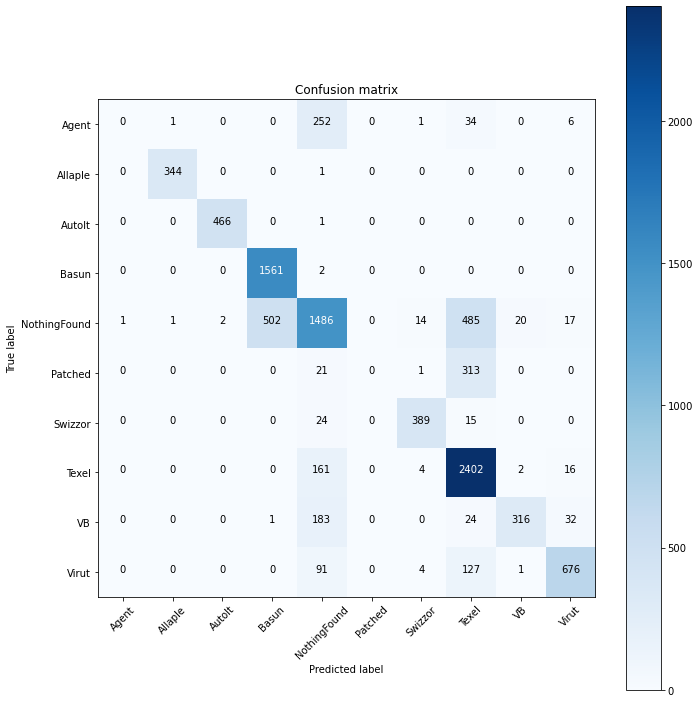

In [82]:
# Plot confusion matrix
enc_labs = open("encoded_labels.pkl", "rb")
le_obj = pickle.load(enc_labs)
cm = confusion_matrix(labels_arr, pred_arr)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, le_obj.classes_)

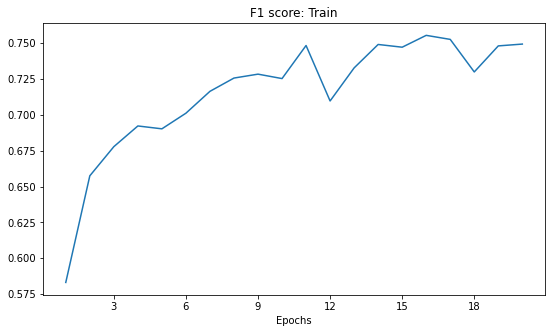

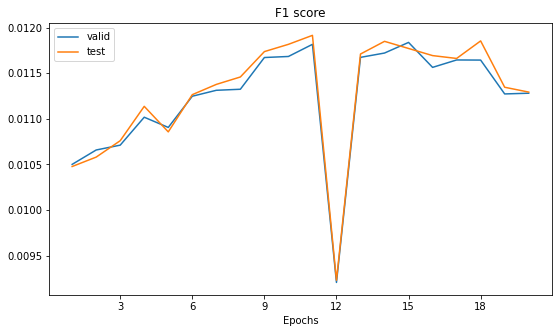

In [76]:
# plotting F1 scores
ax = plt.figure(figsize=(9,5)).gca()
epoch_list = list(range(1, params.epochs+1))
plt.plot(epoch_list,fscore_train, label="train")
plt.title('F1 score: Train')
plt.xlabel("Epochs")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


ax = plt.figure(figsize=(9,5)).gca()
epoch_list = list(range(1, params.epochs+1))
plt.plot(epoch_list,fscore_val, label="valid")
plt.plot(epoch_list,fscore_test, label="test")
plt.title('F1 score')
plt.xlabel("Epochs")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()
plt.show()


## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?

We tried a simple bi-directional LSTM model with 3 hidden layers for which we obtained ~76% accuracy on test data. Looking at the confusion matrix we can conclude that the model correctly predicted `Texel`, `Basun` and `Virut` malware most number of times. Also, malware like `Patched`, `Agent`, `Allaple` were very difficult to detect, of which the model failed to make even a single correct prediction for `Patched` malware. It is also worth noting that the model predicted malware like `Agent`, `Texel` as non-malware. We find it a bit difficult to comment which vectorized input representations helped more than others. However, using the length of the encoded representation packed along with the vectorized sequence helped us achieve better results.

Few scopes of improvements:
1. Use Bi-directional LSTM with attention mechanism or CNN for better classification results
2. Use GRU to save on training costs.
3. Try a different vectorization approach so that the generated sequences encode information about all the feature representation of the malware.